In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\namo\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1


In [249]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import json
import datetime
from datetime import date, timedelta
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Set visualization style
sns.set(style='whitegrid', palette='muted', color_codes=True)

# Import additional libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, log_loss, mean_squared_error, r2_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import random
random.seed(42)
np.random.seed(42)
RANDOM_STATE = 42

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

from plot_utils import *

# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=RANDOM_STATE)

In [3]:
# Input file paths from local kagglehub dataset
raw_data_path = os.path.join(path, 'sp500_headlines_2008_2024.csv')

# Load the raw data
def load_raw_data():
    raw_data = pd.read_csv(raw_data_path)
    raw_data['Date'] = pd.to_datetime(raw_data['Date'])
    return raw_data

sp500_headlines_2008_2024 = load_raw_data()
sp500_headlines_2008_2024

Title       Date       CP
0       JPMorgan Predicts 2008 Will Be "Nothing But Net" 2008-01-02  1447.16
1      Dow Tallies Biggest First-session-of-year Poin... 2008-01-02  1447.16
2                       2008 predictions for the S&P 500 2008-01-02  1447.16
3      U.S. Stocks Higher After Economic Data, Monsan... 2008-01-03  1447.16
4      U.S. Stocks Climb As Hopes Increase For More F... 2008-01-07  1416.18
...                                                  ...        ...      ...
19122          REITs vs. Stocks: What Does the Data Say? 2024-03-04  5130.95
19123  Nasdaq Index, Dow Jones, S&P 500 News: Futures... 2024-03-04  5130.95
19124  Nasdaq 100, Dow Jones, S&P 500 News: Cautious ... 2024-03-04  5130.95
19125  Bank of America boosts S&P 500 target to 5,400... 2024-03-04  5130.95
19126  S&P 500 Gains and Losses Today: Tesla Shares T... 2024-03-04  5130.95

[19127 rows x 3 columns]

In [4]:
sp500_headlines_2008_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19127 entries, 0 to 19126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   19127 non-null  object        
 1   Date    19127 non-null  datetime64[ns]
 2   CP      19127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 448.4+ KB


In [5]:
sp500_headlines_2008_2024.duplicated().sum()

974

<Axes: >

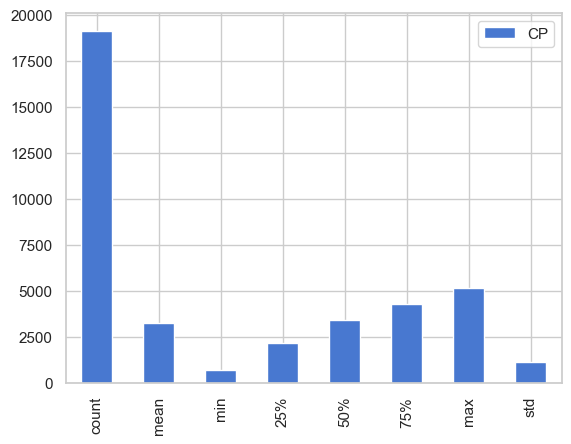

In [6]:
sp500_headlines_2008_2024.describe().plot(kind='bar')

<Axes: xlabel='Date', ylabel='CP'>

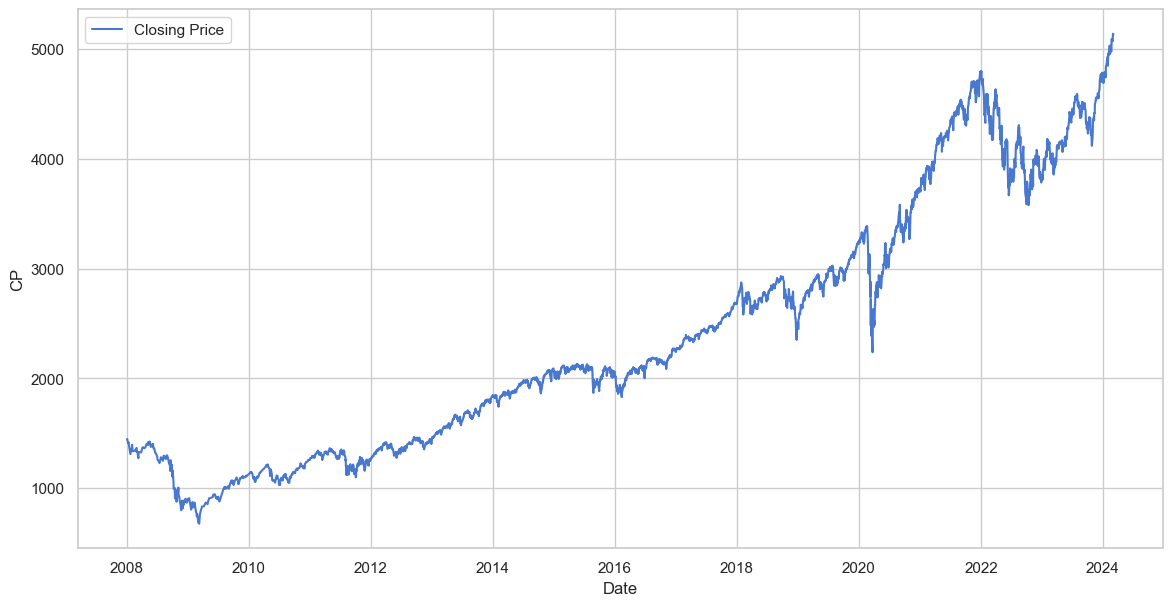

In [7]:
# Plot index prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024, label='Closing Price')

Numeric columns: Index(['CP'], dtype='object')


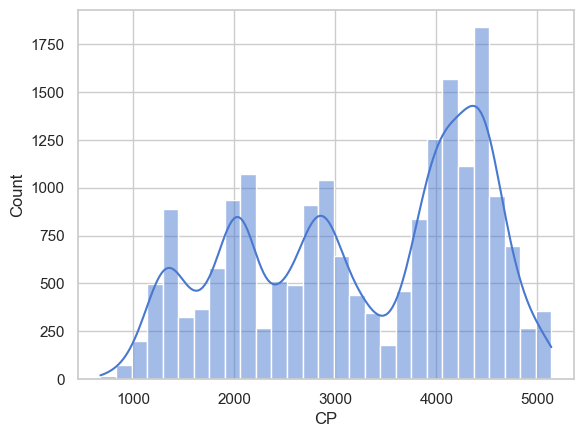

In [8]:
numeric_cols = sp500_headlines_2008_2024.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    sns.histplot(x=col, data=sp500_headlines_2008_2024, kde=True)
    plt.show()

## Prepare sentiment data

In [9]:
# Limit the dataset by number of rows for testing
max_rows = len(sp500_headlines_2008_2024)

In [10]:
# Load FinBERT (pre-trained for financial sentiment)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Custom score: Positive = +1, Neutral = 0, Negative = -1
    score = (probs[0][2] - probs[0][0]).item()
    return score

# Generate sentiment scores
# For testing purposes, we can limit the number of rows processed
sp500_headlines_2008_2024_test = sp500_headlines_2008_2024.head(max_rows)
tqdm.pandas()
sp500_headlines_2008_2024_test['sentiment_score_finbert'] = sp500_headlines_2008_2024_test['Title'].progress_apply(get_sentiment_score)

print(sp500_headlines_2008_2024_test[['Date', 'Title', 'sentiment_score_finbert']].head())

100%|██████████| 19127/19127 [12:54<00:00, 24.70it/s]

        Date                                              Title  \
0 2008-01-02   JPMorgan Predicts 2008 Will Be "Nothing But Net"   
1 2008-01-02  Dow Tallies Biggest First-session-of-year Poin...   
2 2008-01-02                   2008 predictions for the S&P 500   
3 2008-01-03  U.S. Stocks Higher After Economic Data, Monsan...   
4 2008-01-07  U.S. Stocks Climb As Hopes Increase For More F...   

   sentiment_score_finbert  
0                 0.019026  
1                 0.014999  
2                 0.771308  
3                -0.787446  
4                -0.338189  


In [11]:
tt = sp500_headlines_2008_2024.head(1)

inputs = tokenizer(tt['Title'][0], return_tensors="pt", truncation=True)
outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

print(probs)

# Custom score: Positive = +1, Neutral = 0, Negative = -1
score = (probs[0][2] - probs[0][0]).item()

print(score)

tensor([[0.1884, 0.6042, 0.2074]], grad_fn=<SoftmaxBackward0>)
0.0190257728099823


In [49]:
# Define volatility period
volatility_period = [5, 22, 66, 132]  # 5 days, 22 days (1 month), 66 days (3 months), 132 days (6 months)

# Daily average sentiment
daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Calculate rolling n-day sentiment volatility (std deviation)
# a week, a month, a quarter, and half a year
for n in volatility_period:
    # rolling_sent = daily_sentiment['avg_sentiment_score_a_day'].rolling(window=n)
    # mean_sent = rolling_sent.mean()
    # std_sent = rolling_sent.std()
    # daily_sentiment[f'{n}_day_sentiment_volatility'] = std_sent * np.sign(mean_sent)
    daily_sentiment[f'{n}_day_sentiment_volatility'] = daily_sentiment['avg_sentiment_score_a_day'].rolling(window=n).std()

print(daily_sentiment)

           Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN            

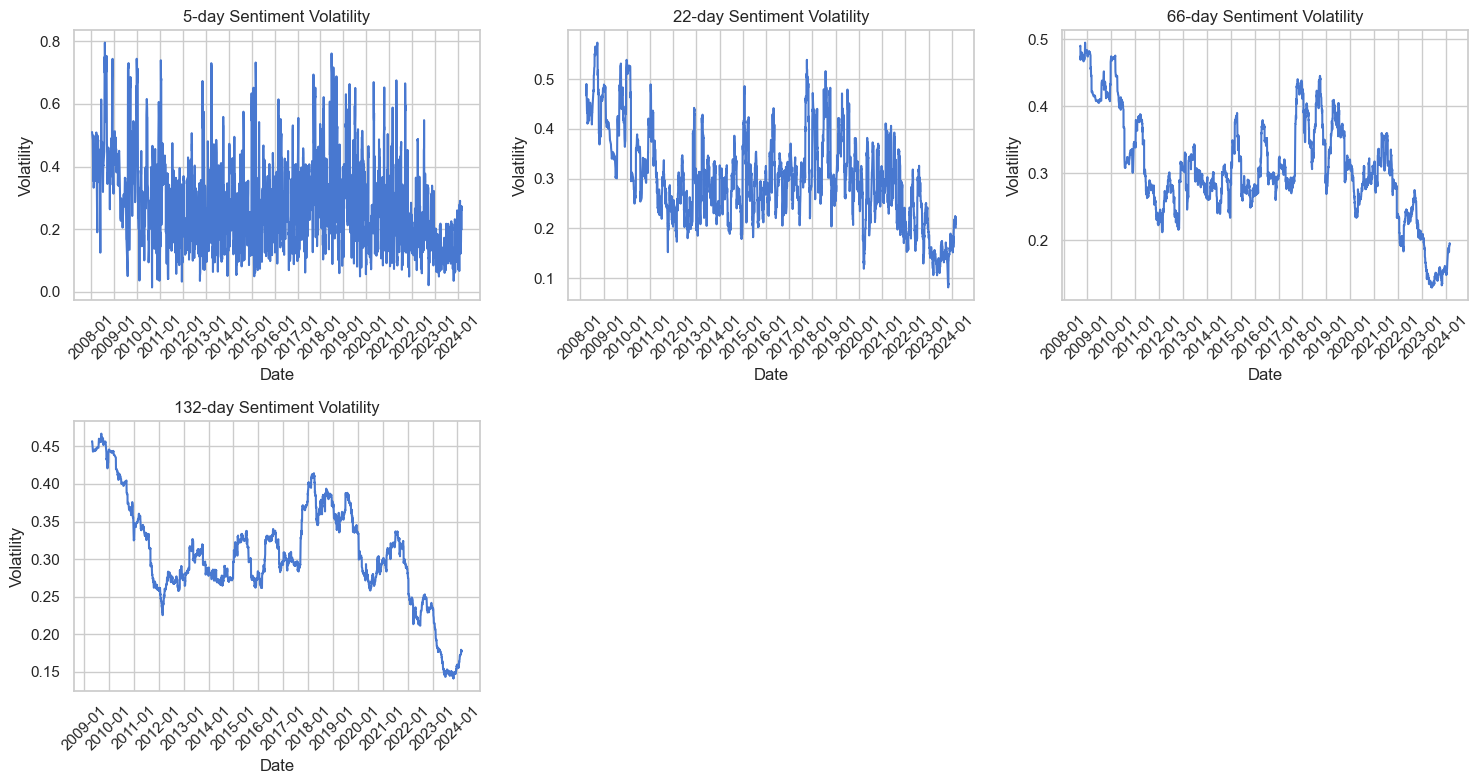

In [50]:
n_cols = 3
n_rows = int(np.ceil(len(volatility_period) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, n in enumerate(volatility_period):
    sns.lineplot(x='Date', y=f'{n}_day_sentiment_volatility', data=daily_sentiment, ax=axes[i])
    axes[i].set_title(f'{n}-day Sentiment Volatility')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility')
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [51]:
# Percentages of each sentiment group by >0, <0, and ==0
def sentiment_percentage(df, column):
    total = len(df)
    positive = len(df[df[column] > 0])
    negative = len(df[df[column] < 0])
    neutral = len(df[df[column] == 0])
    
    return {
        'positive': positive / total * 100,
        'negative': negative / total * 100,
        'neutral': neutral / total * 100
    }

sentiment_stats = sentiment_percentage(daily_sentiment, 'avg_sentiment_score_a_day')
print("Sentiment Statistics:", sentiment_stats)

Sentiment Statistics: {'positive': 90.64727687482178, 'negative': 9.352723125178215, 'neutral': 0.0}


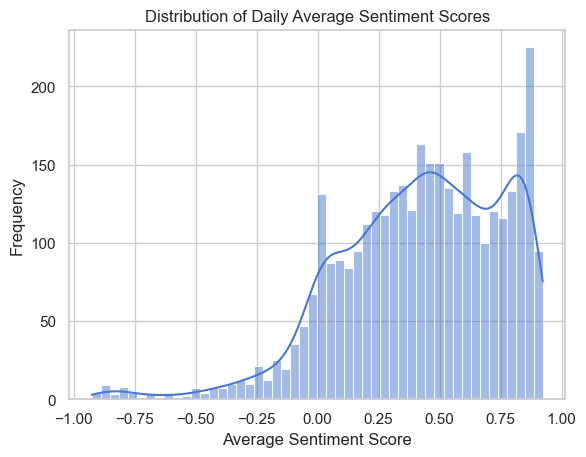

In [52]:
# Plot sentiment distribution
sns.histplot(daily_sentiment['avg_sentiment_score_a_day'], bins=50, kde=True)
plt.title('Distribution of Daily Average Sentiment Scores')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Frequency')
plt.show()

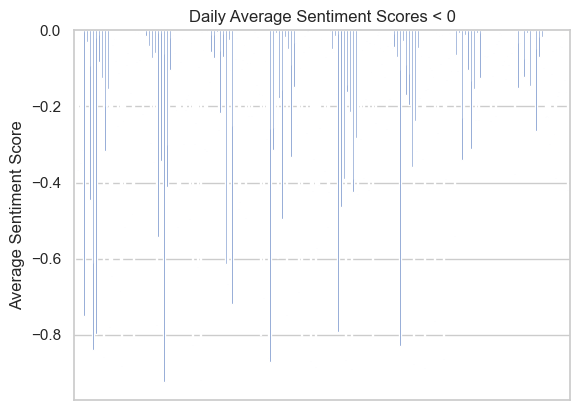

In [53]:
# Plot bar of sentiment which is <0 over time and set X axes to show year only
ax = sns.barplot(x='Date', y='avg_sentiment_score_a_day', data=daily_sentiment[daily_sentiment['avg_sentiment_score_a_day'] < 0])
ax.get_xaxis().set_visible(False)
plt.title('Daily Average Sentiment Scores < 0')
plt.ylabel('Average Sentiment Score')
plt.show()

## Prepare market data

In [54]:
# Drop the 'Title' column
df = sp500_headlines_2008_2024_test.drop(columns=['Title', 'sentiment_score_finbert'])

# Group by 'Date' and aggregate numeric columns
daily_data = df.groupby('Date', as_index=False).mean()

merged_data = pd.merge(daily_sentiment, daily_data[['Date', 'CP']], on='Date', how='left')

In [55]:
# Function to label future crash events based on future close prices
def add_future_crash_label(df, look_ahead_days=252, drop_threshold=0.9, close_col="CP"):
    df = df.copy()
    df["future_close"] = df[close_col].shift(-look_ahead_days)
    df["future_crash"] = (df["future_close"] < df[close_col] * drop_threshold).astype(int)
    return df

# Define look-ahead days and drop threshold
# Number of trading days in a year approximately 252 days
look_ahead_days = 132

# Future close price from today is less than drop_threshold% of the current close price
drop_threshold = 0.9

sp500_headlines_2008_2024_label_added = add_future_crash_label(merged_data, look_ahead_days, drop_threshold)
sp500_headlines_2008_2024_label_added

Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                             NaN                          NaN   
...                           ...                          ...   
3502                     0.218901                     0.191277   
3503                     0.223571                     0.192873   
3504                     0.208376                     0.191889   
3505                     0.216625                     0.195444   
3506                     0.201547                     0.194642   

      132_day_sentiment_volatility       CP  future_close  future_crash  
0                              NaN  1447.16        872.81             1  
1                              NaN  1447.16        907.39             1  
2                              NaN  1416.18        909.24             1  
3                              NaN  1409.13        919.14             1  
4                              NaN  1420.33        942.87             1  
...                            ...      ...           ...           ...  
3502                      0.176086  5078.18           NaN             0  
3503                      0.176693  5069.76           NaN             0  
3504                      0.176523  5096.27           NaN             0  
3505                      0.178177  5137.08           NaN             0  
3506                      0.178143  5130.95           NaN             0  

[3507 rows x 9 columns]

In [56]:
# Count future crash
crashed = sp500_headlines_2008_2024_label_added['future_crash'].value_counts()[1]
not_crashed = sp500_headlines_2008_2024_label_added['future_crash'].value_counts()[0]
print(crashed, not_crashed)

print(f'Ratio of crashed: {round(crashed/(crashed + not_crashed) * 100, 2)} %')

206 3301
Ratio of crashed: 5.87 %


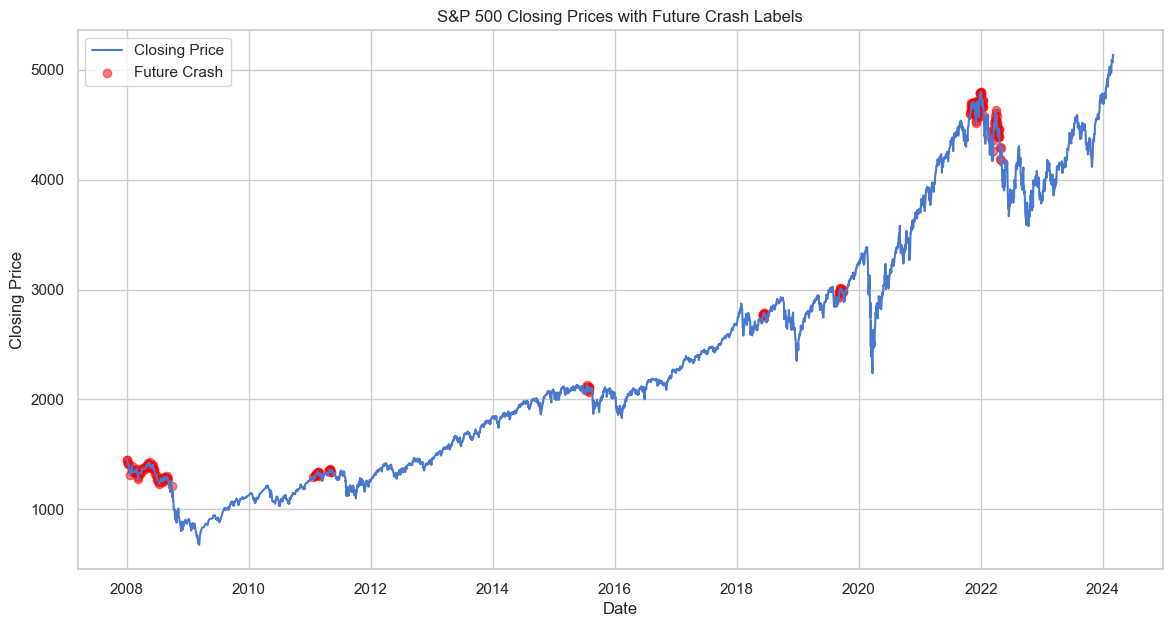

In [57]:
# Plot close prices and future crash labels
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024_label_added, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['CP'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [58]:
# Count total data points per year
total_per_year = sp500_headlines_2008_2024_label_added['Date'].dt.year.value_counts().sort_index()

# Count crashed data points per year
crashed_per_year = (
    sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['Date']
    .dt.year.value_counts()
    .sort_index()
)

# Combine into a DataFrame
yearly_stats = pd.DataFrame({
    'Total Data Points': total_per_year,
    'Crashed Data Points': crashed_per_year
})

# Fill missing years with 0 crashes
yearly_stats['Crashed Data Points'] = yearly_stats['Crashed Data Points'].fillna(0).astype(int)

print(yearly_stats)

      Total Data Points  Crashed Data Points
Date                                        
2008                106                   64
2009                 90                    0
2010                132                    0
2011                216                   20
2012                241                    0
2013                241                    0
2014                242                    0
2015                243                   10
2016                240                    0
2017                228                    0
2018                243                    7
2019                248                   18
2020                249                    0
2021                250                   44
2022                251                   43
2023                244                    0
2024                 43                    0


In [59]:
# Ratio of data points before and after 2022
before_2022 = len(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01'])
after_2022 = len(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01'])
print(f"Data points before 2022: {before_2022}, after 2022: {after_2022}") 
print(f"Ratio of data points before 2022: {before_2022 / (before_2022 + after_2022) * 100:.2f}%")

# Ratio of crash data before and after 2022
crashed_before_2022 = len(sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)])
crashed_after_2022 = len(sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)])
print(f"Crashes before 2022: {crashed_before_2022}, after 2022: {crashed_after_2022}")
print(f"Ratio of crashes before 2022: {crashed_before_2022 / (crashed_before_2022 + crashed_after_2022) * 100:.2f}%")

Data points before 2022: 2969, after 2022: 538
Ratio of data points before 2022: 84.66%
Crashes before 2022: 163, after 2022: 43
Ratio of crashes before 2022: 79.13%


In [60]:
# From the info above, it seems to be good if we split the data into 2008-2021, 2022-somewhere in the middle of 2022 for validating, and the rest for testing.
# Explore this hypothesis
train_data = sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01']

# Summarize crash date from the rest of the data (exclude training data)
crash_in_rest_data = sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)]
print(crash_in_rest_data['Date'].describe())

count                               43
mean     2022-03-13 11:43:15.348837120
min                2022-01-03 00:00:00
25%                2022-02-06 00:00:00
50%                2022-03-28 00:00:00
75%                2022-04-11 12:00:00
max                2022-05-03 00:00:00
Name: Date, dtype: object


In [61]:
# Calculate daily returns
sp500_headlines_2008_2024_label_added['daily_return'] = sp500_headlines_2008_2024_label_added['CP'].pct_change() * 100  # Convert to percentage

# Prepare market data
market_sentiment_data = sp500_headlines_2008_2024_label_added.copy()
market_sentiment_data['Date'] = pd.to_datetime(market_sentiment_data['Date'])

market_sentiment_data

Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                             NaN                          NaN   
...                           ...                          ...   
3502                     0.218901                     0.191277   
3503                     0.223571                     0.192873   
3504                     0.208376                     0.191889   
3505                     0.216625                     0.195444   
3506                     0.201547                     0.194642   

      132_day_sentiment_volatility       CP  future_close  future_crash  \
0                              NaN  1447.16        872.81             1   
1                              NaN  1447.16        907.39             1   
2                              NaN  1416.18        909.24             1   
3                              NaN  1409.13        919.14             1   
4                              NaN  1420.33        942.87             1   
...                            ...      ...           ...           ...   
3502                      0.176086  5078.18           NaN             0   
3503                      0.176693  5069.76           NaN             0   
3504                      0.176523  5096.27           NaN             0   
3505                      0.178177  5137.08           NaN             0   
3506                      0.178143  5130.95           NaN             0   

      daily_return  
0              NaN  
1         0.000000  
2        -2.140745  
3        -0.497818  
4         0.794817  
...            ...  
3502      0.170627  
3503     -0.165807  
3504      0.522904  
3505      0.800782  
3506     -0.119328  

[3507 rows x 10 columns]

In [62]:
# Calculate n-day returns
def calculate_n_day_returns(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_return'] = data['CP'].pct_change(periods=n) * 100  # Convert to percentage
    return data

market_sentiment_data = calculate_n_day_returns(market_sentiment_data, volatility_period)
market_sentiment_data

Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                             NaN                          NaN   
...                           ...                          ...   
3502                     0.218901                     0.191277   
3503                     0.223571                     0.192873   
3504                     0.208376                     0.191889   
3505                     0.216625                     0.195444   
3506                     0.201547                     0.194642   

      132_day_sentiment_volatility       CP  future_close  future_crash  \
0                              NaN  1447.16        872.81             1   
1                              NaN  1447.16        907.39             1   
2                              NaN  1416.18        909.24             1   
3                              NaN  1409.13        919.14             1   
4                              NaN  1420.33        942.87             1   
...                            ...      ...           ...           ...   
3502                      0.176086  5078.18           NaN             0   
3503                      0.176693  5069.76           NaN             0   
3504                      0.176523  5096.27           NaN             0   
3505                      0.178177  5137.08           NaN             0   
3506                      0.178143  5130.95           NaN             0   

      daily_return  5_day_market_return  22_day_market_return  \
0              NaN                  NaN                   NaN   
1         0.000000                  NaN                   NaN   
2        -2.140745                  NaN                   NaN   
3        -0.497818                  NaN                   NaN   
4         0.794817                  NaN                   NaN   
...            ...                  ...                   ...   
3502      0.170627             2.063507              3.759992   
3503     -0.165807             1.765627              3.655512   
3504      0.522904             0.181638              3.416039   
3505      0.800782             0.948750              4.306828   
3506     -0.119328             1.211552              5.887755   

      66_day_market_return  132_day_market_return  
0                      NaN                    NaN  
1                      NaN                    NaN  
2                      NaN                    NaN  
3                      NaN                    NaN  
4                      NaN                    NaN  
...                    ...                    ...  
3502             11.672655              16.195920  
3503             11.713260              16.020514  
3504             11.843208              15.830373  
3505             12.671571              17.083110  
3506             12.757476              15.665880  

[3507 rows x 14 column

In [63]:
# Calculate n-day volatility
def calculate_n_day_volatility(data, volatility_period):
    for n in volatility_period:
        # rolling_return = data['daily_return'].rolling(window=n)
        # mean_return = rolling_return.mean()
        # std_return = rolling_return.std()
        # data[f'{n}_day_market_volatility'] = std_return * np.sqrt(n) * np.sign(mean_return)
        data[f'{n}_day_market_volatility'] = data['daily_return'].rolling(window=n).std() * np.sqrt(n)  # Standard deviation of closing prices
    return data

market_sentiment_data = calculate_n_day_volatility(market_sentiment_data, volatility_period)
market_sentiment_data

Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                             NaN                          NaN   
...                           ...                          ...   
3502                     0.218901                     0.191277   
3503                     0.223571                     0.192873   
3504                     0.208376                     0.191889   
3505                     0.216625                     0.195444   
3506                     0.201547                     0.194642   

      132_day_sentiment_volatility       CP  future_close  future_crash  \
0                              NaN  1447.16        872.81             1   
1                              NaN  1447.16        907.39             1   
2                              NaN  1416.18        909.24             1   
3                              NaN  1409.13        919.14             1   
4                              NaN  1420.33        942.87             1   
...                            ...      ...           ...           ...   
3502                      0.176086  5078.18           NaN             0   
3503                      0.176693  5069.76           NaN             0   
3504                      0.176523  5096.27           NaN             0   
3505                      0.178177  5137.08           NaN             0   
3506                      0.178143  5130.95           NaN             0   

      daily_return  5_day_market_return  22_day_market_return  \
0              NaN                  NaN                   NaN   
1         0.000000                  NaN                   NaN   
2        -2.140745                  NaN                   NaN   
3        -0.497818                  NaN                   NaN   
4         0.794817                  NaN                   NaN   
...            ...                  ...                   ...   
3502      0.170627             2.063507              3.759992   
3503     -0.165807             1.765627              3.655512   
3504      0.522904             0.181638              3.416039   
3505      0.800782             0.948750              4.306828   
3506     -0.119328             1.211552              5.887755   

      66_day_market_return  132_day_market_return  5_day_market_volatility  \
0                      NaN                    NaN                      NaN   
1                      NaN                    NaN                      NaN   
2                      NaN                    NaN                      NaN   
3                      NaN                    NaN                      NaN   
4                      NaN                    NaN                      NaN   
...                    ...                    ...                      ...   
3502             11.672655              16.195920                 2.178946   
3503             11.713

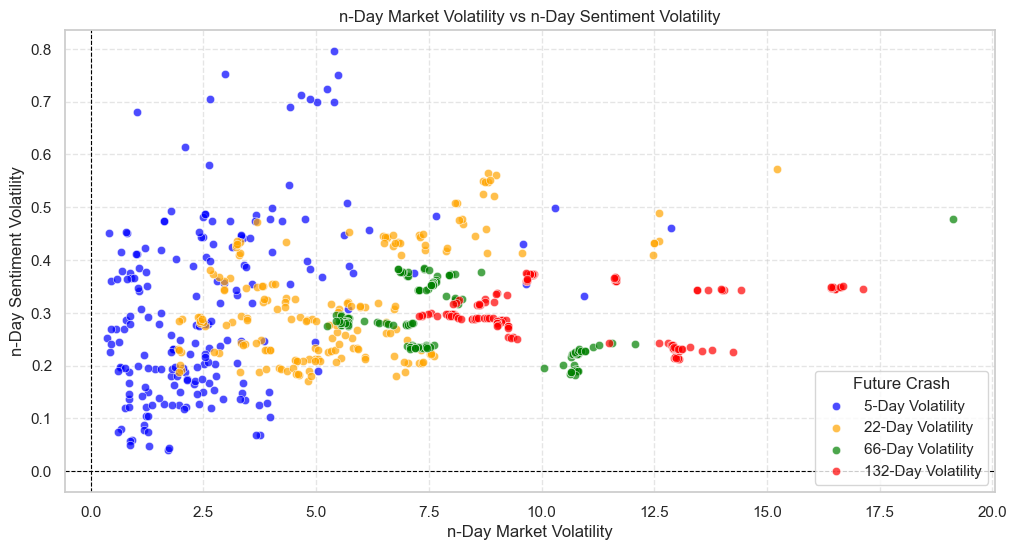

In [66]:
# Plot relationship between future crash and n-day market volatility combined with sentiment volatility
# Plot for 5 day, 22 day, 66 day, and 126 day volatility
crash_data = market_sentiment_data[market_sentiment_data['future_crash'] == 1]

# Scale the market volatility and sentiment volatility for better visualization
def scale_to_0_1(series):
    return (series - series.min()) / (series.max() - series.min())

scale_crash_data = crash_data.copy()

# for n in volatility_period:
#     scale_crash_data[f'{n}_day_market_volatility'] = scale_to_0_1(crash_data[f'{n}_day_market_volatility'])
#     scale_crash_data[f'{n}_day_sentiment_volatility'] = scale_to_0_1(crash_data[f'{n}_day_sentiment_volatility'])

plt.figure(figsize=(12, 6))
sns.scatterplot(x='5_day_market_volatility', y='5_day_sentiment_volatility', data=scale_crash_data, label='5-Day Volatility', alpha=0.7, color='blue')
sns.scatterplot(x='22_day_market_volatility', y='22_day_sentiment_volatility', data=scale_crash_data, label='22-Day Volatility', alpha=0.7, color='orange')
sns.scatterplot(x='66_day_market_volatility', y='66_day_sentiment_volatility', data=scale_crash_data, label='66-Day Volatility', alpha=0.7, color='green')
sns.scatterplot(x='132_day_market_volatility', y='132_day_sentiment_volatility', data=scale_crash_data, label='132-Day Volatility', alpha=0.7, color='red')
# sns.scatterplot(x='252_day_market_volatility', y='252_day_sentiment_volatility', data=scale_crash_data, label='252-Day Volatility', alpha=0.7, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('n-Day Market Volatility vs n-Day Sentiment Volatility')
plt.xlabel('n-Day Market Volatility')
plt.ylabel('n-Day Sentiment Volatility')
plt.legend(title='Future Crash', loc='lower right')
plt.show()

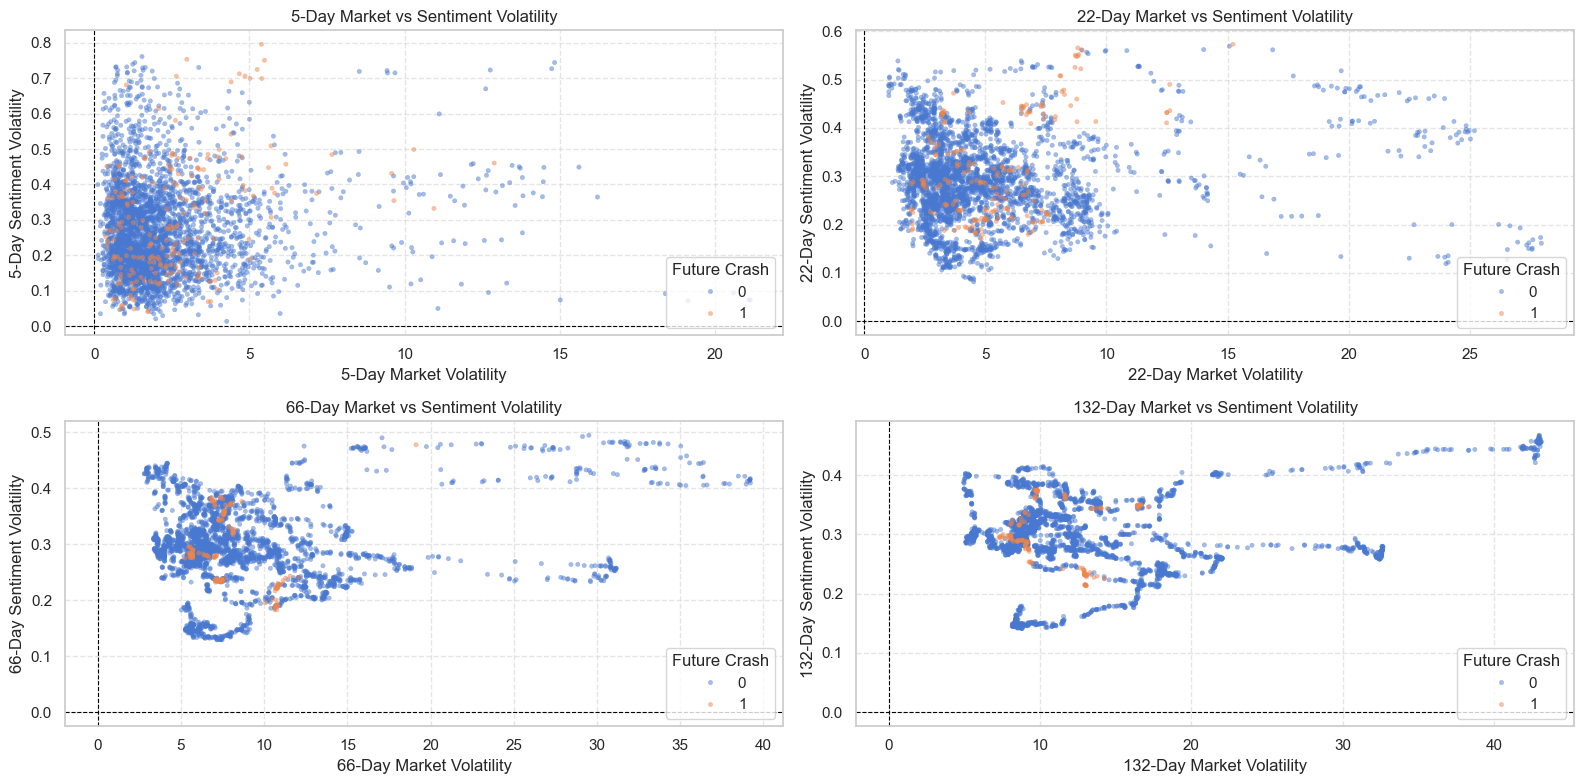

In [68]:
# Plot relationship between n-day market volatility and n-day sentiment volatility for each volatility period
n_cols = 2
n_rows = (len(volatility_period) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

scale_crash_data = market_sentiment_data.copy()
# for n in volatility_period:
#     scale_crash_data[f'{n}_day_market_volatility'] = scale_to_0_1(market_sentiment_data[f'{n}_day_market_volatility'])
#     scale_crash_data[f'{n}_day_sentiment_volatility'] = scale_to_0_1(market_sentiment_data[f'{n}_day_sentiment_volatility'])
df_sorted = scale_crash_data.sort_values('future_crash')

for idx, n in enumerate(volatility_period):
    ax = axes[idx]
    x_col = f'{n}_day_market_volatility'
    y_col = f'{n}_day_sentiment_volatility'

    # Drop NA values for clean plot
    df_plot = df_sorted.dropna(subset=[x_col, y_col, 'future_crash'])

    sns.scatterplot(
        x=x_col, y=y_col, hue='future_crash', data=df_plot, alpha=0.5, ax=ax, edgecolor=None, s=10
    )
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(f'{n}-Day Market vs Sentiment Volatility')
    ax.set_xlabel(f'{n}-Day Market Volatility')
    ax.set_ylabel(f'{n}-Day Sentiment Volatility')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Future Crash', loc='lower right')

# Remove unused subplots
for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.legend(title='Future Crash', loc='lower right')
plt.show()

## Modelling

### Add VIX

In [ ]:
import yfinance as yf

# Download VIX data
vix_data = yf.download("^VIX", start="2008-01-01", end="2024-12-31")
vix_data = vix_data[['Close']].rename(columns={'Close': 'VIX'})

# Flatten it
vix_data.columns = [col[1] if isinstance(col, tuple) else col for col in vix_data.columns]
vix_data = vix_data.rename(columns={'Close': 'VIX'})

merged_data = market_sentiment_data.merge(vix_data, how='left', left_on='Date', right_index=True)
merged_data

[*********************100%***********************]  1 of 1 completed

Index(['^VIX'], dtype='object')


Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                             NaN                          NaN   
...                           ...                          ...   
3502                     0.218901                     0.191277   
3503                     0.223571                     0.192873   
3504                     0.208376                     0.191889   
3505                     0.216625                     0.195444   
3506                     0.201547                     0.194642   

      132_day_sentiment_volatility       CP  future_close  future_crash  \
0                              NaN  1447.16        872.81             1   
1                              NaN  1447.16        907.39             1   
2                              NaN  1416.18        909.24             1   
3                              NaN  1409.13        919.14             1   
4                              NaN  1420.33        942.87             1   
...                            ...      ...           ...           ...   
3502                      0.176086  5078.18           NaN             0   
3503                      0.176693  5069.76           NaN             0   
3504                      0.176523  5096.27           NaN             0   
3505                      0.178177  5137.08           NaN             0   
3506                      0.178143  5130.95           NaN             0   

      daily_return  ...     ^VIX_x     VaR_5      ES_5    VaR_22     ES_22  \
0              NaN  ...  23.170000       NaN       NaN       NaN       NaN   
1         0.000000  ...  22.490000       NaN       NaN       NaN       NaN   
2        -2.140745  ...  23.790001       NaN       NaN       NaN       NaN   
3        -0.497818  ...  24.120001       NaN       NaN       NaN       NaN   
4         0.794817  ...  23.450001       NaN       NaN       NaN       NaN   
...            ...  ...        ...       ...       ...       ...       ...   
3502      0.170627  ...  13.430000 -2.011074 -2.439613 -1.546801 -1.915685   
3503     -0.165807  ...  13.840000 -2.001497 -2.443142 -1.544889 -1.914487   
3504      0.522904  ...  13.400000 -0.597621 -0.748027 -1.523933 -1.890749   
3505      0.800782  ...  13.110000 -0.982488 -1.195022 -1.578664 -1.949663   
3506     -0.119328  ...  13.490000 -0.924457 -1.107519 -1.486135 -1.814143   

        VaR_66     ES_66   VaR_132    ES_132     ^VIX_y  
0          NaN       NaN       NaN       NaN  23.170000  
1          NaN       NaN       NaN       NaN  22.490000  
2          NaN       NaN       NaN       NaN  23.790001  
3          NaN       NaN       NaN       NaN  24.120001  
4          NaN       NaN       NaN       NaN  23.450001  
...        ...       ...       ...       ...        ...  
3502 -1.255907 -1.547235 -1.360290 -1.693808  13.430000  
3503 -1.255968 -1.547165 -1

### Add VaR and ES features

In [72]:
def add_var_es_features(df, return_col='daily_return', windows=volatility_period, confidence=0.05):
    df = df.copy()
    z_score = abs(np.percentile(np.random.normal(size=100000), confidence * 100))  # ≈1.64 for 95%, 1.96 for 97.5%

    for w in windows:
        # Rolling mean and std of returns
        rolling_mu = df[return_col].rolling(window=w).mean()
        rolling_sigma = df[return_col].rolling(window=w).std()

        # Parametric Gaussian VaR (1-day, % return)
        df[f'VaR_{w}'] = - (rolling_mu + z_score * rolling_sigma)

        # Expected Shortfall (ES) assuming normal distribution
        pdf_factor = np.exp(-0.5 * z_score**2) / (np.sqrt(2 * np.pi))
        cdf_factor = confidence
        df[f'ES_{w}'] = - (rolling_mu + (rolling_sigma * pdf_factor / cdf_factor))
    
    return df

market_sentiment_data = add_var_es_features(merged_data, return_col='daily_return')

In [73]:
market_sentiment_data.columns

Index(['Date', 'avg_sentiment_score_a_day', '5_day_sentiment_volatility',
       '22_day_sentiment_volatility', '66_day_sentiment_volatility',
       '132_day_sentiment_volatility', 'CP', 'future_close', 'future_crash',
       'daily_return', '5_day_market_return', '22_day_market_return',
       '66_day_market_return', '132_day_market_return',
       '5_day_market_volatility', '22_day_market_volatility',
       '66_day_market_volatility', '132_day_market_volatility', '^VIX',
       'VaR_5', 'ES_5', 'VaR_22', 'ES_22', 'VaR_66', 'ES_66', 'VaR_132',
       'ES_132'],
      dtype='object')

In [74]:
train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
test_data = market_sentiment_data[market_sentiment_data['Date'] >= '2022-01-01']
target_col = 'future_crash'

print(train_data.shape, test_data.shape)

(2969, 27) (538, 27)


### RandomForest

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_results = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # # Drop rows with NaN values in feature columns
    # X = market_sentiment_data[feature_cols].dropna()
    # y = market_sentiment_data.loc[X.index, target_col]

    # X = X.fillna(X.mean())  # Fill NaN values with column means
    # X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE) 
    # X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    
    # X_test_dict[n] = X_test
    # y_test_dict[n] = y_test

    train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
    test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    grid.fit(X_resampled, y_resampled)

    print("Best params:", grid.best_params_)
    print("Best AUC on CV:", grid.best_score_)

    # Reuse best model
    rf_model = grid.best_estimator_

    # Predict
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("Best Model ROC AUC:", roc_auc_score(y_test, y_proba))

    # Save everything for later
    rf_results[n] = {
        'model': rf_model,
        'best_params': grid.best_params_,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC on CV: 0.9366563241728388
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       495
           1       0.09      0.16      0.12        43

    accuracy                           0.80       538
   macro avg       0.51      0.51      0.50       538
weighted avg       0.86      0.80      0.83       538

Best Model ROC AUC: 0.45151515151515154
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC on CV: 0.9543553610650183
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       495
           1       0.04      0.07      0.05        43

    accuracy                           0.77       538
   macro avg       0.47  

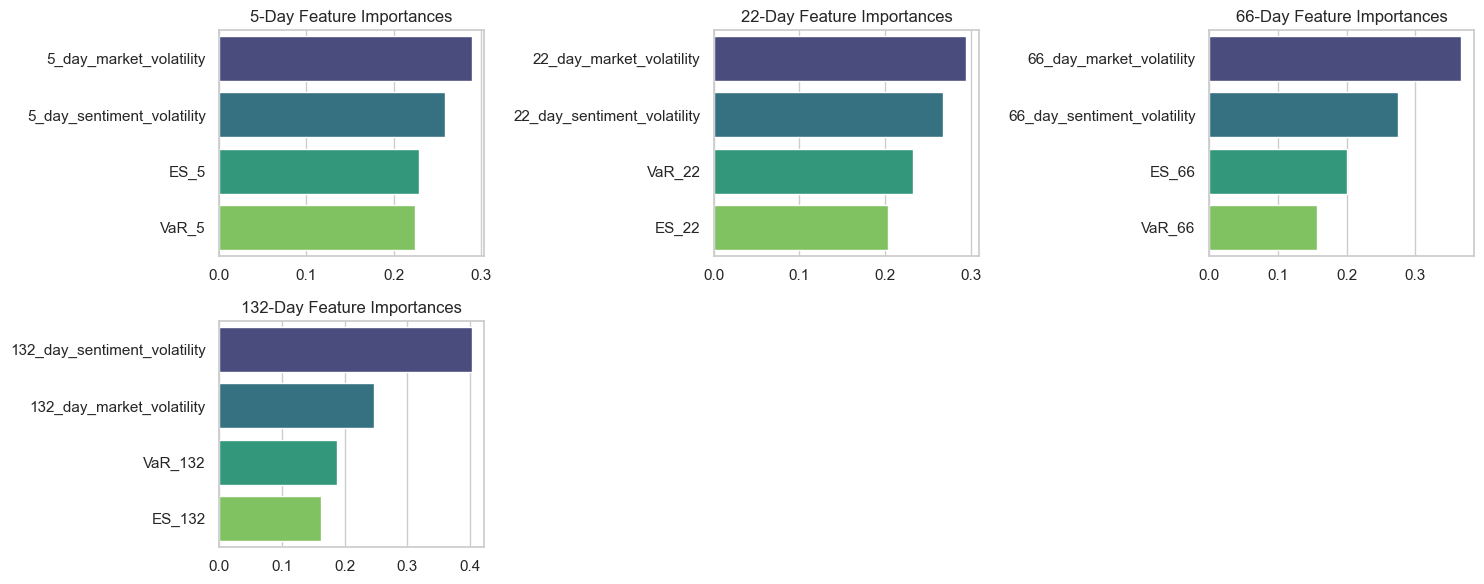

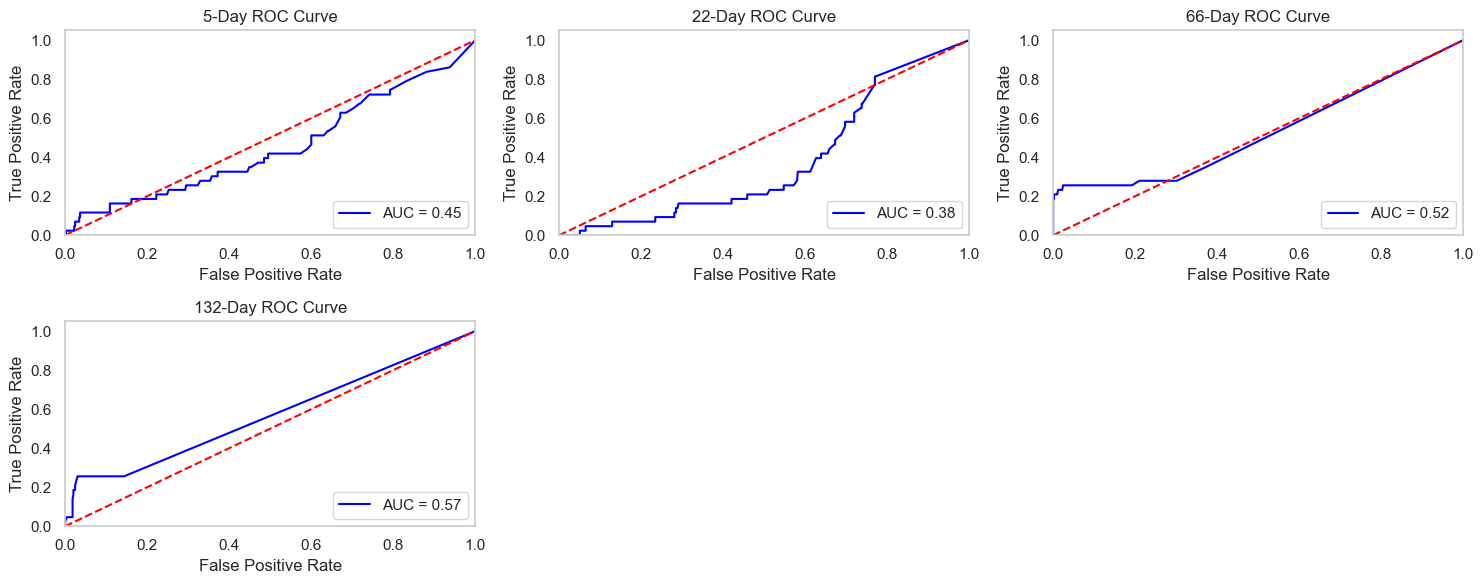

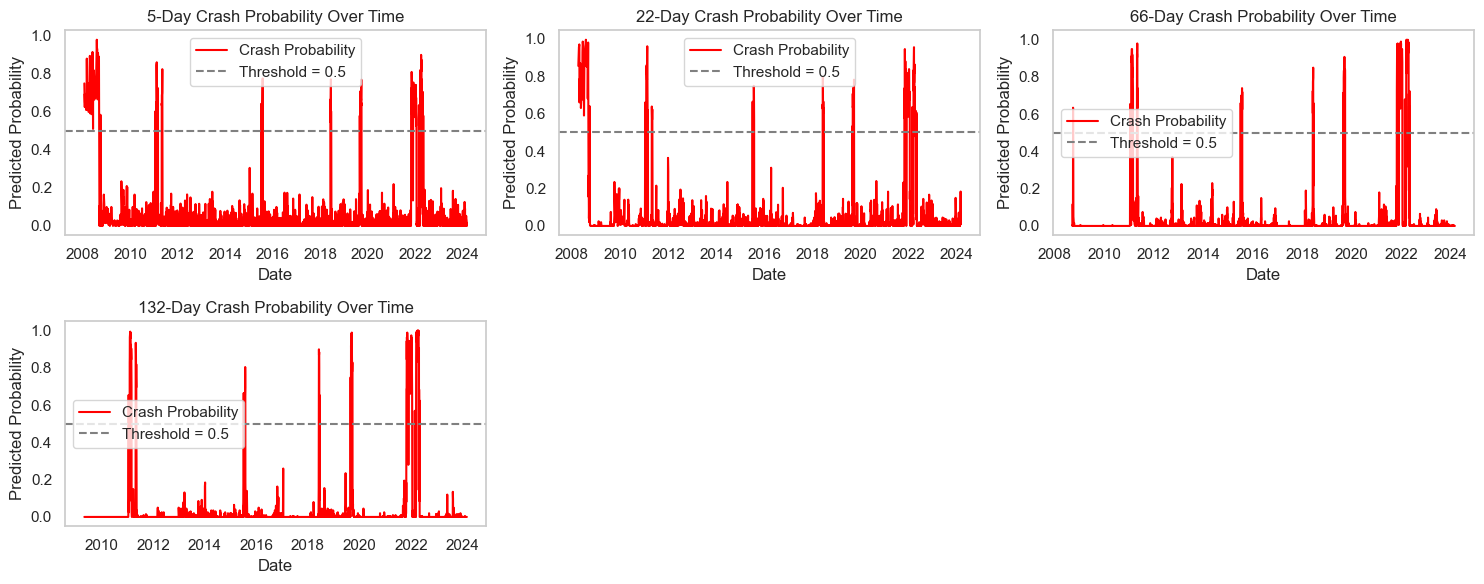

In [76]:
plot_feature_importances_grid(rf_results)
plot_roc_curves_grid(rf_results, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(rf_results, market_sentiment_data, target_col='future_crash')

### Logit Model

In [ ]:
from sklearn.linear_model import LogisticRegression


logit_results = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
        # f'{n}_day_market_return',
        # f'avg_sentiment_score_a_day',
    ]

    # Drop NA rows for this n
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()
    
    X = df_model[feature_cols]
    y = df_model['future_crash']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE) 
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    logit = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000, 
        class_weight='balanced',
        C=1.0,
        l1_ratio=0.5)
    logit.fit(X_resampled, y_resampled)

    y_pred = logit.predict(X_test)
    y_proba = logit.predict_proba(X_test)[:, 1]

    # Save results
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    logit_results[n] = {
        'model': logit,
        'auc_score': auc_score,
        'report': report,
        'coefficients': coefficients,
        'confusion': conf,
    }

    # Store for ROC plotting, etc.
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    # Optional print
    print(f"\n=== {n}-Day Logit Model ===")
    print(f"AUC: {auc_score:.3f}")
    print("classification_report:")
    print(report)


=== 5-Day Logit Model ===
AUC: 0.537
classification_report:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       661
           1       0.06      0.40      0.11        40

    accuracy                           0.61       701
   macro avg       0.50      0.51      0.43       701
weighted avg       0.89      0.61      0.72       701


=== 22-Day Logit Model ===
AUC: 0.545
classification_report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76       660
           1       0.07      0.46      0.12        37

    accuracy                           0.63       697
   macro avg       0.51      0.55      0.44       697
weighted avg       0.91      0.63      0.73       697


=== 66-Day Logit Model ===
AUC: 0.531
classification_report:
              precision    recall  f1-score   support

           0       0.96      0.43      0.60       660
           1       0.05      0.62      0.09        2

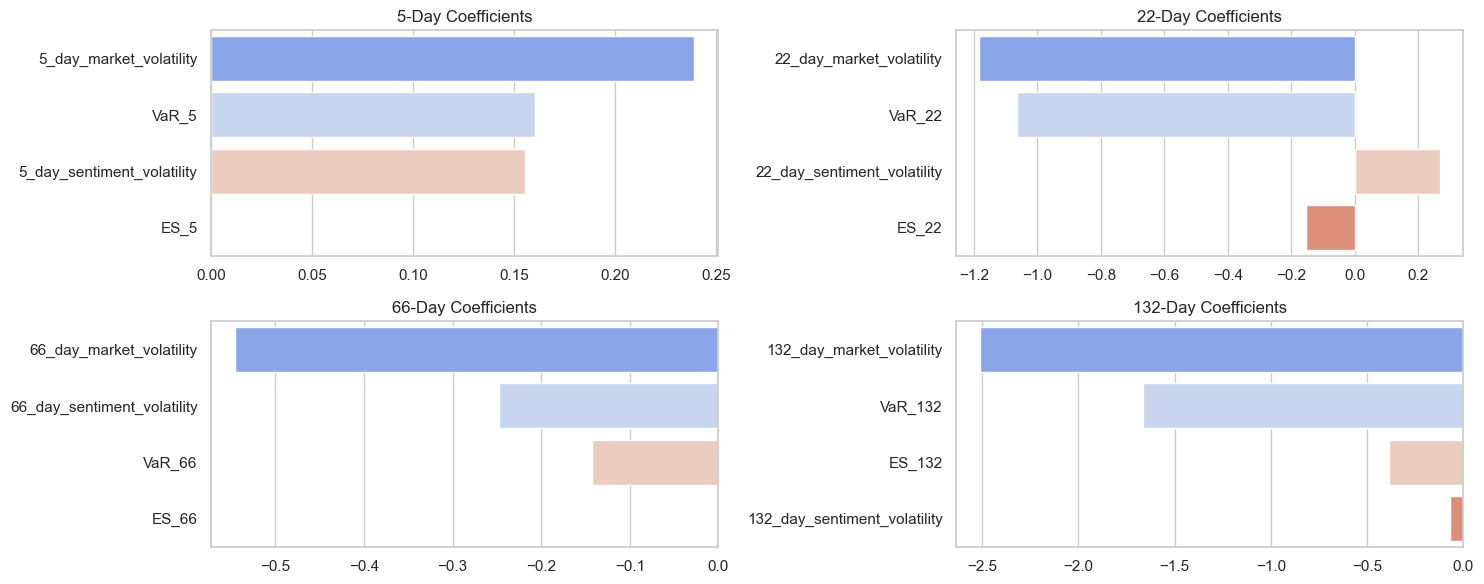

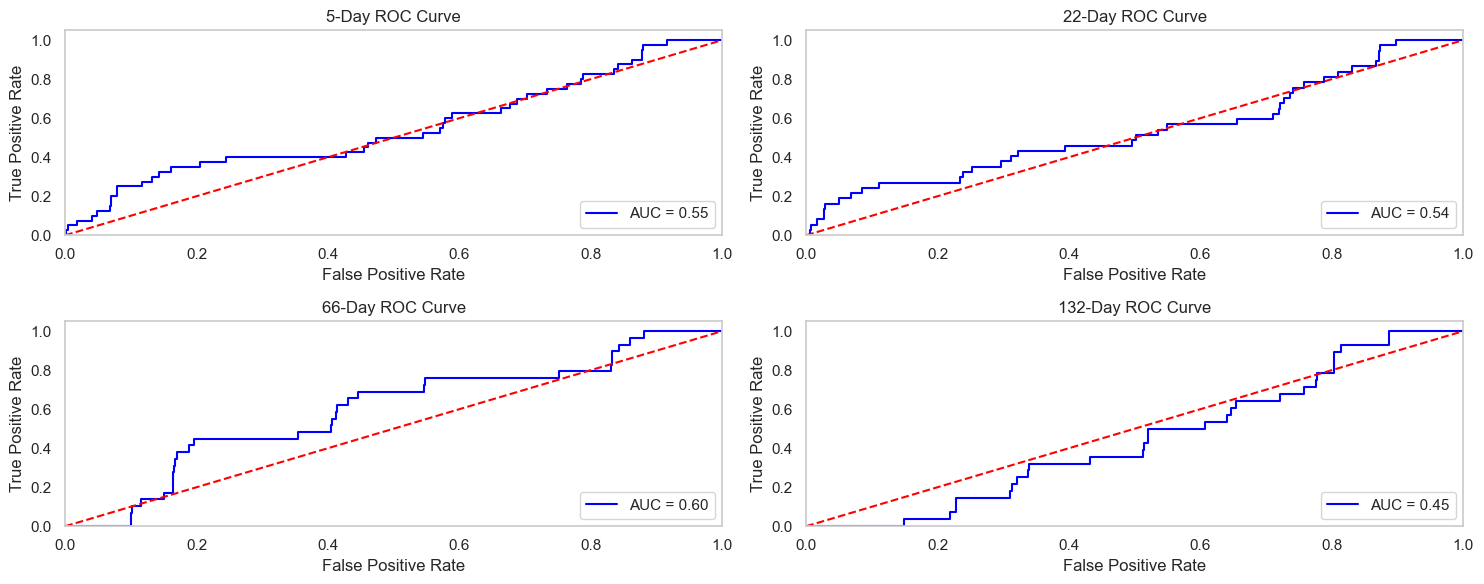

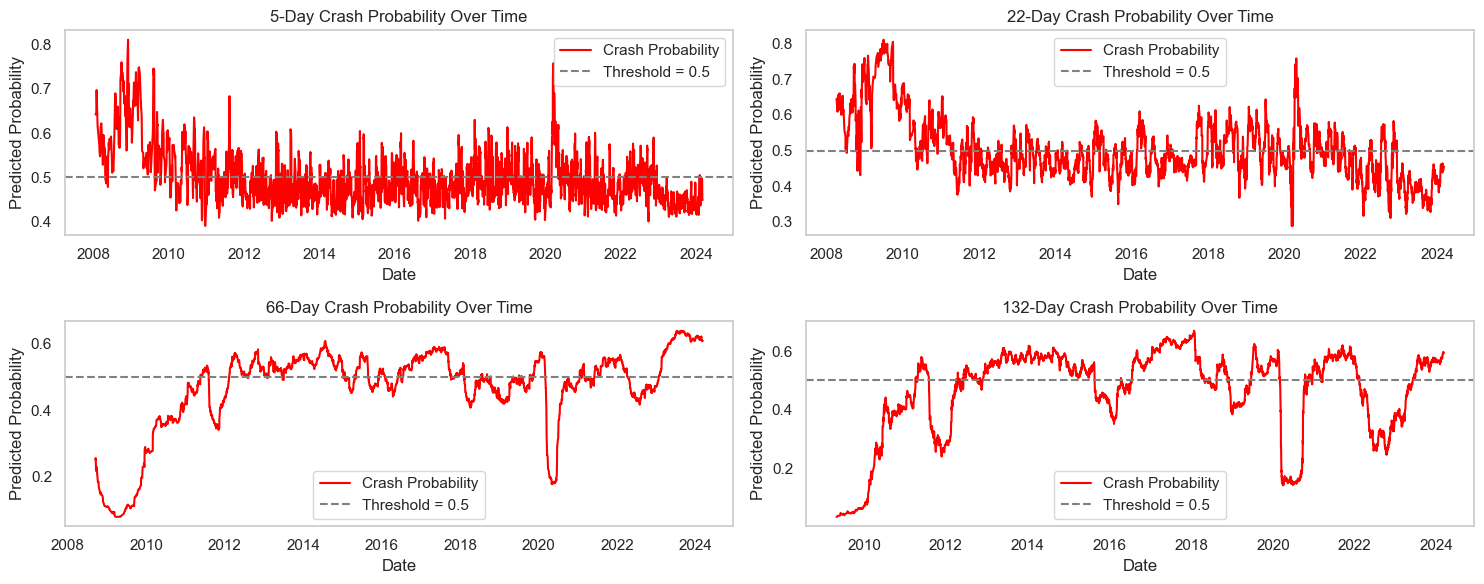

In [81]:
plot_logit_coefficients_grid(logit_results)
plot_roc_curves_grid(logit_results, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(logit_results, market_sentiment_data, target_col='future_crash')

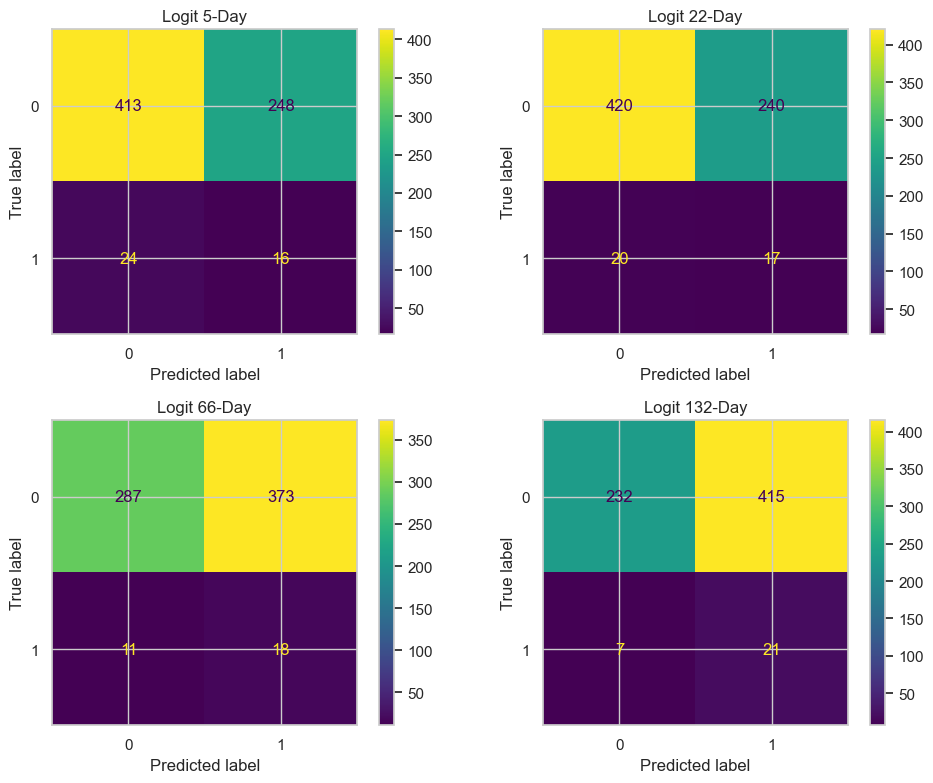

In [83]:
conf_matrices = []
titles = []
for n in volatility_period:
    conf_matrices.append(logit_results[n]['confusion'])
    titles.append(f'Logit {n}-Day')

plot_confusion_matrix_grid(conf_matrices, titles, ncols=2)

## Static Logit Regression

In [376]:
all_results = []

In [369]:
def static_logit_regression(n, feature_cols, market_sentiment_data, static_logit, X_test_dict, y_test_dict):
    train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
    test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    
    # Apply SMOTE or any resampling to the training set only
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    # X_resampled, y_resampled = X_train, y_train  # For simplicity, using original training data without resampling

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    # Fit Logistic Regression
    logit = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000, 
        class_weight='balanced',
        C=1.0,
        l1_ratio=0.5)
    logit.fit(X_resampled, y_resampled)

    # Predict on training set
    y_pred_train = logit.predict(X_resampled)
    y_proba_train = logit.predict_proba(X_resampled)[:, 1]

    y_proba_test = logit.predict_proba(X_test)[:, 1]
    best_thresh = dynamic_threshold_calculate(y_test, y_proba_test)
    y_pred_test = (y_proba_test >= best_thresh).astype(int)

    # Log loss (cross-entropy)
    train_loss = log_loss(y_resampled, y_proba_train)

    # Save results
    auc_test = roc_auc_score(y_test, y_proba_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    conf = confusion_matrix(y_test, y_pred_test)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    static_logit[n] = {
        'model': logit,
        'auc_score': auc_test,
        'train_log_loss': train_loss,
        'report': report_test,
        'coefficients': coefficients,
        'y_test_pred': y_pred_test,
        'y_test_proba': y_proba_test,
        'confusion': conf,
    }

    # Save test set for plotting or later comparison
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    # Print summary
    print(f"\n=== {n}-Day Static Logit Model ===")
    print(f"Test AUC: {auc_test:.3f}")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_pred_test))

### Static Logit Regression (Market)

In [377]:
static_logit_market = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_market, X_test_dict, y_test_dict)

all_results.append(static_logit_market)

Best threshold: 0.48, F1: 0.17

=== 5-Day Static Logit Model ===
Test AUC: 0.542
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.31      0.47       495
           1       0.10      0.86      0.17        43

    accuracy                           0.35       538
   macro avg       0.53      0.58      0.32       538
weighted avg       0.89      0.35      0.44       538

Best threshold: 0.51, F1: 0.26

=== 22-Day Static Logit Model ===
Test AUC: 0.687
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       495
           1       0.17      0.53      0.26        43

    accuracy                           0.75       538
   macro avg       0.56      0.65      0.55       538
weighted avg       0.89      0.75      0.80       538

Best threshold: 0.27, F1: 0.19

=== 66-Day Static Logit Model ===
Test AUC: 0.417
Classification Report (Test):
           

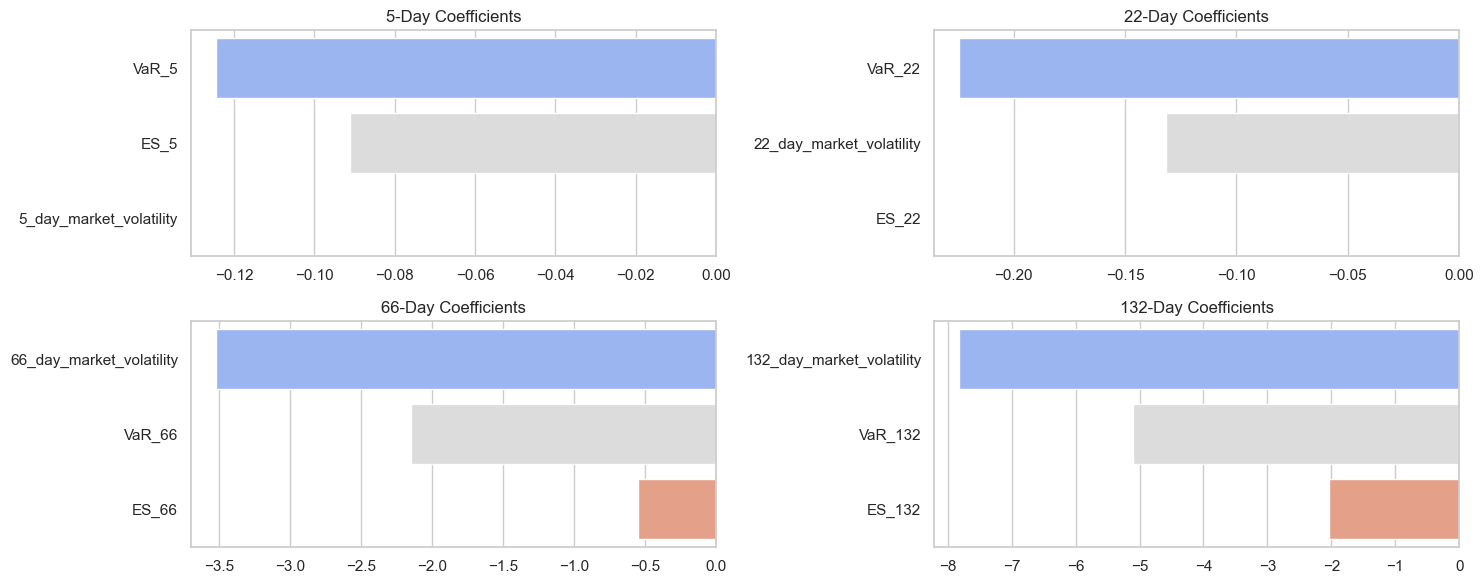

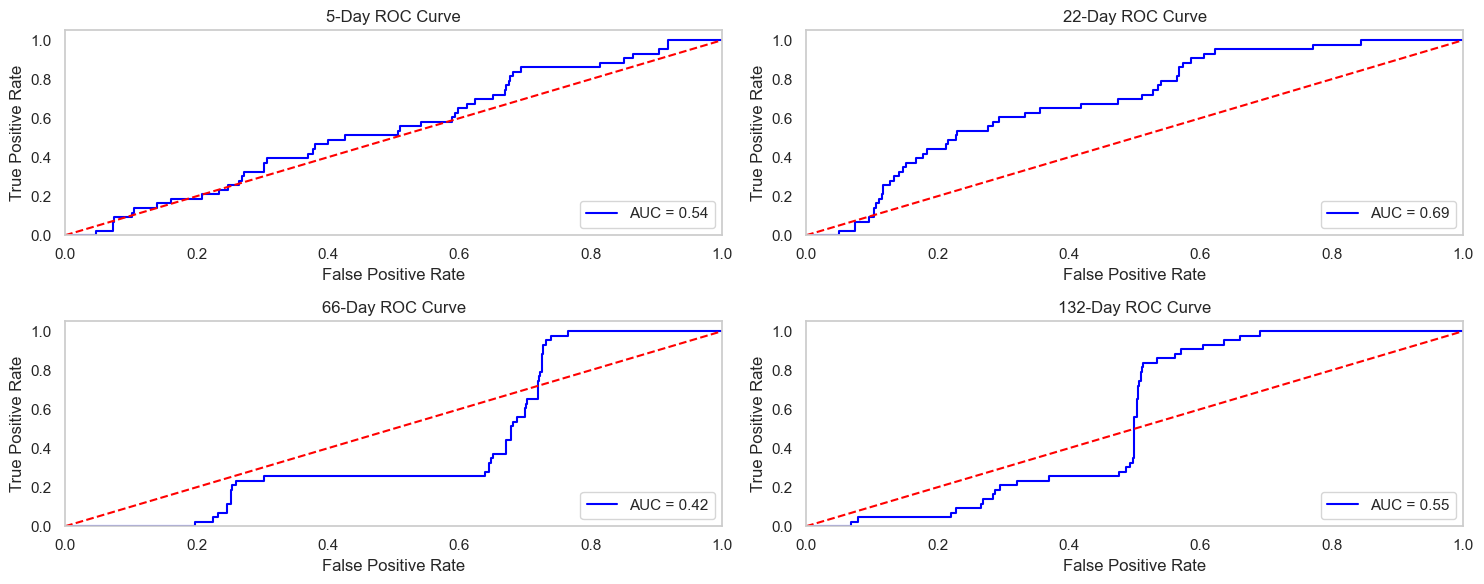

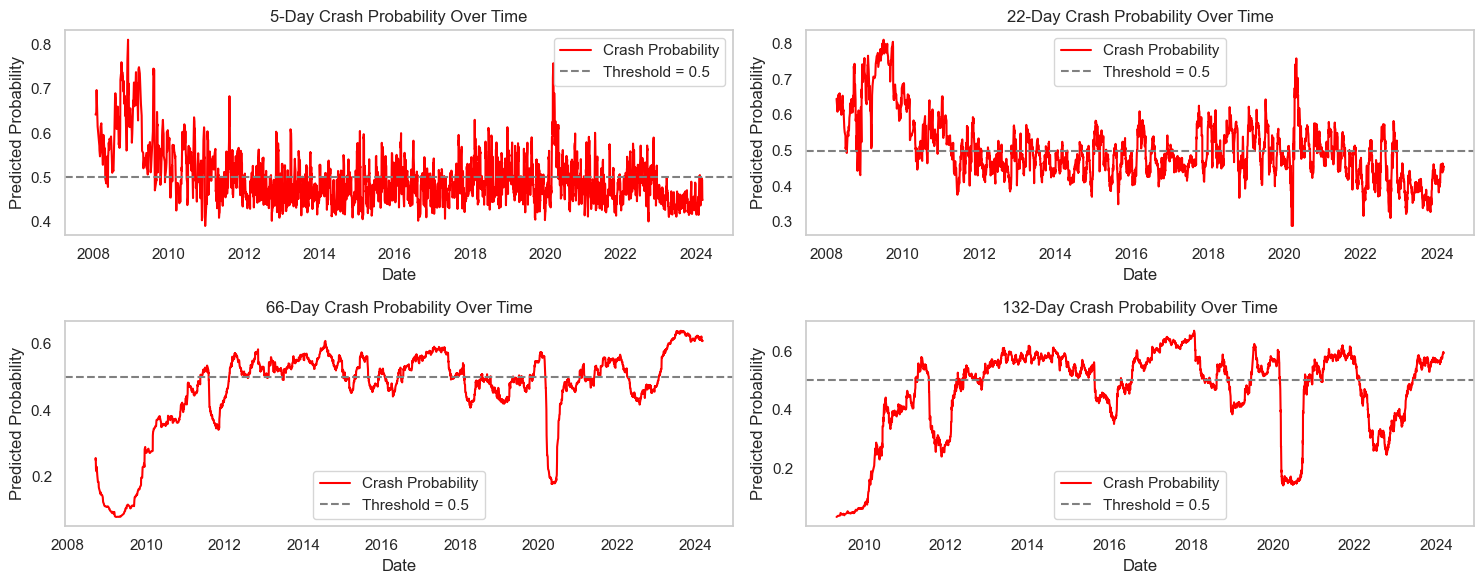

In [378]:
plot_logit_coefficients_grid(static_logit_market)
plot_roc_curves_grid(static_logit_market, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(static_logit_market, market_sentiment_data, target_col='future_crash')

### Static Logit Regression (Sentiment)

In [380]:
static_logit_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_sentiment, X_test_dict, y_test_dict)

all_results.append(static_logit_sentiment)


Best threshold: 0.49, F1: 0.23

=== 5-Day Static Logit Model ===
Test AUC: 0.602
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       495
           1       0.21      0.26      0.23        43

    accuracy                           0.86       538
   macro avg       0.57      0.59      0.58       538
weighted avg       0.88      0.86      0.87       538

Best threshold: 0.43, F1: 0.33

=== 22-Day Static Logit Model ===
Test AUC: 0.814
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       495
           1       0.27      0.44      0.33        43

    accuracy                           0.86       538
   macro avg       0.61      0.67      0.63       538
weighted avg       0.89      0.86      0.87       538

Best threshold: 0.54, F1: 0.16

=== 66-Day Static Logit Model ===
Test AUC: 0.293
Classification Report (Test):
           

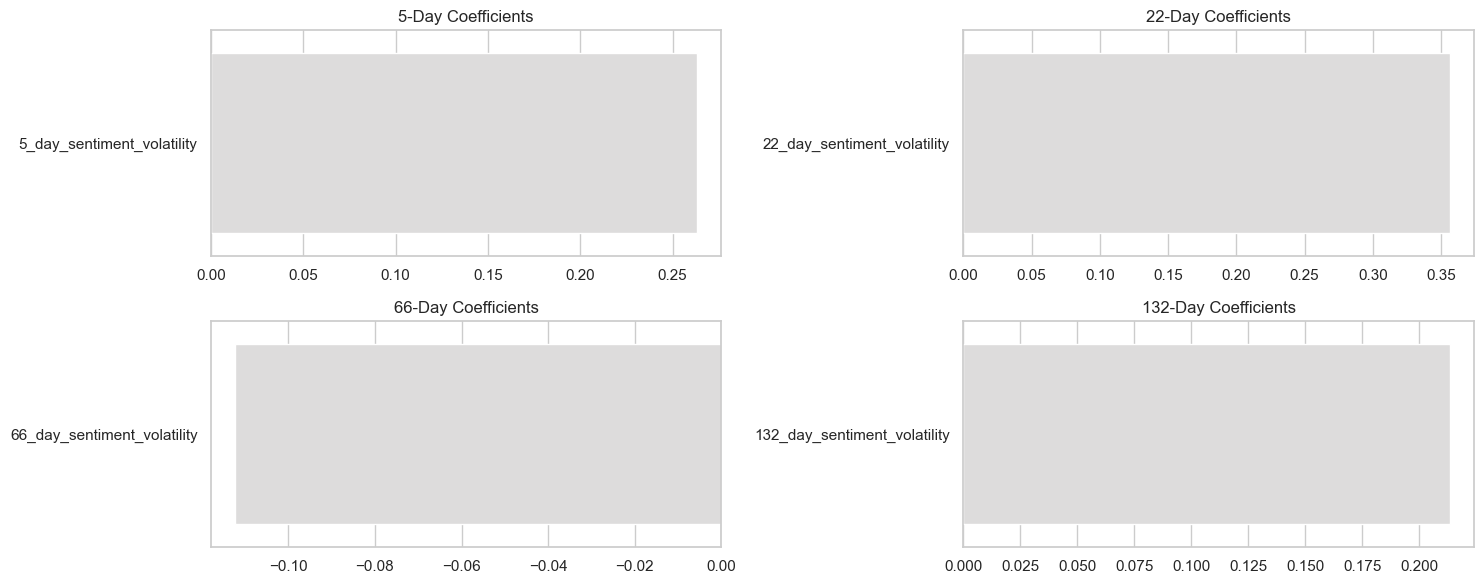

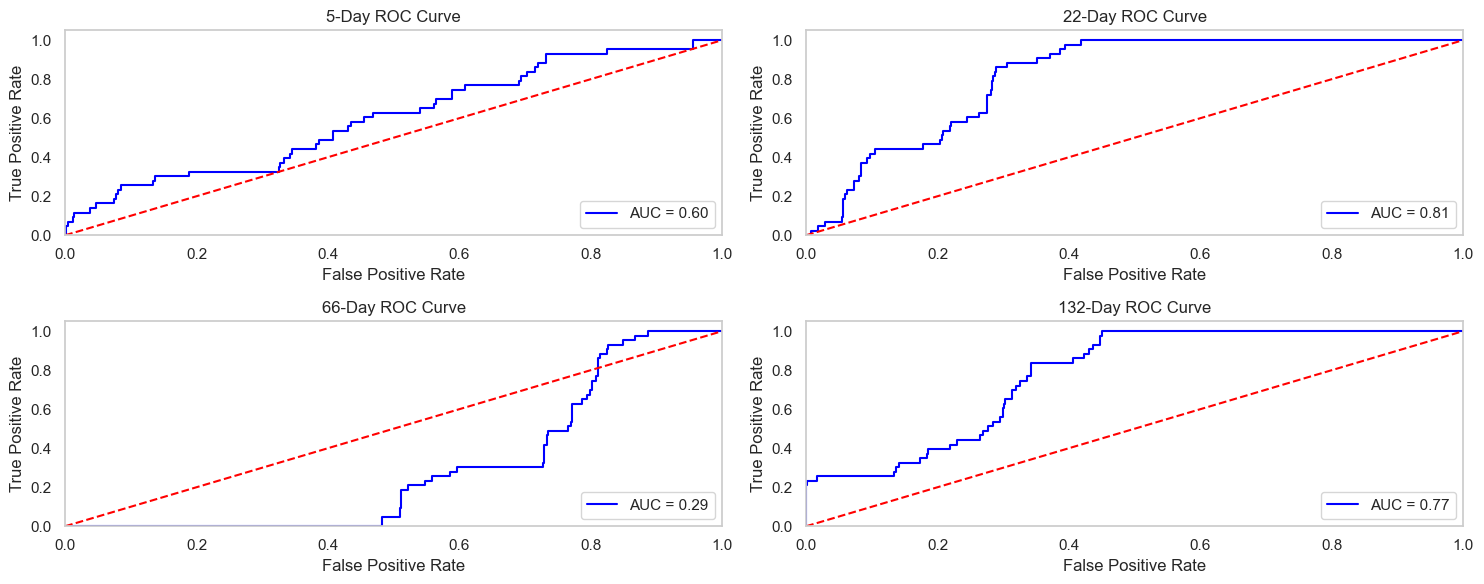

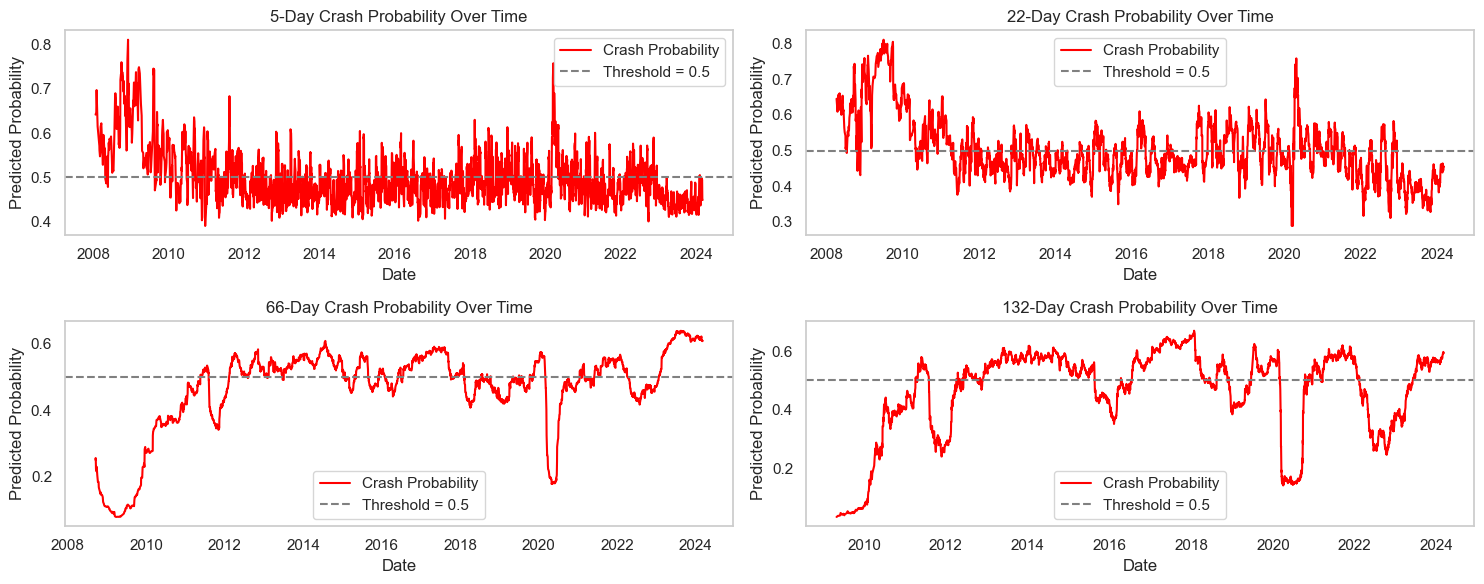

In [381]:
plot_logit_coefficients_grid(static_logit_sentiment)
plot_roc_curves_grid(static_logit_sentiment, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(static_logit_sentiment, market_sentiment_data, target_col='future_crash')

### Static Logit Regression (Market + Sentiment)

In [382]:
static_logit_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_combined, X_test_dict, y_test_dict)

all_results.append(static_logit_combined)

Best threshold: 0.43, F1: 0.21

=== 5-Day Static Logit Model ===
Test AUC: 0.623
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.47      0.63       495
           1       0.12      0.84      0.21        43

    accuracy                           0.50       538
   macro avg       0.55      0.65      0.42       538
weighted avg       0.90      0.50      0.60       538

Best threshold: 0.37, F1: 0.36

=== 22-Day Static Logit Model ===
Test AUC: 0.832
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       495
           1       0.23      0.86      0.36        43

    accuracy                           0.76       538
   macro avg       0.61      0.80      0.61       538
weighted avg       0.92      0.76      0.81       538

Best threshold: 0.30, F1: 0.19

=== 66-Day Static Logit Model ===
Test AUC: 0.405
Classification Report (Test):
           

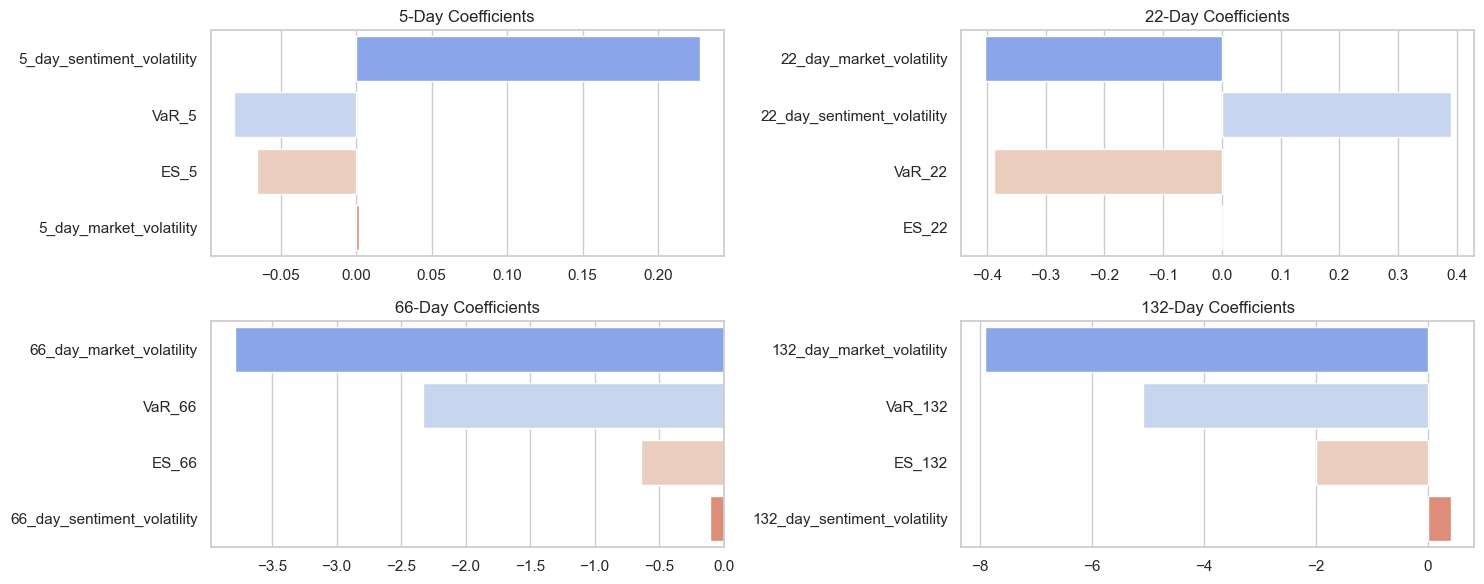

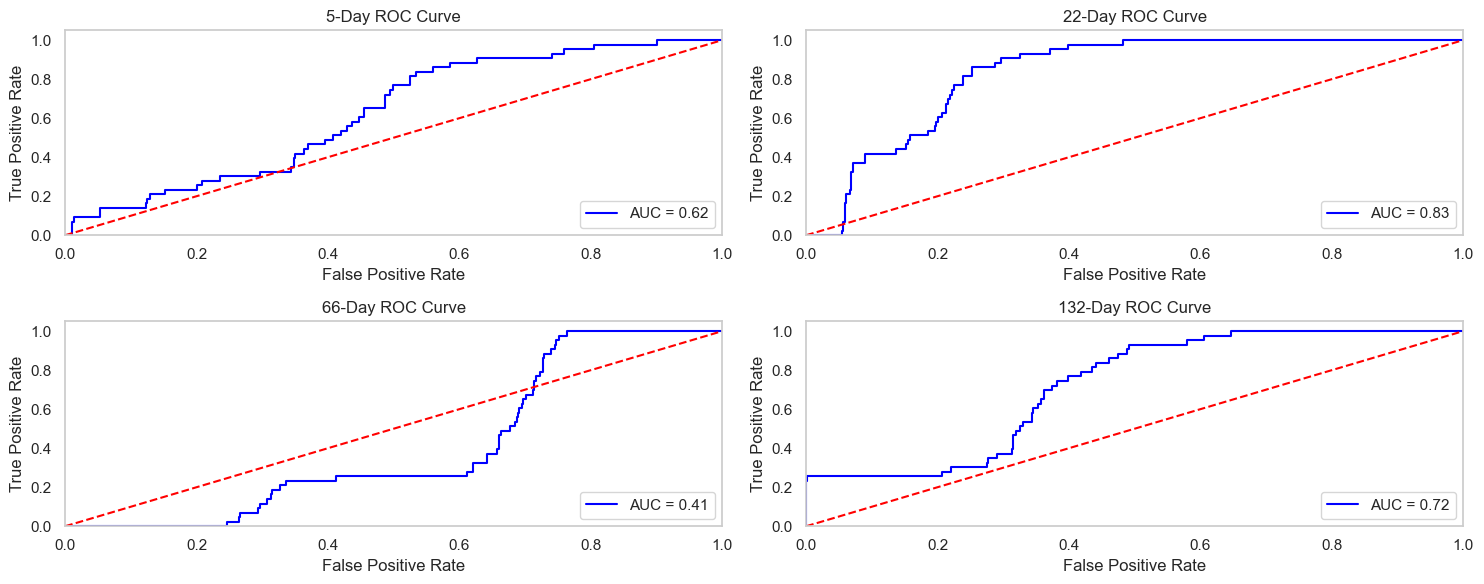

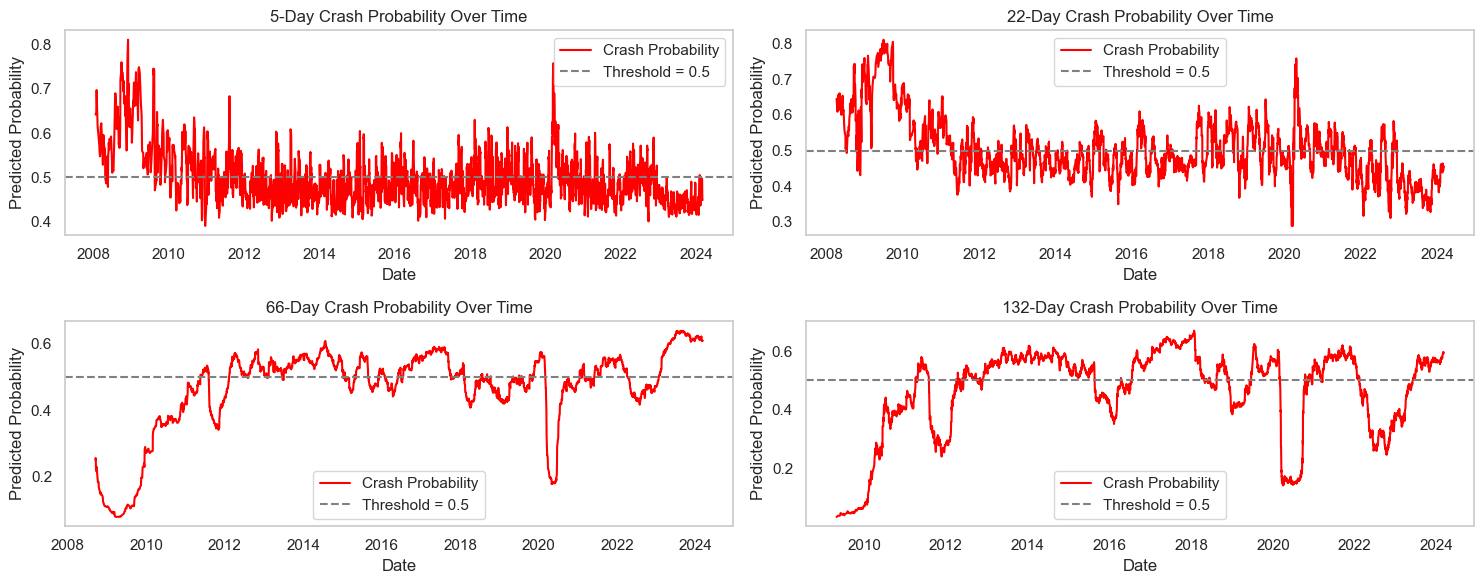

In [383]:
plot_logit_coefficients_grid(static_logit_combined)
plot_roc_curves_grid(static_logit_combined, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(static_logit_combined, market_sentiment_data, target_col='future_crash')

### Static Logit Regression with combined sentiment features

In [314]:
logit_results_comp = {}

# Define combined feature period
combined_period = 0

# Combine 5-day and 22-day features
combined_features = [
    '22_day_market_volatility',
    '22_day_sentiment_volatility',
    'VaR_22',
    'ES_22',
    'avg_sentiment_score_a_day',
]

df_combined = market_sentiment_data.dropna(subset=combined_features + ['future_crash']).copy()
# X = df_combined[combined_features]
# y = df_combined['future_crash']

# # Split and apply SMOTE
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
train_df = train_data.dropna(subset=combined_features+['future_crash']).copy()
test_df = test_data.dropna(subset=combined_features+['future_crash']).copy()

# Prepare feature matrices and target vectors
X_train = train_df[combined_features].fillna(train_df[combined_features].mean())
y_train = train_df['future_crash']

X_test = test_df[combined_features].fillna(train_df[combined_features].mean())
y_test = test_df['future_crash']

X_resampled, y_resampled = X_train.copy(), y_train.copy()

scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test_scale = scaler.transform(X_test)

# Fit logistic regression
logit = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=1000, 
    class_weight='balanced',
    C=1.0,
    l1_ratio=0.5)
logit.fit(X_resampled, y_resampled)

y_proba = logit.predict_proba(X_test_scale)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluation
auc_score = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

coefficients = pd.DataFrame({
    'Feature': combined_features,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

conf = confusion_matrix(y_test, y_pred)

# Store results
logit_results_comp[combined_period] = {
    'model': logit,
    'auc_score': auc_score,
    'report': report,
    'coefficients': coefficients,
    'confusion': conf,
}

X_test_dict[combined_period] = X_test
y_test_dict[combined_period] = y_test

# Print summary
print(f"\n=== Combined Logit Model ===")
print(f"AUC: {auc_score:.3f}")
print("Classification Report:")
print(report)


=== Combined Logit Model ===
AUC: 0.808
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       495
           1       0.06      0.02      0.03        43

    accuracy                           0.89       538
   macro avg       0.49      0.49      0.49       538
weighted avg       0.85      0.89      0.87       538



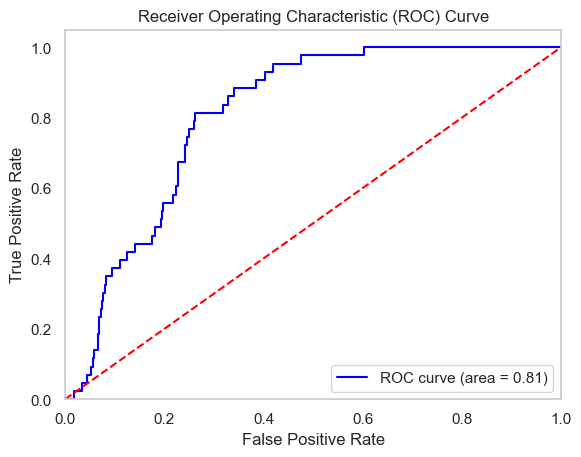

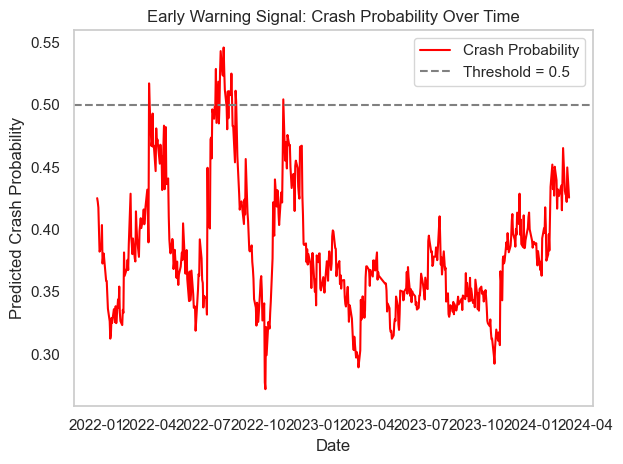

In [315]:
# Create DataFrame with dates and probabilities
dates = df_combined.loc[X_test.index, 'Date']
prob_df = pd.DataFrame({
    'Date': dates,
    'crash_probability': y_proba
}).sort_values('Date')

# Plot ROC curve
plot_roc_curve(y_test, y_proba)

# Plot crash probabilities
plot_crash_probabilities(prob_df, target_col='crash_probability')

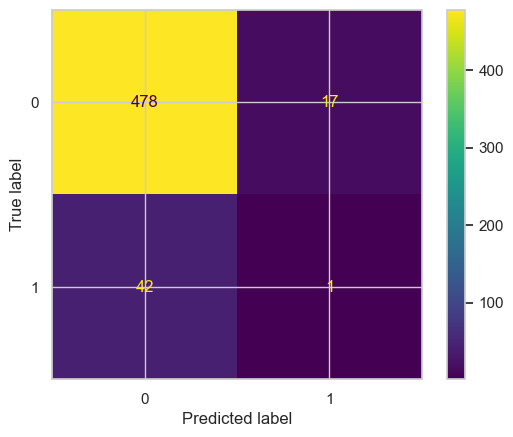

In [316]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit.classes_)
disp.plot()

## Dynamic Logit Regression

In [392]:
def dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit, X_test_dict, y_test_dict, lag=10):
    market_sentiment_data_with_lags = market_sentiment_data.copy()

    for n in volatility_period:
        # Base features
        feature_cols = [
            f'{n}_day_market_volatility',
            f'{n}_day_sentiment_volatility',
            f'VaR_{n}',
            f'ES_{n}',
            # f'avg_sentiment_score_a_day',
        ]

        # Add lagged features
        for feat in feature_cols:
            market_sentiment_data_with_lags[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

        feature_cols = feature_cols + [f'{f}_lag{lag}' for f in feature_cols]

        train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
        test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
        train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
        test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

        # Prepare feature matrices and target vectors
        X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
        y_train = train_df['future_crash']

        X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
        y_test = test_df['future_crash']
        
        # Oversample
        X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
        # X_resampled, y_resampled = X_train.copy(), y_train.copy()

        scaler = StandardScaler()
        X_resampled = scaler.fit_transform(X_resampled)
        X_test = scaler.transform(X_test)

        # Fit logistic regression
        logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
        logit.fit(X_resampled, y_resampled)

        # Predict
        y_proba = logit.predict_proba(X_test)[:, 1]
        best_thresh = dynamic_threshold_calculate(y_test, y_proba)
        y_pred = (y_proba >= best_thresh).astype(int)
        # y_pred = logit.predict(X_test)
        
        # Save results
        auc_score = roc_auc_score(y_test, y_proba)
        report = classification_report(y_test, y_pred, output_dict=True)
        conf = confusion_matrix(y_test, y_pred)

        coefficients = pd.DataFrame({
            'Feature': feature_cols,
            'Coefficient': logit.coef_[0]
        }).sort_values(by='Coefficient', key=abs, ascending=False)

        dynamic_logit[n] = {
            'model': logit,
            'auc_score': auc_score,
            'report': report,
            'coefficients': coefficients,
            'confusion': conf,
        }

        X_test_dict[n] = X_test
        y_test_dict[n] = y_test

        print(f"\n=== {n}-Day Logit Model with Lag {lag} ===")
        print(f"AUC: {auc_score:.3f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

### Dynamic Logit Regression (Market)

In [393]:
dynamic_logit_market = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_market, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_market)

Best threshold: 0.44, F1: 0.27

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.710
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       495
           1       0.17      0.72      0.27        43

    accuracy                           0.69       538
   macro avg       0.57      0.70      0.54       538
weighted avg       0.90      0.69      0.76       538

Best threshold: 0.42, F1: 0.41

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.828
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       495
           1       0.31      0.60      0.41        43

    accuracy                           0.86       538
   macro avg       0.64      0.74      0.67       538
weighted avg       0.91      0.86      0.88       538

Best threshold: 0.14, F1: 0.16

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.364
Classification Report:
              precision    recal

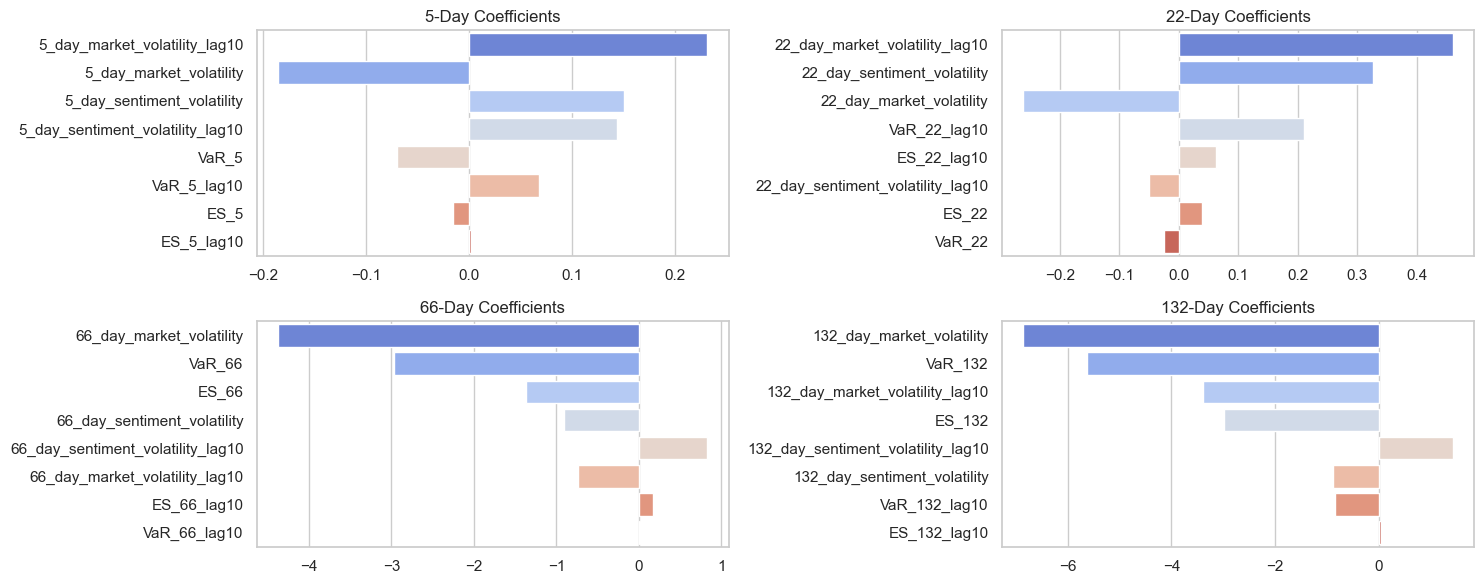

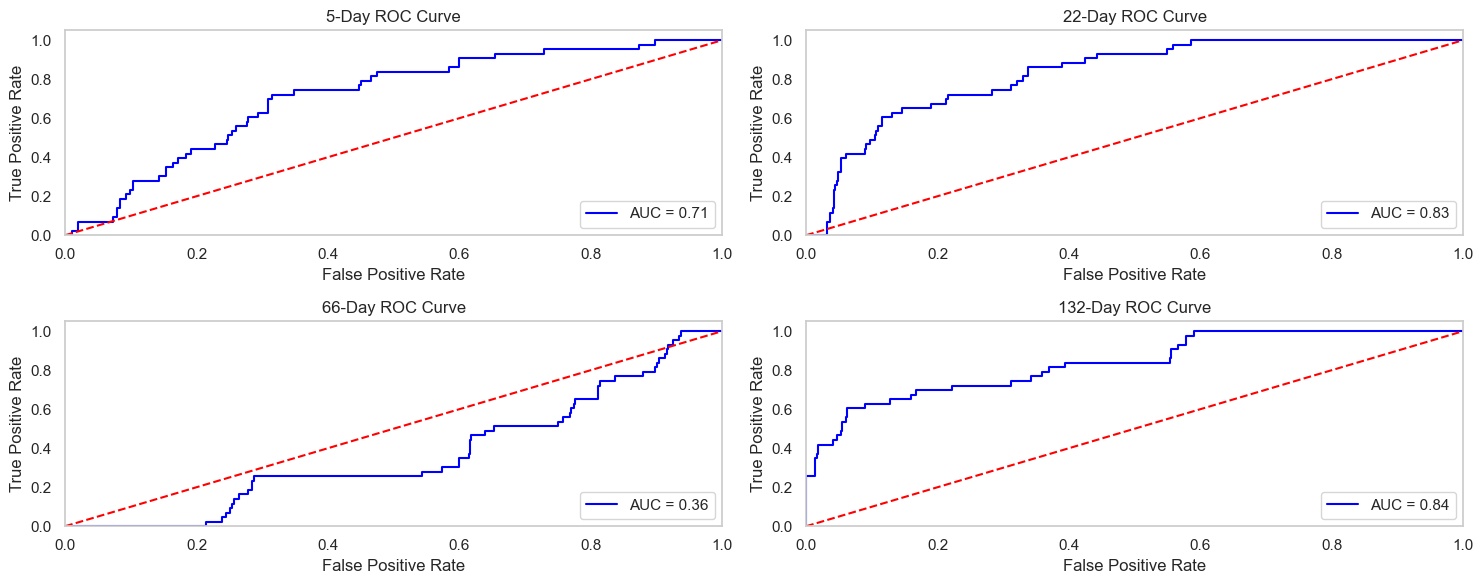

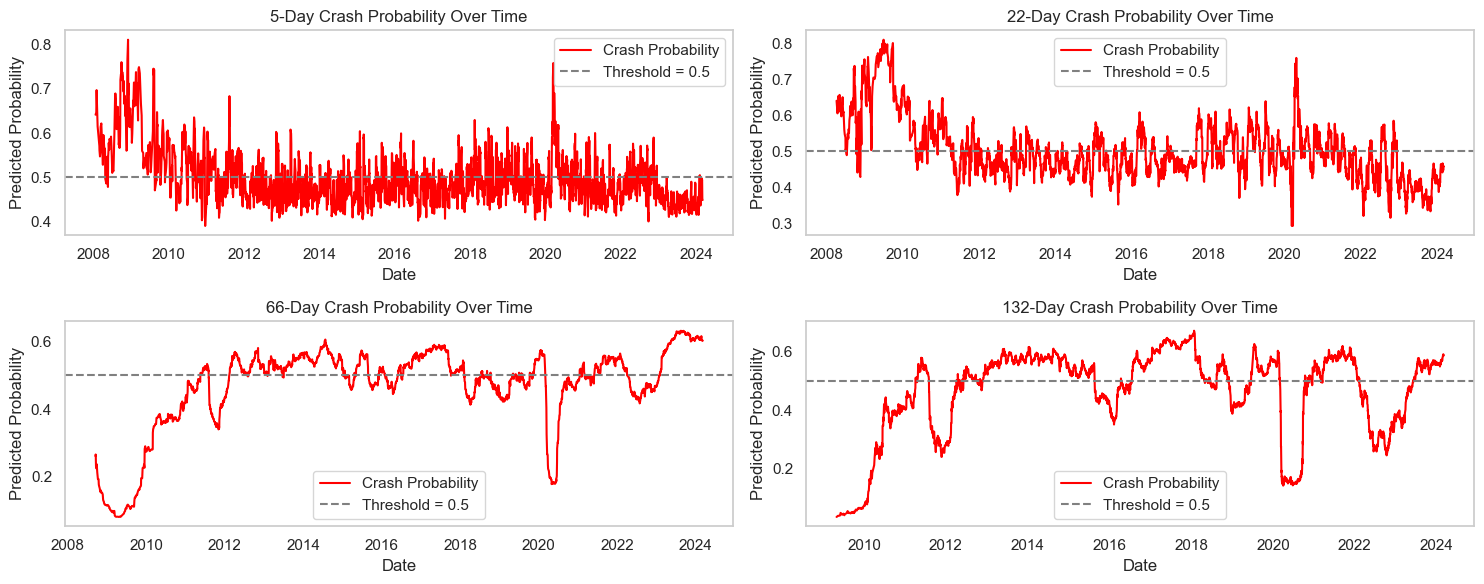

In [394]:
plot_logit_coefficients_grid(dynamic_logit_market)
plot_roc_curves_grid(dynamic_logit_market, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(dynamic_logit_market, market_sentiment_data, target_col='future_crash')

### Dynamic Logit Regression (Sentiment)

In [395]:
dynamic_logit_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_sentiment, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_sentiment)

Best threshold: 0.44, F1: 0.27

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.710
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       495
           1       0.17      0.72      0.27        43

    accuracy                           0.69       538
   macro avg       0.57      0.70      0.54       538
weighted avg       0.90      0.69      0.76       538

Best threshold: 0.42, F1: 0.41

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.828
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       495
           1       0.31      0.60      0.41        43

    accuracy                           0.86       538
   macro avg       0.64      0.74      0.67       538
weighted avg       0.91      0.86      0.88       538

Best threshold: 0.14, F1: 0.16

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.364
Classification Report:
              precision    recal

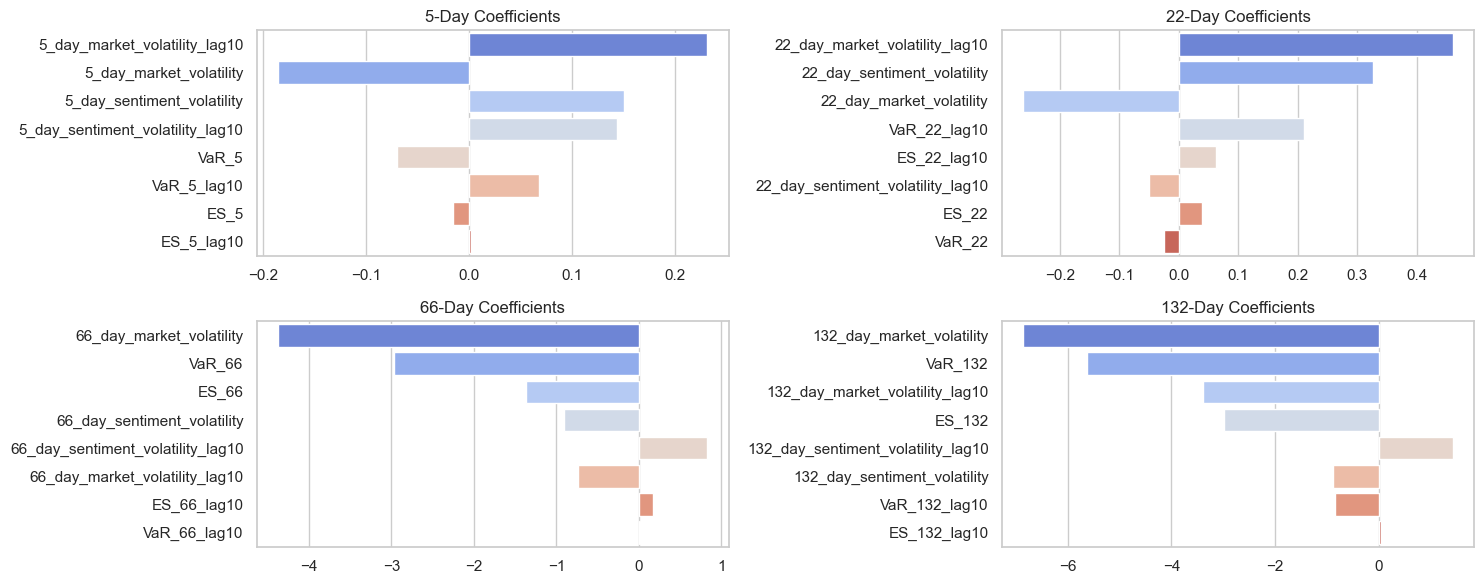

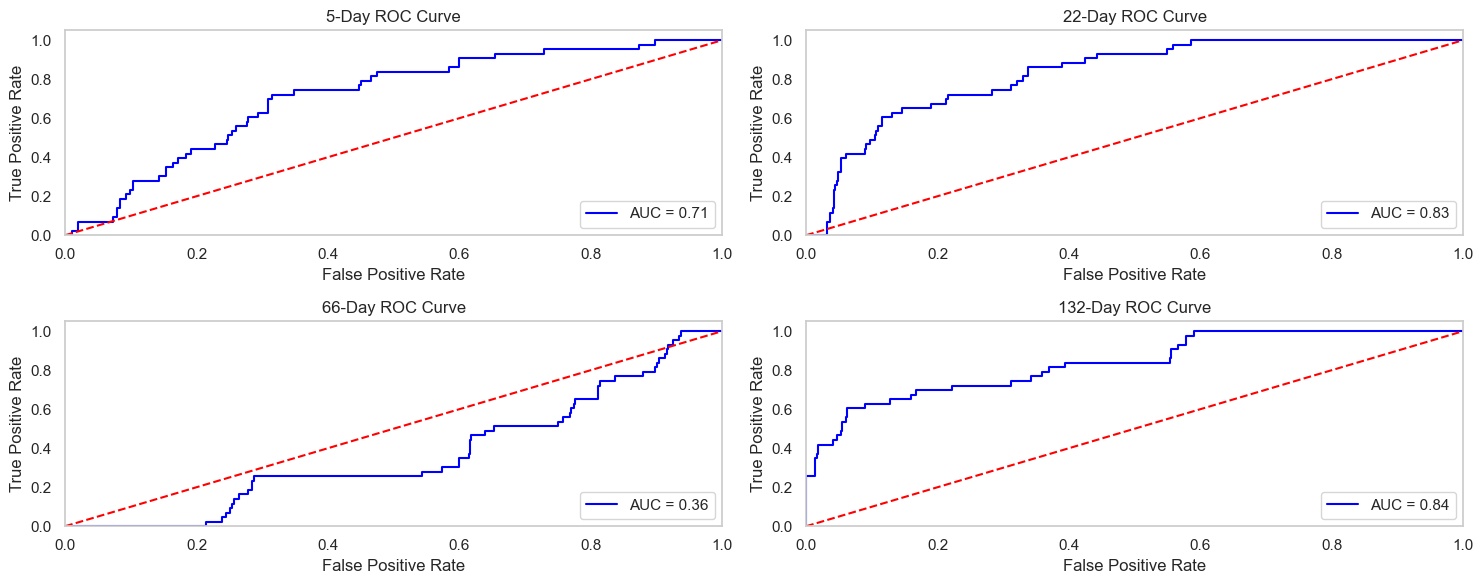

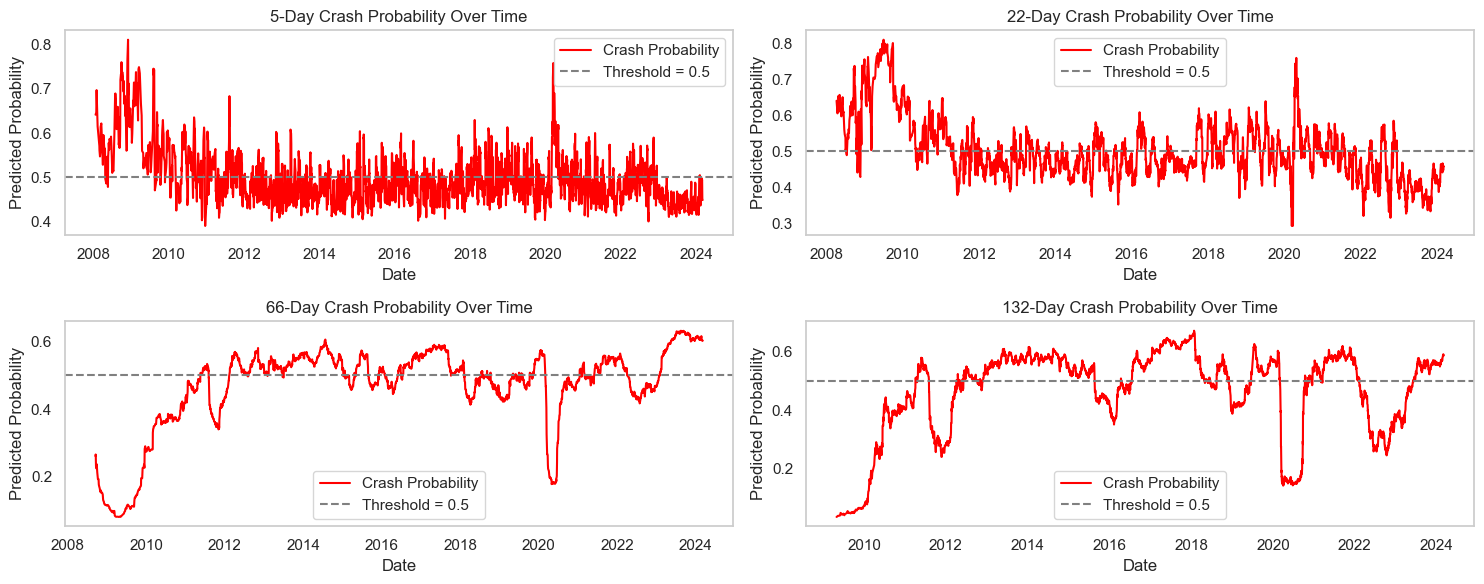

In [396]:
plot_logit_coefficients_grid(dynamic_logit_sentiment)
plot_roc_curves_grid(dynamic_logit_sentiment, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(dynamic_logit_sentiment, market_sentiment_data, target_col='future_crash')

### Dynamic Logit Regression (Market + Sentiment)

In [397]:
dynamic_logit_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_combined, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_combined)

Best threshold: 0.44, F1: 0.27

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.710
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       495
           1       0.17      0.72      0.27        43

    accuracy                           0.69       538
   macro avg       0.57      0.70      0.54       538
weighted avg       0.90      0.69      0.76       538

Best threshold: 0.42, F1: 0.41

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.828
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       495
           1       0.31      0.60      0.41        43

    accuracy                           0.86       538
   macro avg       0.64      0.74      0.67       538
weighted avg       0.91      0.86      0.88       538

Best threshold: 0.14, F1: 0.16

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.364
Classification Report:
              precision    recal

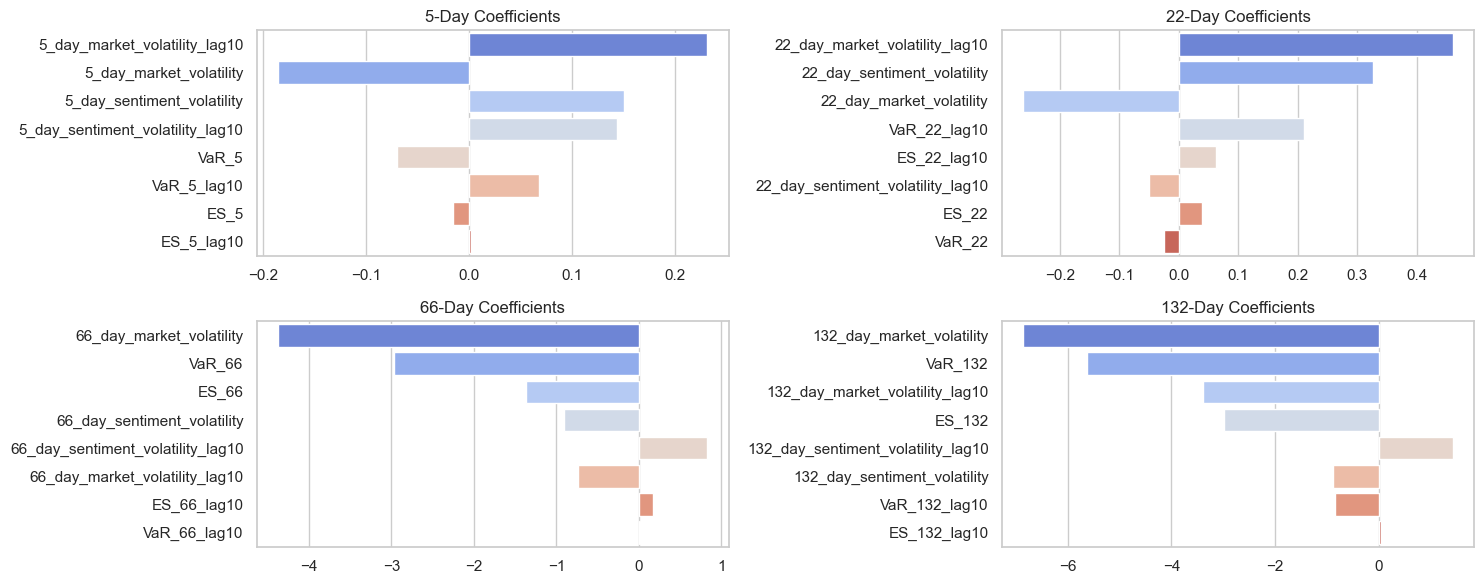

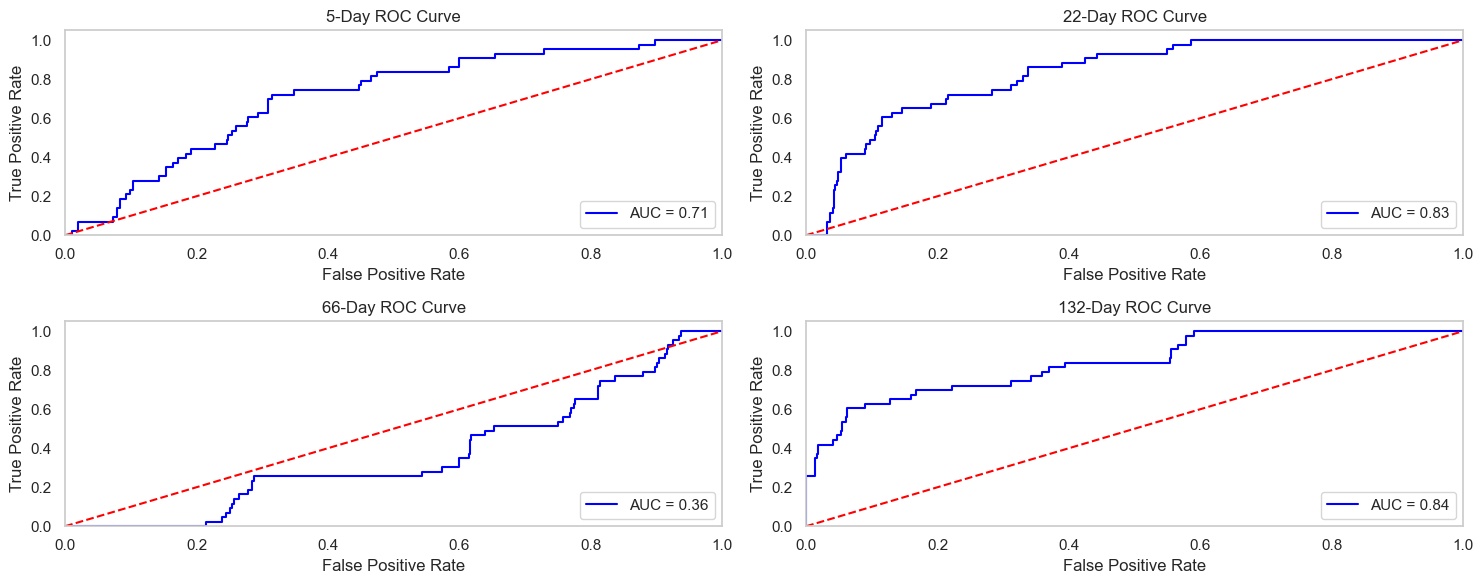

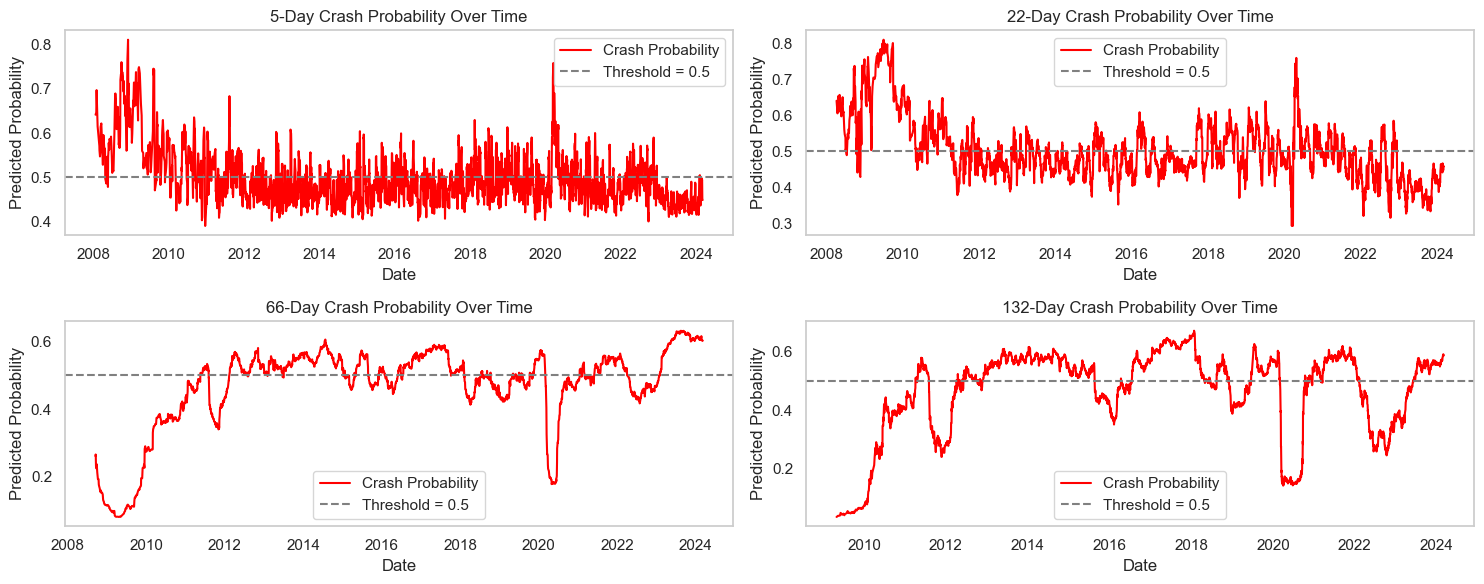

In [398]:
plot_logit_coefficients_grid(dynamic_logit_combined)
plot_roc_curves_grid(dynamic_logit_combined, X_test_dict, y_test_dict)
plot_crash_probabilities_grid(dynamic_logit_combined, market_sentiment_data, target_col='future_crash')

### Dynamic Logit Regression with Combined Features and Dynamic Threshold

In [327]:
# Define combined feature period
combined_period = 1
lag = 10

# Combine 5-day and 22-day features
combined_features = [
    # f'5_day_market_volatility',
    # f'5_day_sentiment_volatility',
    f'22_day_sentiment_volatility',
    f'22_day_market_volatility',
    f'VaR_22',
    f'ES_22',
    # f'avg_sentiment_score_a_day',
]

market_sentiment_data_with_lags = market_sentiment_data.copy()

# Add lagged features
for feat in combined_features:
    market_sentiment_data_with_lags[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

feature_cols = combined_features + [f'{f}_lag{lag}' for f in combined_features]

train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

# Prepare feature matrices and target vectors
X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
y_train = train_df['future_crash']

X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
y_test = test_df['future_crash']

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test_scale = scaler.transform(X_test)

# Fit logistic regression
logit = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=1000, 
    class_weight='balanced',
    C=1.0,
    l1_ratio=0.5)
logit.fit(X_resampled, y_resampled)

y_proba = logit.predict_proba(X_test_scale)[:, 1]
best_thresh = dynamic_threshold_calculate(y_test, y_proba)
y_pred = (y_proba >= best_thresh).astype(int)

# Evaluation
auc_score = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)

coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Store results
logit_results_comp[combined_period] = {
    'model': logit,
    'auc_score': auc_score,
    'report': report,
    'coefficients': coefficients,
    'confusion': conf,
}

X_test_dict[combined_period] = X_test
y_test_dict[combined_period] = y_test

# Print summary
print(f"\n=== Combined Logit Model ===")
print(f"AUC: {auc_score:.3f}")
print("Classification Report:")
print(report)

Best threshold: 0.42, F1: 0.41

=== Combined Logit Model ===
AUC: 0.828
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       495
           1       0.31      0.60      0.41        43

    accuracy                           0.86       538
   macro avg       0.64      0.74      0.67       538
weighted avg       0.91      0.86      0.88       538



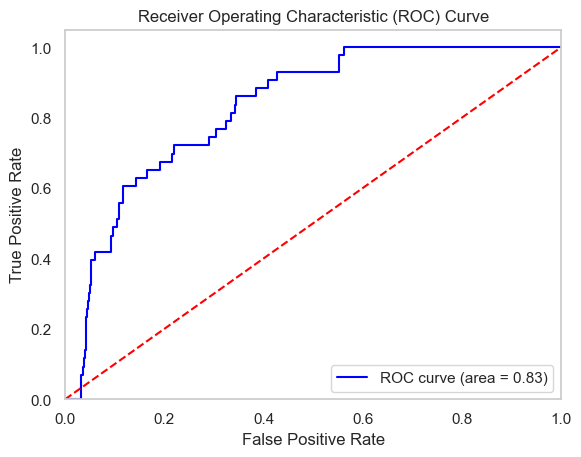

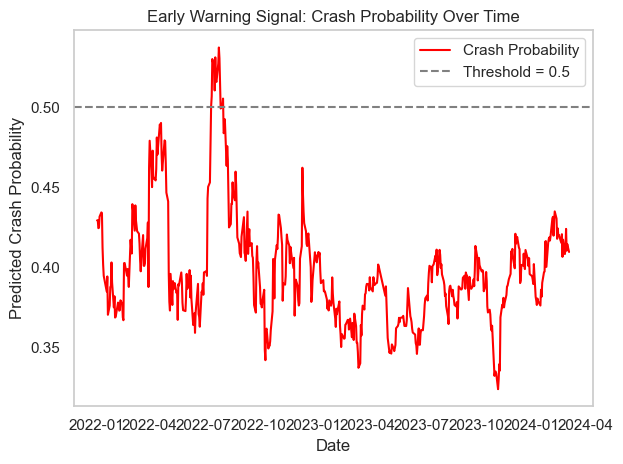

In [328]:
# Create DataFrame with dates and probabilities
dates = df_combined.loc[X_test.index, 'Date']
prob_df = pd.DataFrame({
    'Date': dates,
    'crash_probability': y_proba
}).sort_values('Date')

# Plot ROC curve
plot_roc_curve(y_test, y_proba)

# Plot crash probabilities
plot_crash_probabilities(prob_df, target_col='crash_probability')

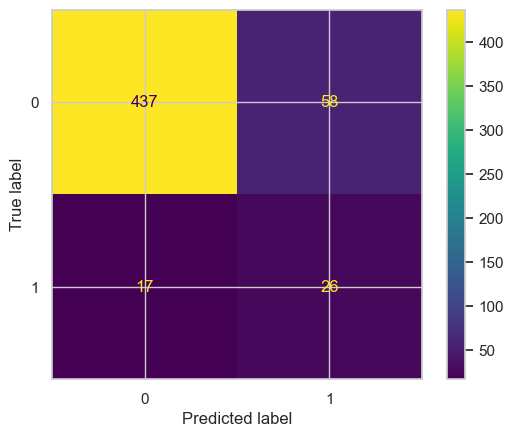

In [259]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit.classes_)
disp.plot()

In [260]:
# Compare static and dynamic model (n = 0, 1)
print(logit_results_comp[0]['confusion'])
print(logit_results_comp[1]['confusion'])

[[483  12]
 [ 43   0]]
[[437  58]
 [ 17  26]]


In [261]:
print(logit_results_comp[0]['report'])
print(logit_results_comp[1]['report'])

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       495
           1       0.00      0.00      0.00        43

    accuracy                           0.90       538
   macro avg       0.46      0.49      0.47       538
weighted avg       0.84      0.90      0.87       538

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       495
           1       0.31      0.60      0.41        43

    accuracy                           0.86       538
   macro avg       0.64      0.74      0.67       538
weighted avg       0.91      0.86      0.88       538



## CNN

In [449]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.utils import class_weight

def cnn_model(n, feature_cols, market_sentiment_data, cnn_results, X_test_dict, y_test_dict, lag=10, window_size=10):
    market_sentiment_data_with_lags = market_sentiment_data.copy()

    # # Add lagged features
    # for feat in feature_cols:
    #     market_sentiment_data_with_lags[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

    # feature_cols = feature_cols + [f'{f}_lag{lag}' for f in feature_cols]    

    train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
    test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']
    X_train_raw = X_train.values
    y_train_raw = y_train.values

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    X_test_raw = X_test.values
    y_test_raw = y_test.values

    # X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

    # Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_raw)

    X_train_seq, y_train_seq, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
    X_test_seq, y_test_seq, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)

    # Define CNN model
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_seq),
        y=y_train_seq
    )
    class_weight_dict = dict(enumerate(class_weights_array))

    # Train
    cnn_model.fit(X_train_seq, y_train_seq, epochs=15, batch_size=32, validation_split=0.2, verbose=0, 
                class_weight=class_weight_dict)

    y_prob = cnn_model.predict(X_test_seq).flatten()
    best_threshold = dynamic_threshold_calculate(y_test_seq, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc = roc_auc_score(y_test_seq, y_prob)
    report = classification_report(y_test_seq, y_pred, output_dict=True)
    conf = confusion_matrix(y_test_seq, y_pred)

    # Save model and results
    cnn_results[n] = {
        'model': cnn_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test_seq,
        'y_prob': y_prob,
        'features': feature_cols,
        'confusion': conf,
    }

    X_test_dict[n] = X_test_seq
    y_test_dict[n] = y_test_seq

    print(f"\n=== {n}-Day CNN Model ===")
    print(f"AUC: {auc:.3f}")
    print(classification_report(y_test_seq, y_pred))

In [450]:
lag = 10
feature_cols = [
    f'5_day_market_volatility',
    f'5_day_sentiment_volatility',
    f'22_day_market_volatility',
    f'22_day_sentiment_volatility',
    f'VaR_5',
    f'ES_5',
    f'VaR_22',
    f'ES_22',
    f'66_day_market_volatility',
    f'66_day_sentiment_volatility',
    f'VaR_66',
    f'ES_66',
    f'132_day_market_volatility',
    f'132_day_sentiment_volatility',
    f'VaR_132',
    f'ES_132',
]
market_sentiment_data_with_lag10 = market_sentiment_data.copy()

# Add lagged features
# for feat in feature_cols:
#     market_sentiment_data_with_lag10[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

### CNN (Market)

In [451]:
cnn_market = {}
X_test_dict = {}
y_test_dict = {}
window_size = 10  # Default window size for CNN

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_market, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_market)    

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best threshold: 0.24, F1: 0.16

=== 5-Day CNN Model ===
AUC: 0.575
              precision    recall  f1-score   support

           0       0.99      0.34      0.51       495
           1       0.09      0.94      0.16        33

    accuracy                           0.38       528
   macro avg       0.54      0.64      0.33       528
weighted avg       0.93      0.38      0.49       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.55, F1: 0.27

=== 22-Day CNN Model ===
AUC: 0.757
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       495
           1       0.16      0.73      0.27        33

    accuracy                           0.75       528
   macro avg       0.57      0.74      0.56       528
weighted avg       0.93      0.75      0.81       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.01, F1: 0.17

=== 66-Day CNN Model ===
AUC: 0.395
              precision   

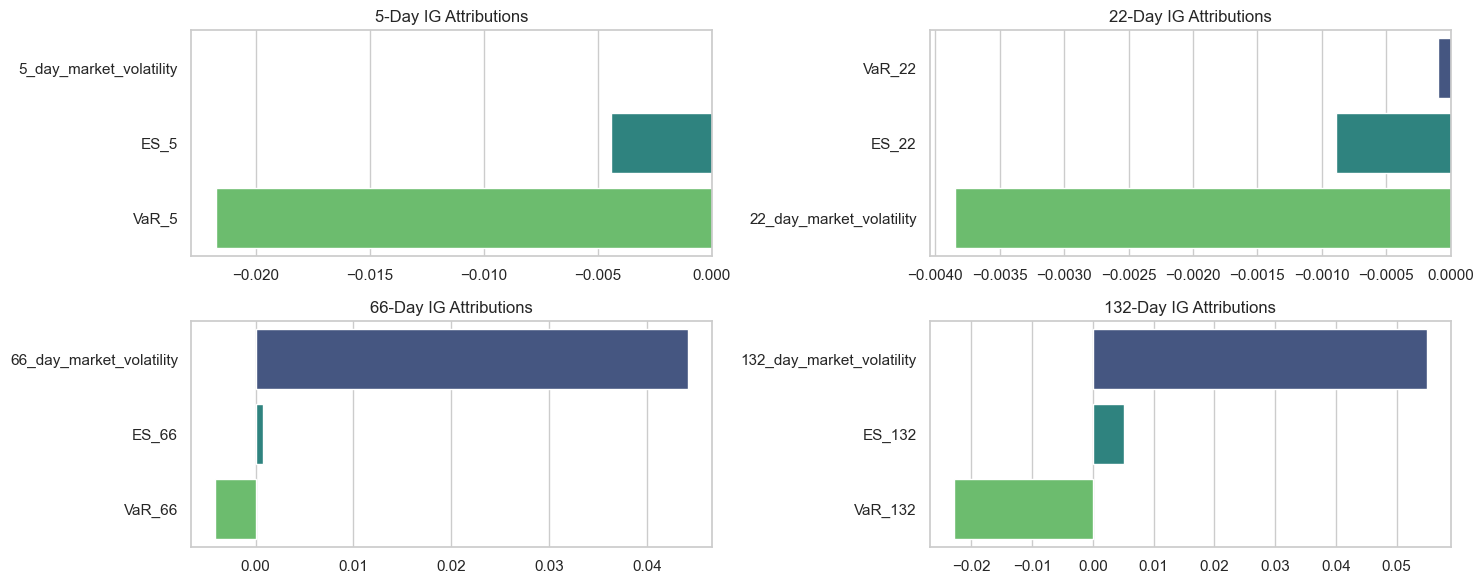

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


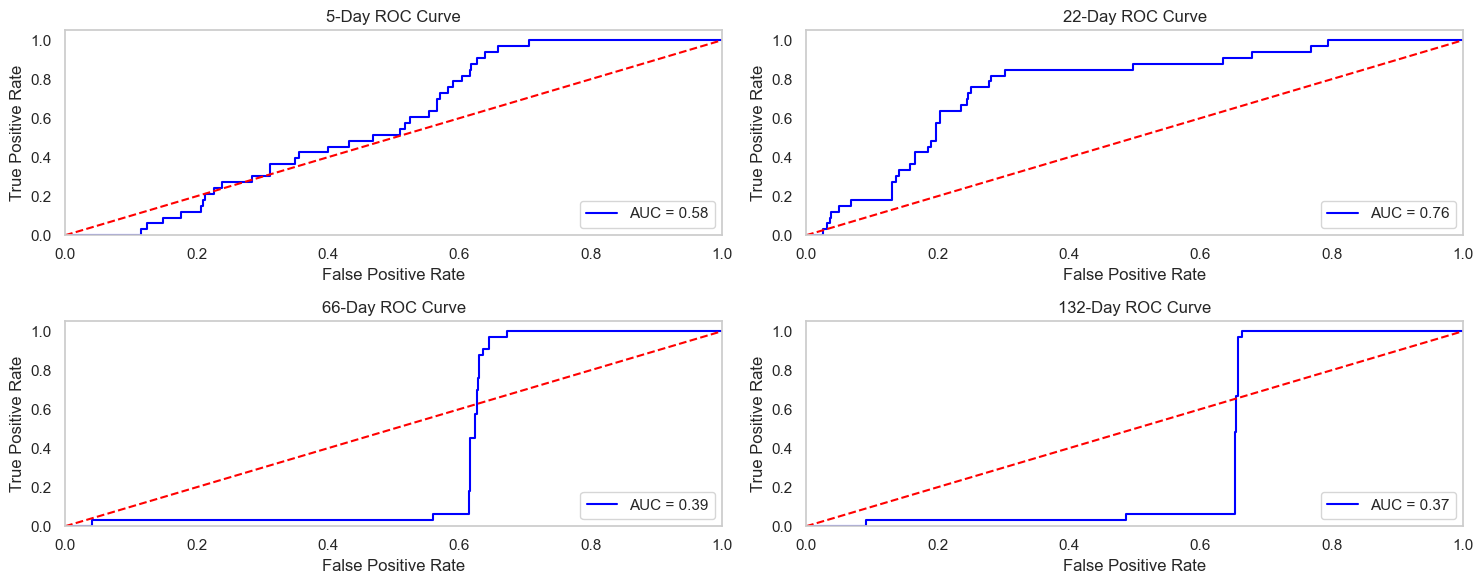

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


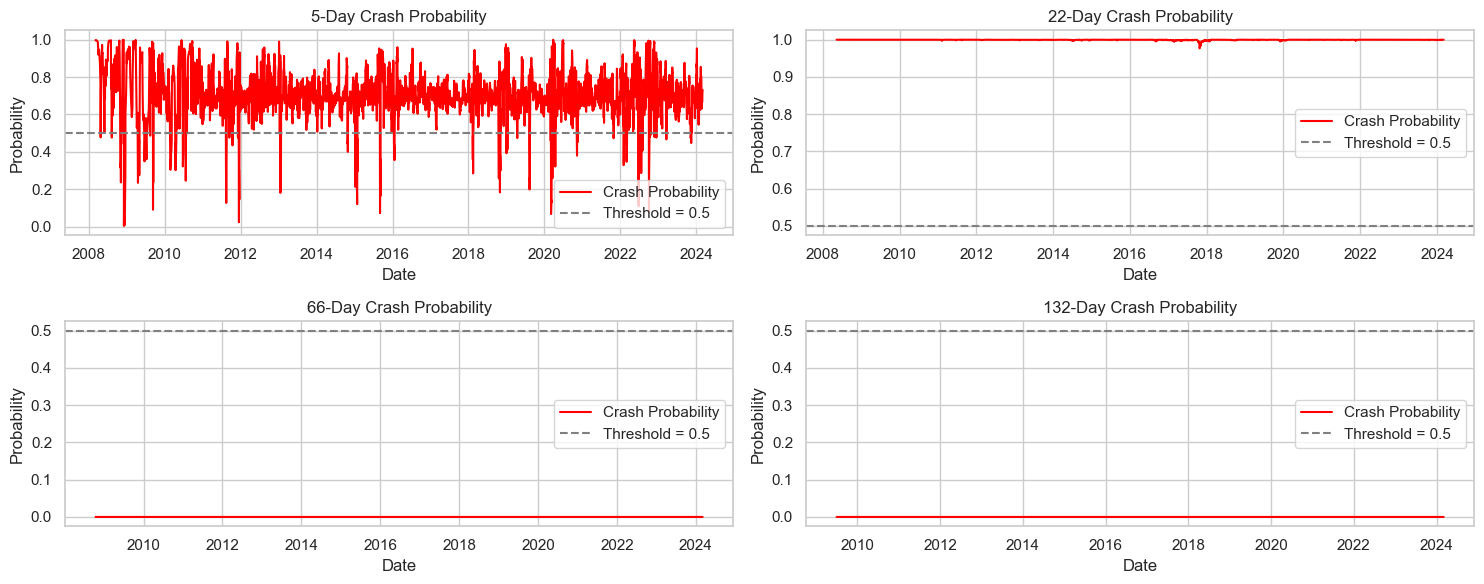

In [452]:
plot_ig_feature_attributions_grid(cnn_market, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(cnn_market, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(cnn_market, market_sentiment_data_with_lag10, lag=10, window_size=window_size)

### CNN (Sentiment)

In [453]:
cnn_sentiment = {}
X_test_dict = {}
y_test_dict = {}
window_size = 10  # Default window size for CNN

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_sentiment, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_sentiment)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.00, F1: 0.24

=== 5-Day CNN Model ===
AUC: 0.664
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       495
           1       0.15      0.45      0.23        33

    accuracy                           0.81       528
   macro avg       0.56      0.64      0.56       528
weighted avg       0.91      0.81      0.85       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.02, F1: 0.33

=== 22-Day CNN Model ===
AUC: 0.843
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       495
           1       0.20      0.94      0.32        33

    accuracy                           0.76       528
   macro avg       0.60      0.84      0.59       528
weighted avg       0.94      0.76      0.82       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.00, F1: 0.20

=== 66-Day CNN Model ===
AUC: 0.651
              precision   

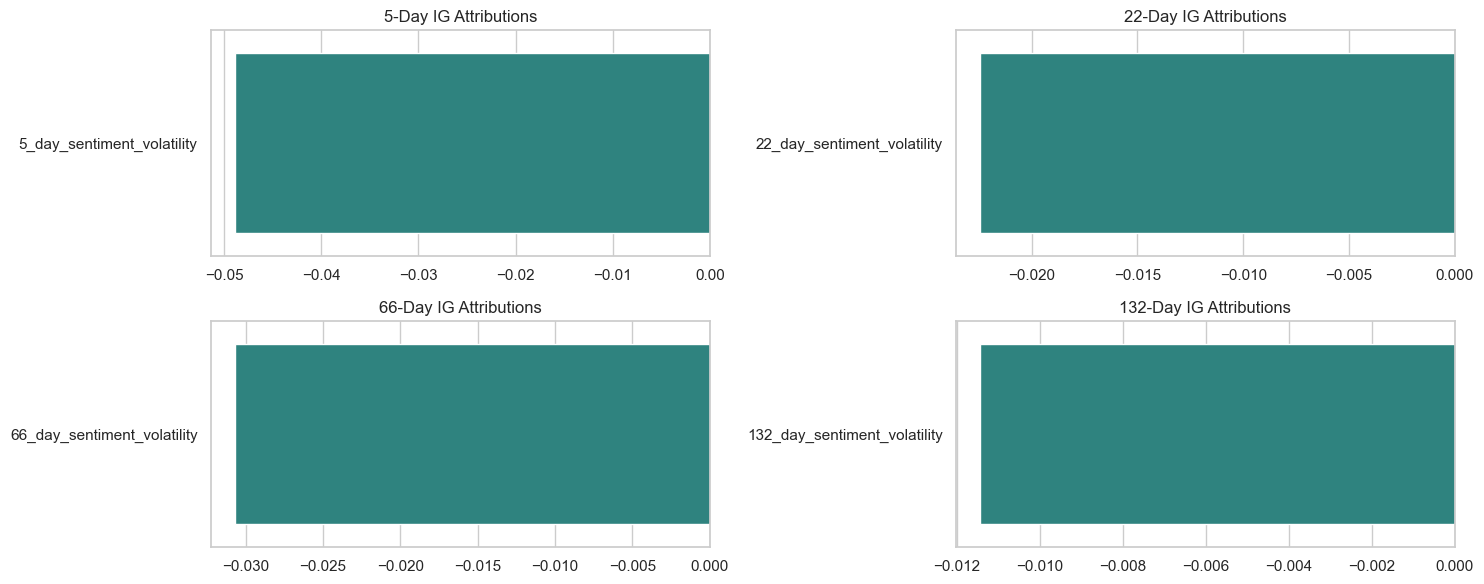

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


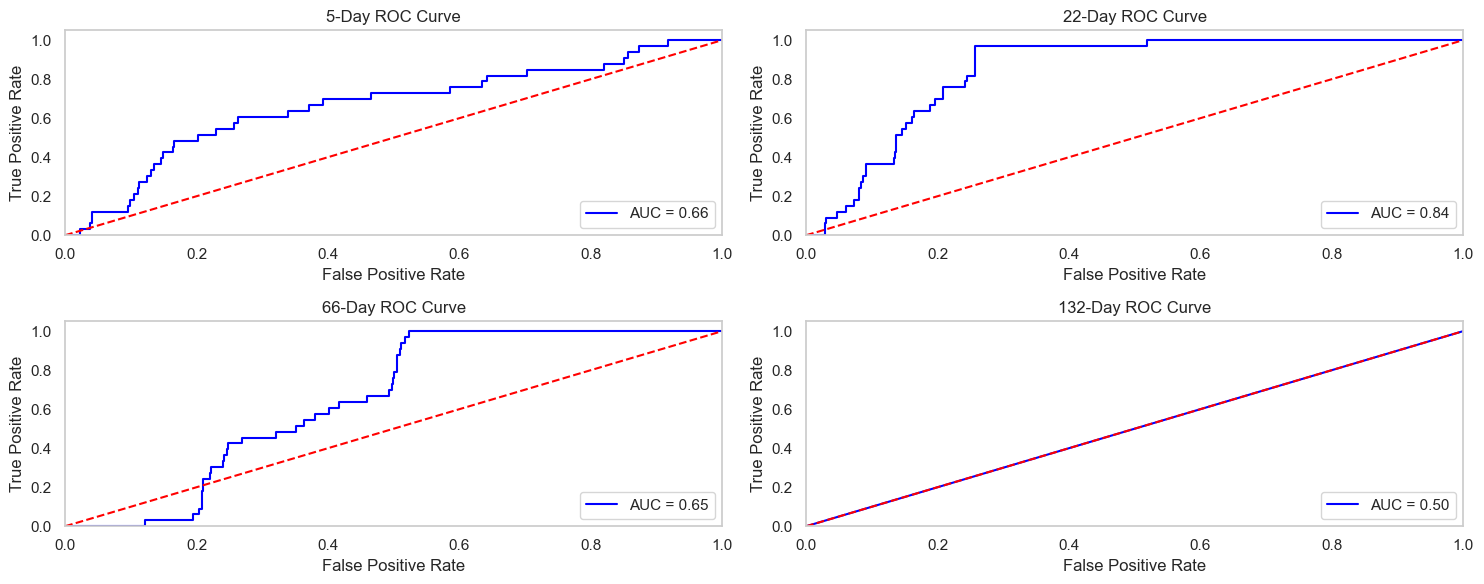

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


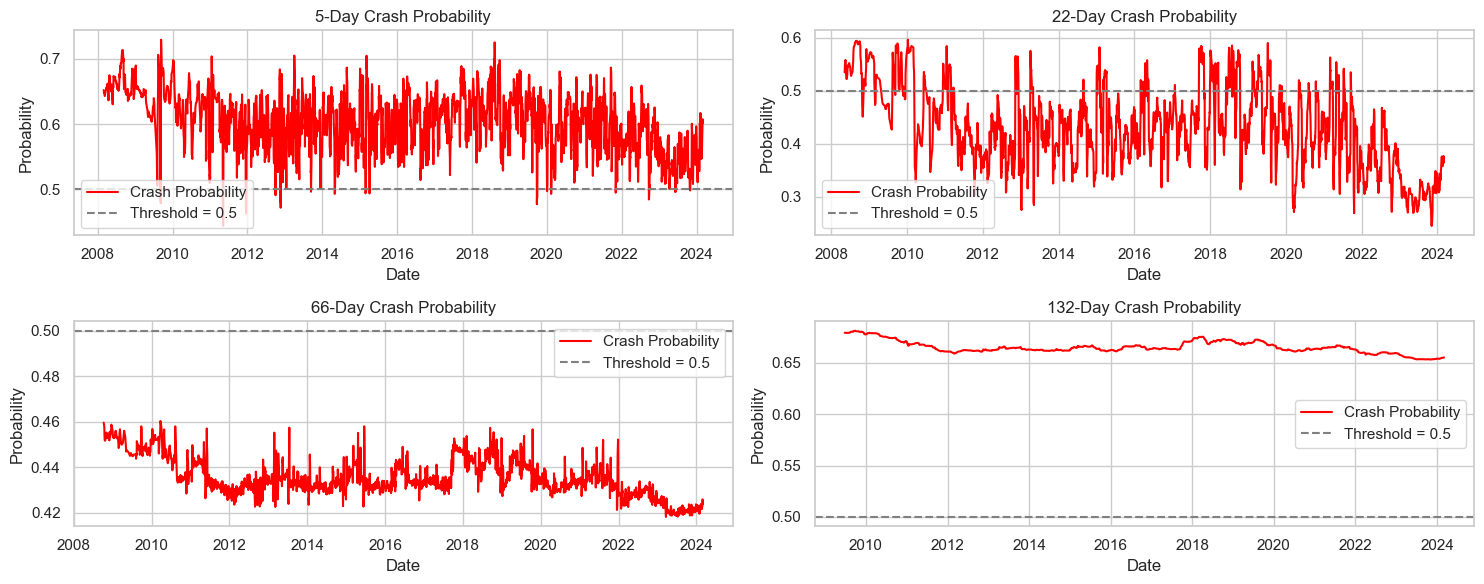

In [454]:
plot_ig_feature_attributions_grid(cnn_sentiment, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(cnn_sentiment, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(cnn_sentiment, market_sentiment_data_with_lag10, lag=10, window_size=window_size)

### CNN (Market + Sentiment)

In [455]:
cnn_combined = {}
X_test_dict = {}
y_test_dict = {}
window_size = 10  # Default window size for CNN

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_combined, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_combined)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best threshold: 0.00, F1: 0.28

=== 5-Day CNN Model ===
AUC: 0.649
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       495
           1       0.18      0.48      0.26        33

    accuracy                           0.83       528
   macro avg       0.57      0.67      0.58       528
weighted avg       0.91      0.83      0.86       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best threshold: 0.05, F1: 0.18

=== 22-Day CNN Model ===
AUC: 0.573
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       495
           1       0.27      0.09      0.14        33

    accuracy                           0.93       528
   macro avg       0.61      0.54      0.55       528
weighted avg       0.90      0.93      0.91       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.00, F1: 0.16

=== 66-Day CNN Model ===
AUC: 0.506
              precision   

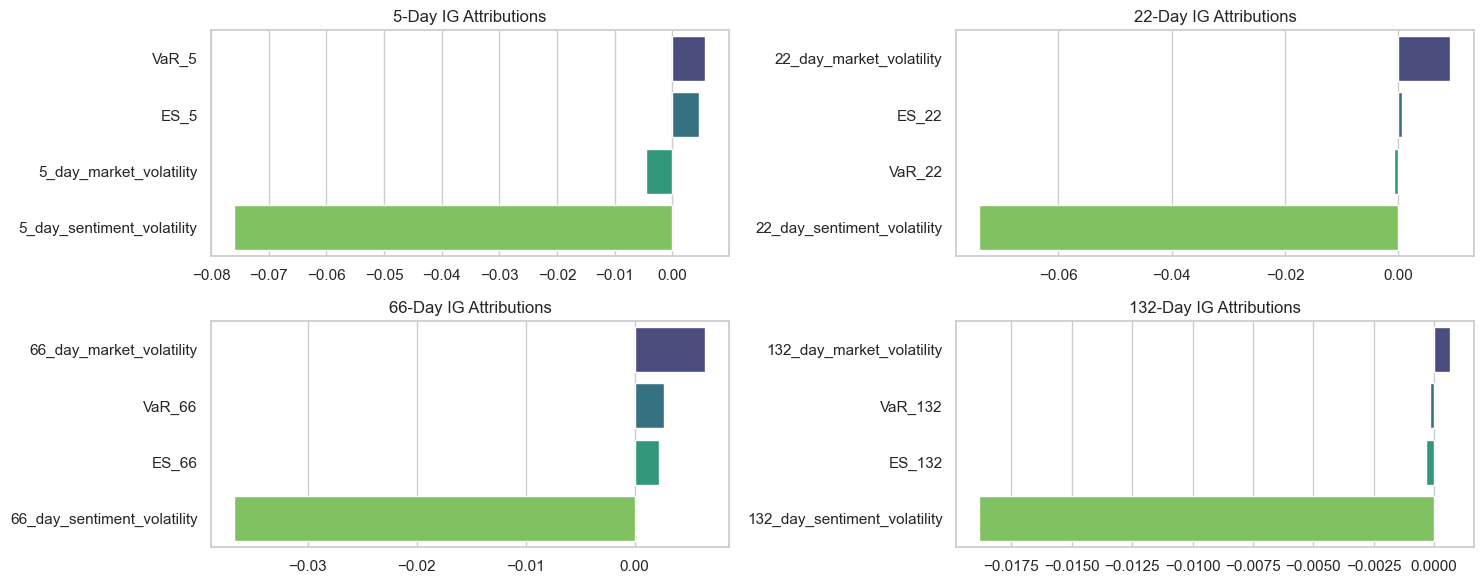

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


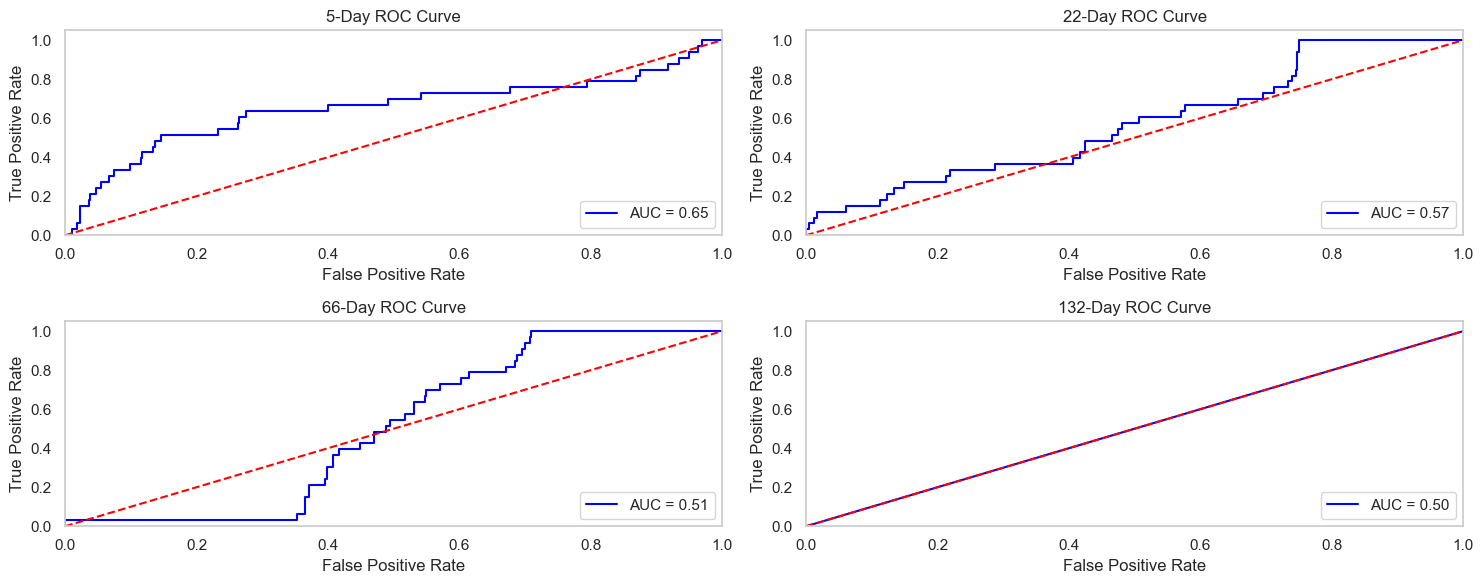

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


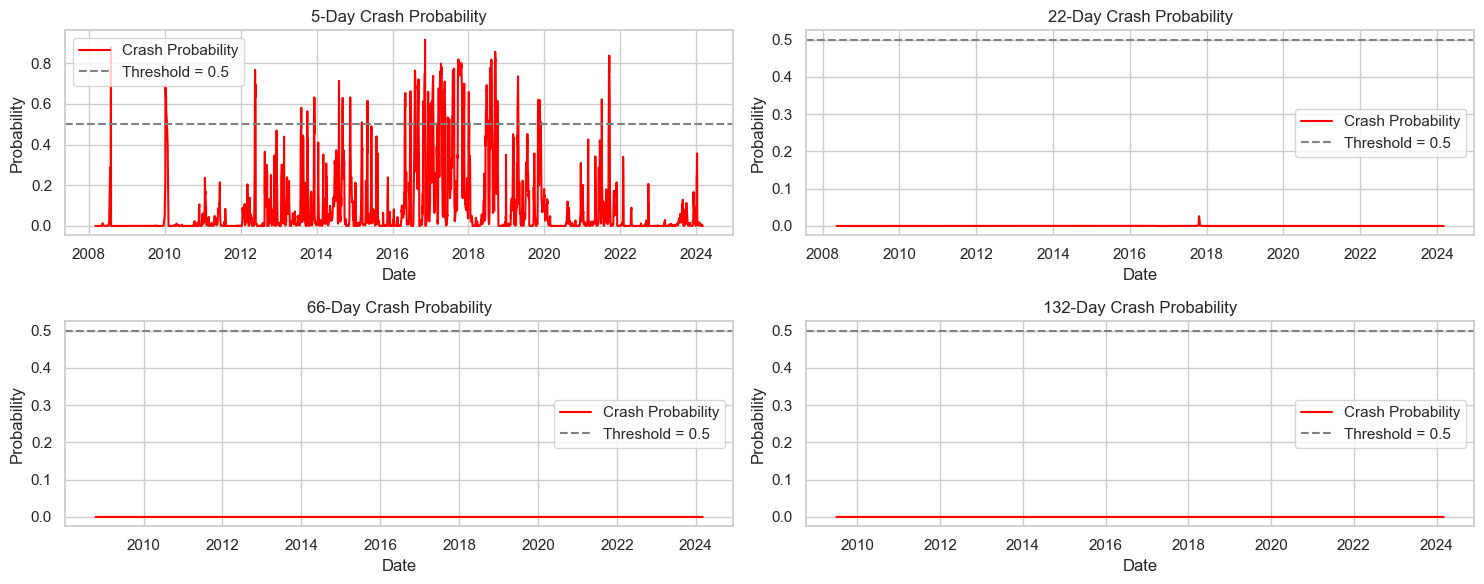

In [456]:
plot_ig_feature_attributions_grid(cnn_combined, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(cnn_combined, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(cnn_combined, market_sentiment_data_with_lag10, lag=10, window_size=window_size)

### CNN with Combined Features and Dynamic Threshold

In [279]:
# Define combined feature period
n = 0
window_size = 7  # Default window size for CNN
cnn_results_comp = {}

feature_cols = [
    # f'5_day_market_volatility',
    # f'5_day_sentiment_volatility',
    # f'VaR_5',
    # f'ES_5',
    f'22_day_market_volatility',
    f'22_day_sentiment_volatility',
    f'VaR_22',
    f'ES_22',
    # f'66_day_market_volatility',
    # f'66_day_sentiment_volatility',
    # f'VaR_66',
    # f'ES_66',
    # f'132_day_market_volatility',
    # f'132_day_sentiment_volatility',
    # f'VaR_132',
    # f'ES_132',
]

train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

# Prepare feature matrices and target vectors
X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
y_train = train_df['future_crash']
X_train_raw = X_train.values
y_train_raw = y_train.values

X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
y_test = test_df['future_crash']
X_test_raw = X_test.values
y_test_raw = y_test.values

# X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

# Convert to DataFrame for convenience
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.Series(y_train_resampled)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_raw)

X_train_seq, y_train_seq, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
X_test_seq, y_test_seq, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)

# Define CNN model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, X_train_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weight_dict = dict(enumerate(class_weights_array))

# Train
cnn_model.fit(X_train_seq, y_train_seq, epochs=15, batch_size=32, validation_split=0.2, verbose=0, 
                class_weight=class_weight_dict)

y_prob = cnn_model.predict(X_test_seq).flatten()
best_threshold = dynamic_threshold_calculate(y_test_seq, y_prob)
y_pred = (y_prob > best_threshold).astype(int)

# Evaluate
auc = roc_auc_score(y_test_seq, y_prob)
report = classification_report(y_test_seq, y_pred, output_dict=True)
conf = confusion_matrix(y_test_seq, y_pred)

# Save model and results
cnn_results_comp[n] = {
    'model': cnn_model,
    'auc_score': auc_score,
    'report': report,
    'y_test': y_test_seq,
    'y_prob': y_prob,
    'features': feature_cols,
    'confusion': conf,
}

X_test_dict[n] = X_test_seq
y_test_dict[n] = y_test_seq

print(f"\n=== Combined CNN Model ===")
print(f"AUC: {auc:.3f}")
print(classification_report(y_test_seq, y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Best threshold: 0.03, F1: 0.30

=== Combined CNN Model ===
AUC: 0.793
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       495
           1       0.19      0.58      0.29        36

    accuracy                           0.80       531
   macro avg       0.58      0.70      0.59       531
weighted avg       0.91      0.80      0.85       531



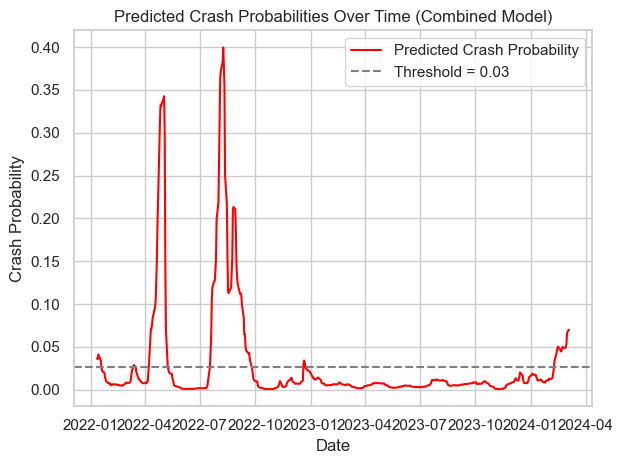

In [217]:
# Recover dates aligned with the test sequence (drop first `window_size - 1` rows)
date_seq = test_df['Date'].iloc[window_size:].reset_index(drop=True)

# Create a DataFrame to plot
prob_df = pd.DataFrame({
    'Date': date_seq,
    'Crash_Probability': y_prob,
    'Actual_Crash': y_test_seq,
})

# Sort by date just in case
prob_df = prob_df.sort_values('Date')

# Plot
plt.plot(prob_df['Date'], prob_df['Crash_Probability'], label='Predicted Crash Probability', color='red')
# plt.plot(prob_df['Date'], prob_df['Actual_Crash'], color='red', label='Actual Crash')
plt.axhline(y=best_threshold, color='gray', linestyle='--', label=f'Threshold = {best_threshold:.2f}')
plt.title(f'Predicted Crash Probabilities Over Time (Combined Model)')
plt.xlabel('Date')
plt.ylabel('Crash Probability')
plt.legend()
plt.tight_layout()
plt.show()

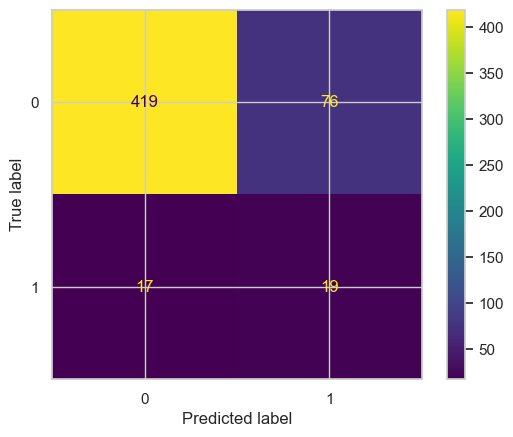

In [218]:
cm = confusion_matrix(y_test_seq, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

## LSTM

In [464]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def lstm_model(n, feature_cols, market_sentiment_data, lstm_results, X_test_dict, y_test_dict):
    train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
    test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']
    X_train_raw = X_train.values
    y_train_raw = y_train.values

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    X_test_raw = X_test.values
    y_test_raw = y_test.values

    # X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

    # Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_raw)

    X_train, y_train, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
    X_test, y_test, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)


    lstm_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Predict
    y_prob = lstm_model.predict(X_test).flatten()
    best_threshold = dynamic_threshold_calculate(y_test, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf = confusion_matrix(y_test, y_pred)

    # Save model and results
    lstm_results[n] = {
        'model': lstm_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test,
        'y_prob': y_prob,
        'features': feature_cols,
        'confusion': conf,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day LSTM Model ===")
    print(f"AUC: {auc:.3f}")
    print(report)

### LSTM (Market)

In [465]:
lstm_market = {}
X_test_dict = {}
y_test_dict = {}

window_size = 7  # Default window size 

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_market, X_test_dict, y_test_dict)

all_results.append(lstm_market)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.6253 - loss: 0.4600 - val_AUC: 0.5095 - val_loss: 0.4037
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6440 - loss: 0.1352 - val_AUC: 0.4839 - val_loss: 0.4046
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6758 - loss: 0.1719 - val_AUC: 0.4581 - val_loss: 0.4085
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6774 - loss: 0.1405 - val_AUC: 0.4711 - val_loss: 0.3774
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6837 - loss: 0.1486 - val_AUC: 0.4434 - val_loss: 0.4071
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6506 - loss: 0.1521 - val_AUC: 0.4462 - val_loss: 0.4203
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6315 - loss: 0.1700 - val_AUC: 0.4288 - val_loss: 0.4403
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7022 - loss: 0.1561 - val_AUC: 0.4484 - val_loss: 0.4486
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6497 - loss: 

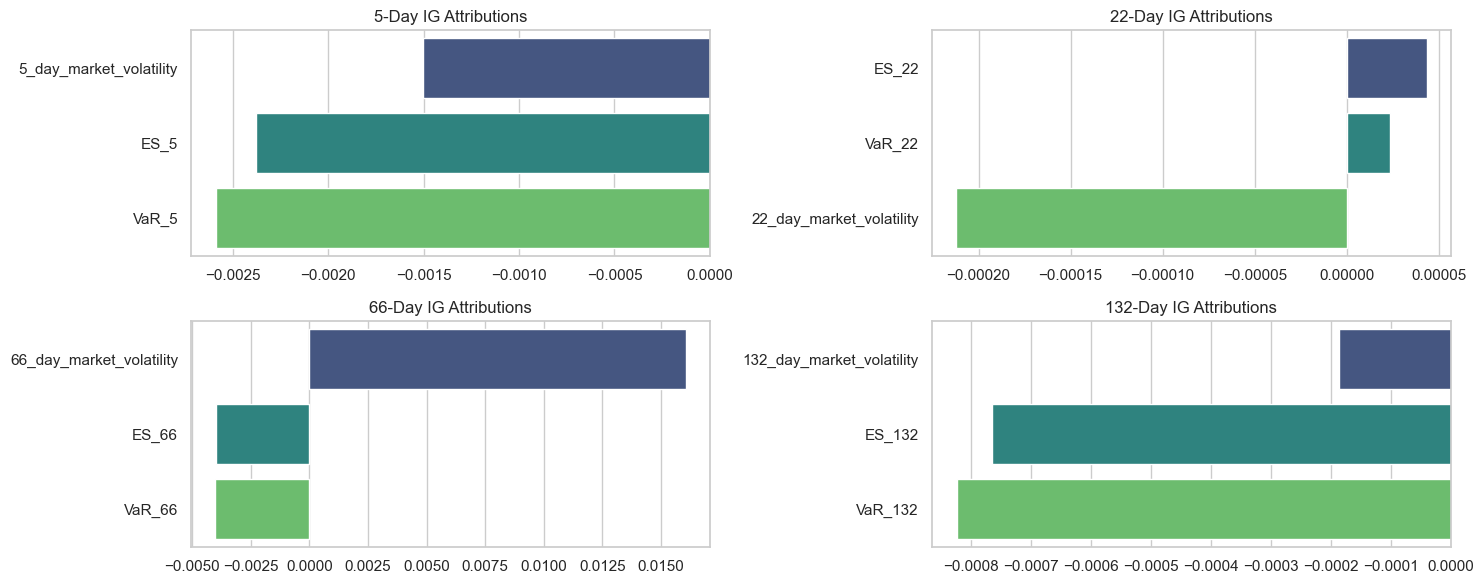

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


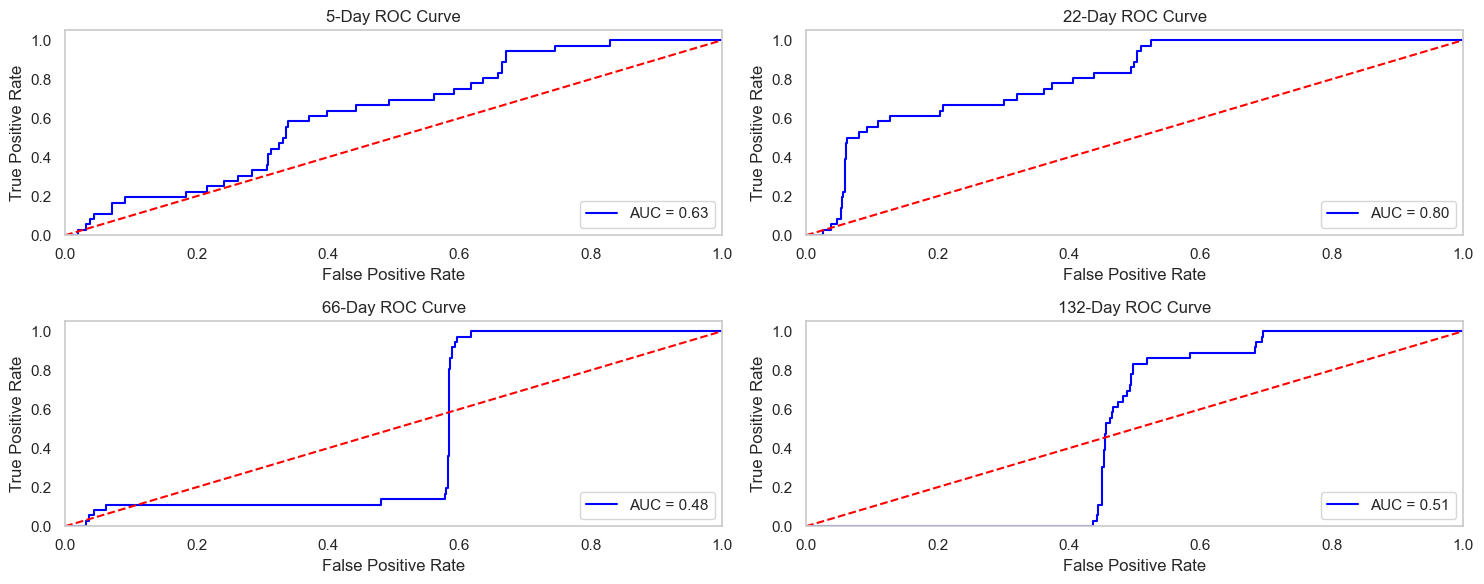

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


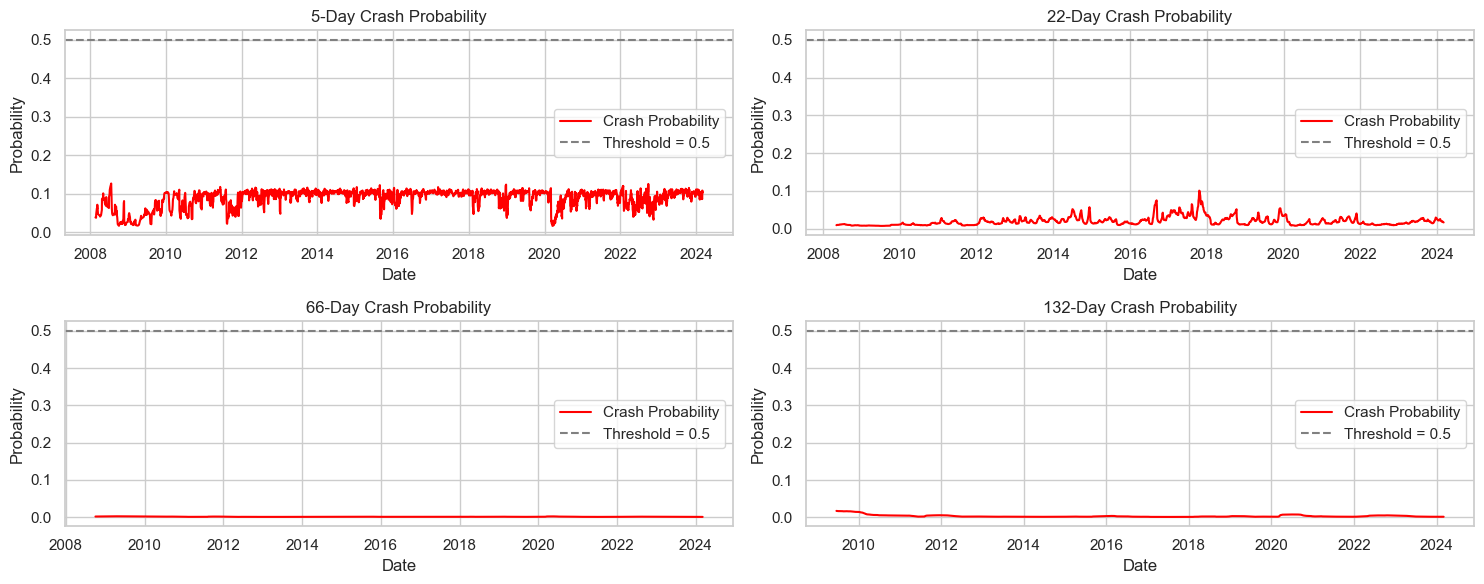

In [466]:
plot_ig_feature_attributions_grid(lstm_market, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(lstm_market, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(lstm_market, market_sentiment_data, window_size=window_size)

### LSTM (Sentiment)

In [467]:
lstm_sentiment = {}
X_test_dict = {}
y_test_dict = {}

window_size = 7  # Default window size 

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_sentiment, X_test_dict, y_test_dict)

all_results.append(lstm_sentiment)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.3441 - loss: 0.5175 - val_AUC: 0.3633 - val_loss: 0.6498
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7736 - loss: 0.1454 - val_AUC: 0.3495 - val_loss: 0.6277
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8332 - loss: 0.1335 - val_AUC: 0.3399 - val_loss: 0.6131
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8736 - loss: 0.1216 - val_AUC: 0.3285 - val_loss: 0.6103
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8241 - loss: 0.1351 - val_AUC: 0.3344 - val_loss: 0.6726
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8396 - loss: 0.1243 - val_AUC: 0.3340 - val_loss: 0.6846
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8408 - loss: 0.1300 - val_AUC: 0.3322 - val_loss: 0.6887
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8277 - loss: 0.1412 - val_AUC: 0.3365 - val_loss: 0.6944
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8277 - loss: 

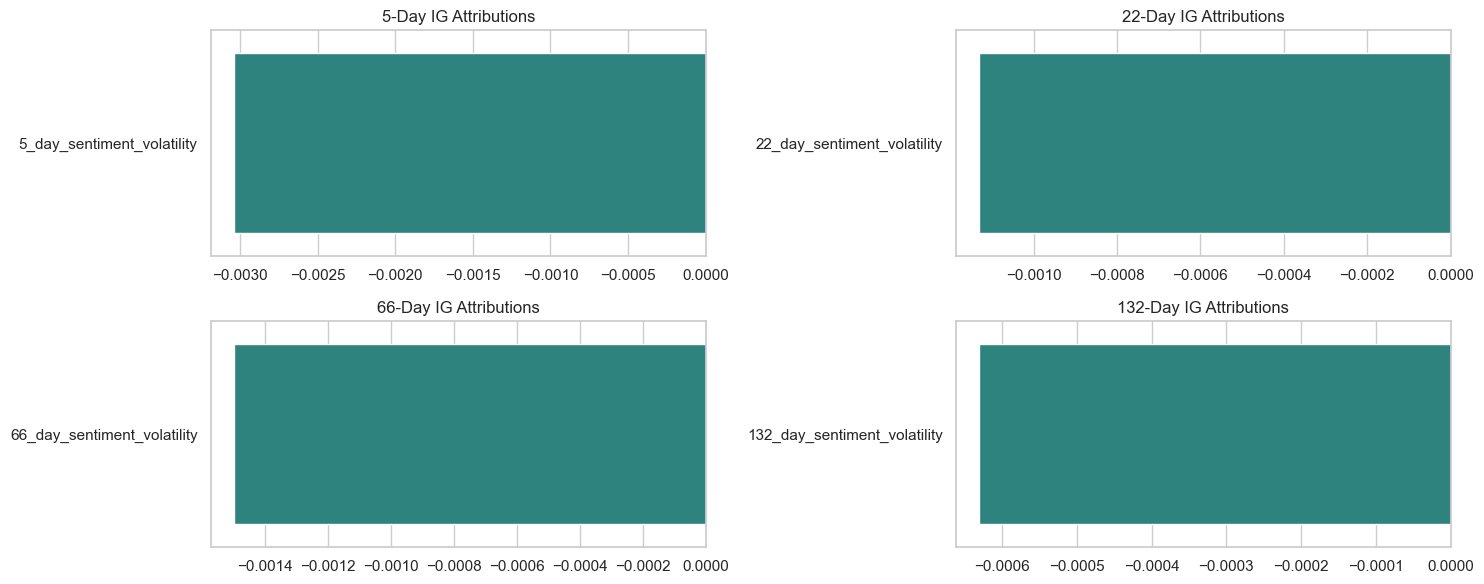

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


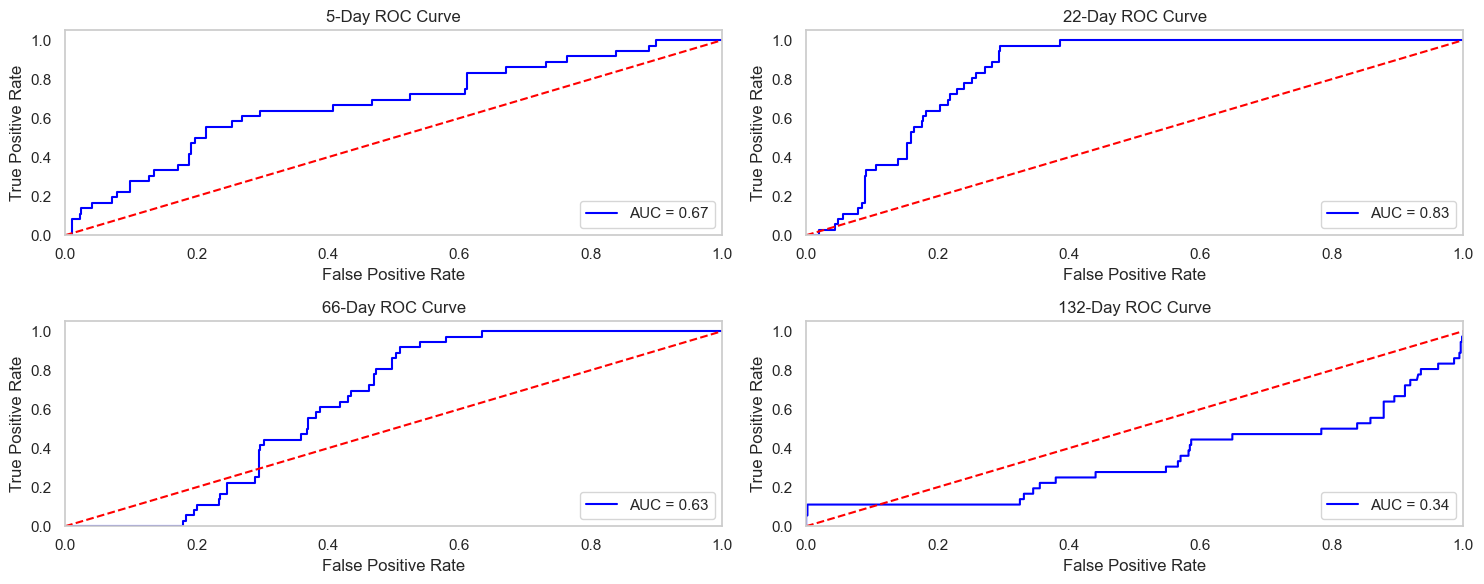

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


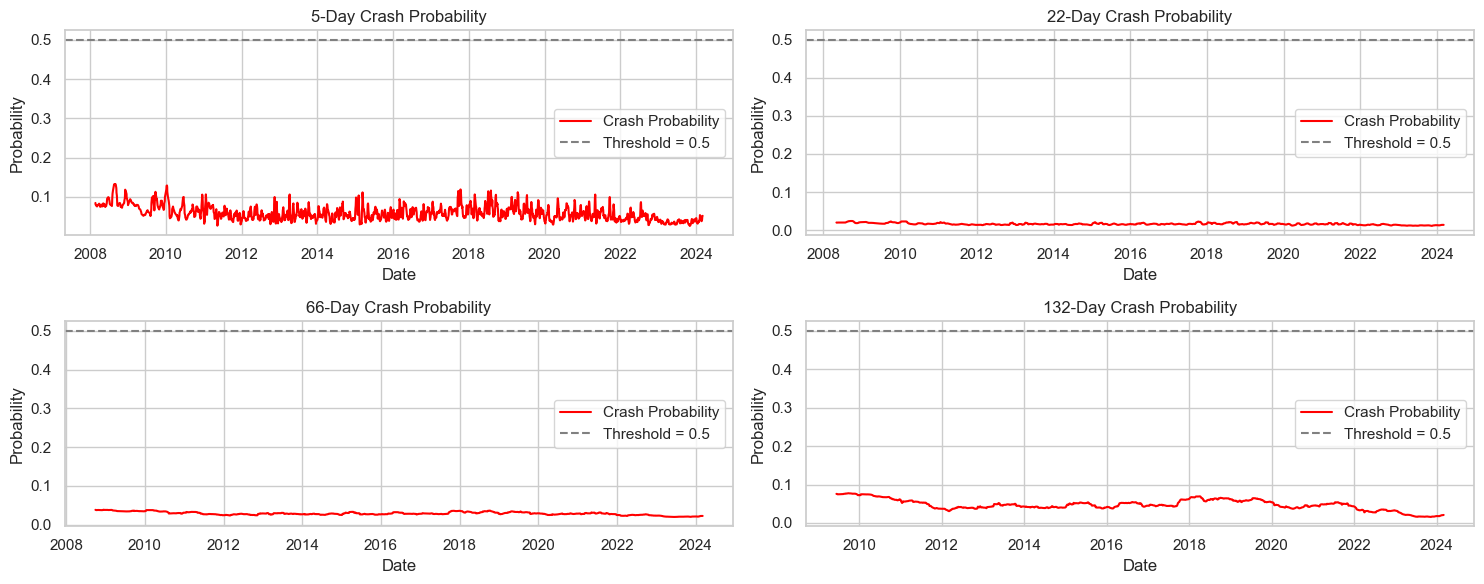

In [468]:
plot_ig_feature_attributions_grid(lstm_sentiment, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(lstm_sentiment, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(lstm_sentiment, market_sentiment_data, window_size=window_size)

### LSTM (Market + Sentiment)

In [469]:
lstm_combined = {}
X_test_dict = {}
y_test_dict = {}

window_size = 7  # Default window size 

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_combined, X_test_dict, y_test_dict)

all_results.append(lstm_combined)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.6108 - loss: 0.4919 - val_AUC: 0.4154 - val_loss: 0.5722
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8256 - loss: 0.1426 - val_AUC: 0.3432 - val_loss: 0.5757
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8710 - loss: 0.1127 - val_AUC: 0.3117 - val_loss: 0.5801
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8554 - loss: 0.1350 - val_AUC: 0.3281 - val_loss: 0.6582
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8714 - loss: 0.1206 - val_AUC: 0.3448 - val_loss: 0.6970
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8937 - loss: 0.1065 - val_AUC: 0.3250 - val_loss: 0.6836
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9017 - loss: 0.1175 - val_AUC: 0.3237 - val_loss: 0.6909
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8876 - loss: 0.1219 - val_AUC: 0.3239 - val_loss: 0.7122
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8738 - loss: 

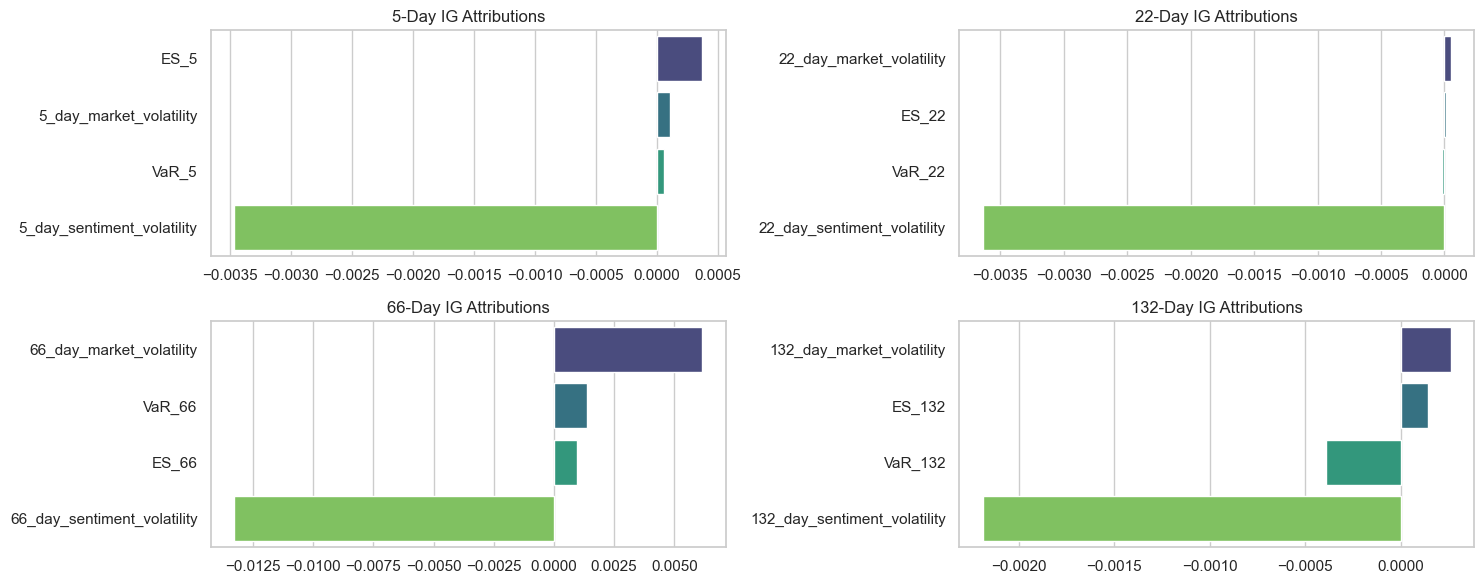

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


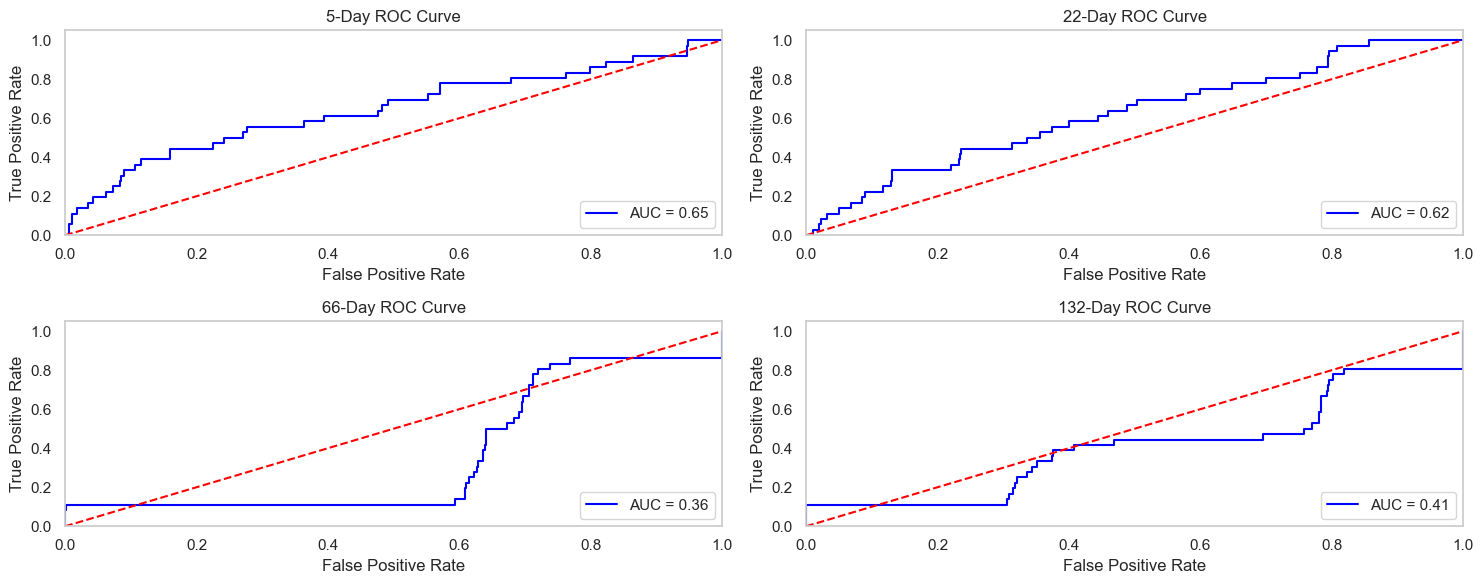

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


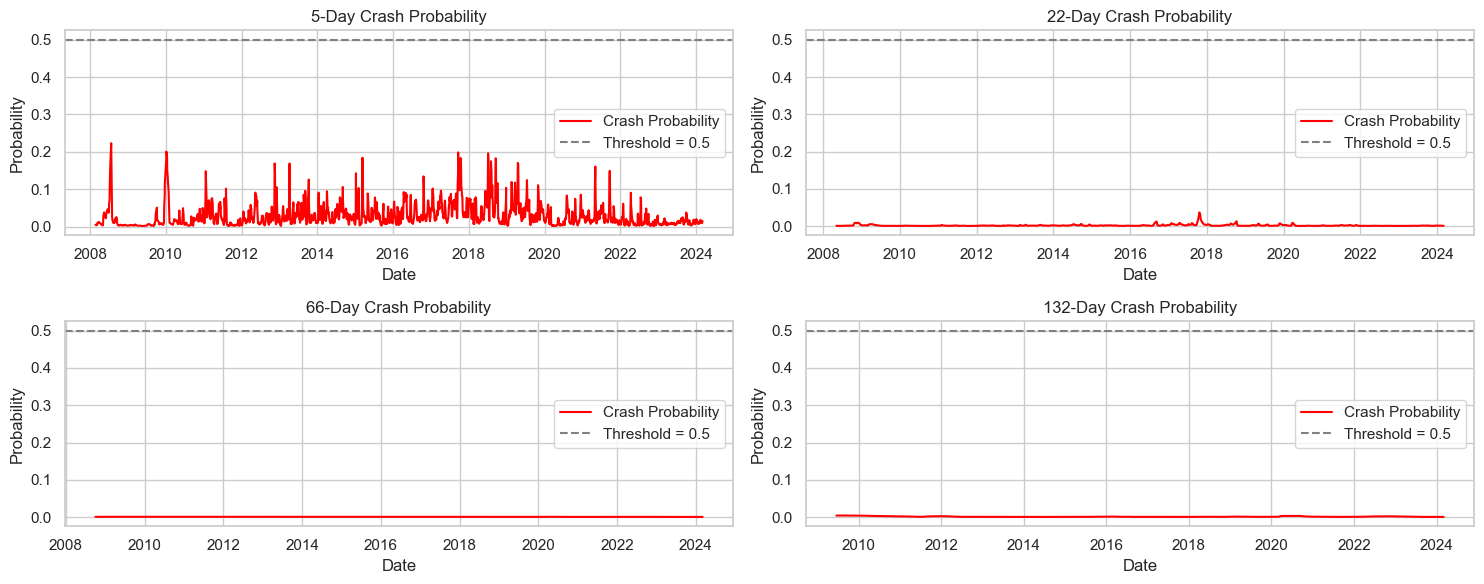

In [470]:
plot_ig_feature_attributions_grid(lstm_combined, X_test_dict, window_size=window_size)
plot_CNN_roc_curves_grid(lstm_combined, X_test_dict, y_test_dict)
plot_crash_probabilities_grid_CNN(lstm_combined, market_sentiment_data, window_size=window_size)

## Evaluate

In [487]:
# Summarize table of results -> Sensitivity, Specificity, Accuracy, AUC
i = 0
results_summary = []
results_dicts = [static_logit_market, static_logit_sentiment, static_logit_combined,
                 dynamic_logit_market, dynamic_logit_sentiment, dynamic_logit_combined,
                 cnn_market, cnn_sentiment, cnn_combined,
                 lstm_market, lstm_sentiment, lstm_combined]
results_dicts_name = ['Static Logit (Market)', 'Static Logit (Sentiment)', 'Static Logit (Combined)',
                      'Dynamic Logit (Market)', 'Dynamic Logit (Sentiment)', 'Dynamic Logit (Combined)',
                      'CNN (Market)', 'CNN (Sentiment)', 'CNN (Combined)',
                        'LSTM (Market)', 'LSTM (Sentiment)', 'LSTM (Combined)']

for results in results_dicts:
    for n in volatility_period:    
        if n in results:
            res = results[n]
            auc_score = res['auc_score']
            sensitivity = res['report']['1']['recall']
            specificity = res['report']['0']['recall']
            accuracy = (res['confusion'].trace() / res['confusion'].sum()).item()
            f1_score = res['report']['1']['f1-score']
        else:
            auc_score = sensitivity = specificity = accuracy = f1_score = None

        results_summary.append({
            'model': f'{results_dicts_name[i]} {n}-Day Window',
            'sensitivity': sensitivity,
            'specificity': specificity,
            'accuracy': accuracy,
            'auc_score': auc_score,
            'f1_score': f1_score,
        })
        
    i += 1

# Define weighted scoring function
w_sens = 0.5
w_spec = 0.2
w_acc = 0.05
w_auc = 0.05
w_f1 = 0.2

def weighted_score(sensitivity, specificity, accuracy, auc_score, f1_score, w_sens, w_spec, w_acc, w_auc, w_f1):
    # Handle None values safely
    if None in (sensitivity, specificity, accuracy, auc_score, f1_score):
        return None

    return (w_sens * sensitivity +
            w_spec * specificity +
            w_acc * accuracy +
            w_auc * auc_score +
            w_f1 * f1_score)

results_summary_df = pd.DataFrame(results_summary)
results_summary_df = results_summary_df.dropna().reset_index(drop=True)

results_summary_df['weighted_score'] = results_summary_df.apply(
    lambda row: weighted_score(row['sensitivity'], row['specificity'],
                               row['accuracy'], row['auc_score'], row['f1_score'],
                               w_sens, w_spec, w_acc, w_auc, w_f1),
    axis=1
)

# Sort by weighted score (descending)
results_summary_df = results_summary_df.sort_values(by='weighted_score', ascending=False).reset_index(drop=True)
results_summary_df

model  sensitivity  specificity  \
0              CNN (Sentiment) 22-Day Window     0.939394     0.743434   
1             LSTM (Sentiment) 22-Day Window     0.944444     0.705051   
2      Static Logit (Combined) 22-Day Window     0.860465     0.747475   
3              CNN (Sentiment) 66-Day Window     0.969697     0.476768   
4      Dynamic Logit (Market) 132-Day Window     0.604651     0.937374   
5    Dynamic Logit (Combined) 132-Day Window     0.604651     0.937374   
6   Dynamic Logit (Sentiment) 132-Day Window     0.604651     0.937374   
7                LSTM (Market) 66-Day Window     0.944444     0.404040   
8             LSTM (Sentiment) 66-Day Window     0.888889     0.490909   
9       Dynamic Logit (Market) 22-Day Window     0.604651     0.884848   
10    Dynamic Logit (Combined) 22-Day Window     0.604651     0.884848   
11   Dynamic Logit (Sentiment) 22-Day Window     0.604651     0.884848   
12                CNN (Market) 22-Day Window     0.727273     0.749495   
13               CNN (Market) 132-Day Window     0.969697     0.337374   
14                CNN (Market) 66-Day Window     0.939394     0.355556   
15              CNN (Combined) 66-Day Window     0.969697     0.290909   
16                 CNN (Market) 5-Day Window     0.939394     0.341414   
17    Dynamic Logit (Sentiment) 5-Day Window     0.720930     0.684848   
18       Dynamic Logit (Market) 5-Day Window     0.720930     0.684848   
19     Dynamic Logit (Combined) 5-Day Window     0.720930     0.684848   
20     Static Logit (Combined) 66-Day Window     1.000000     0.236364   
21       Static Logit (Market) 66-Day Window     0.976744     0.260606   
22      Static Logit (Market) 132-Day Window     0.837209     0.486869   
23      Static Logit (Combined) 5-Day Window     0.837209     0.466667   
24              LSTM (Market) 132-Day Window     0.805556     0.503030   
25               LSTM (Market) 22-Day Window     0.472222     0.937374   
26    Static Logit (Sentiment) 66-Day Window     1.000000     0.113131   
27        Static Logit (Market) 5-Day Window     0.860465     0.307071   
28    Dynamic Logit (Combined) 66-Day Window     1.000000     0.062626   
29   Dynamic Logit (Sentiment) 66-Day Window     1.000000     0.062626   
30      Dynamic Logit (Market) 66-Day Window     1.000000     0.062626   
31    Static Logit (Sentiment) 22-Day Window     0.441860     0.894949   
32               CNN (Combined) 5-Day Window     0.484848     0.854545   
33             LSTM (Sentiment) 5-Day Window     0.527778     0.785859   
34       Static Logit (Market) 22-Day Window     0.534884     0.769697   
35              CNN (Sentiment) 5-Day Window     0.454545     0.834343   
36                LSTM (Market) 5-Day Window     0.555556     0.660606   
37              LSTM (Combined) 5-Day Window     0.361111     0.884848   
38    Static Logit (Combined) 132-Day Window     0.255814     0.997980   
39   Static Logit (Sentiment) 132-Day Window     0.232558     0.997980   
40             LSTM (Combined) 22-Day Window     0.305556     0.868687   
41     Static Logit (Sentiment) 5-Day Window     0.255814     0.915152   
42            LSTM (Combined) 132-Day Window     0.083333     1.000000   
43           LSTM (Sentiment) 132-Day Window     0.083333     0.997980   
44             LSTM (Combined) 66-Day Window     0.083333     0.997980   
45              CNN (Combined) 22-Day Window     0.090909     0.983838   
46             CNN (Combined) 132-Day Window     0.000000     1.000000   
47            CNN (Sentiment) 132-Day Window     0.000000     1.000000   

    accuracy  auc_score  f1_score  weighted_score  
0   0.755682   0.835800  0.324607        0.762879  
1   0.721281   0.835800  0.314815        0.754049  
2   0.756506   0.832088  0.360976        0.731352  
3   0.507576   0.835800  0.197531        0.686877  
4   0.910781   0.835800  0.520000        0.681129  
5   0.910781   0.835800  0.520000        0.681129  
6   0.910781   0.835800  0.520000        0.68112

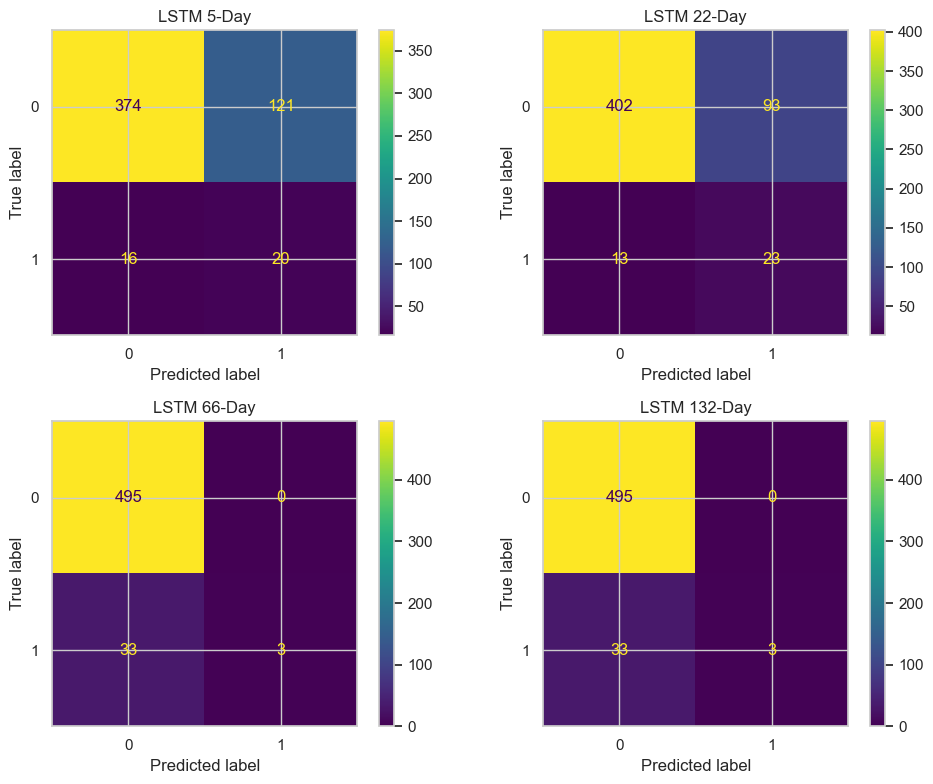

In [188]:
conf_matrices = []
titles = []
for n in volatility_period:
    conf_matrices.append(lstm_combined[n]['confusion'])
    titles.append(f'LSTM {n}-Day')

plot_confusion_matrix_grid(conf_matrices, titles, ncols=2)

#### LSTM with Combined Features and Dynamic Threshold

In [223]:
# Define combined feature period
n = 0
window_size = 7  # Default window size for CNN
lstm_results_comp = {}

feature_cols = [
    # f'5_day_market_volatility',
    # f'5_day_sentiment_volatility',
    # f'VaR_5',
    # f'ES_5',
    f'22_day_market_volatility',
    f'22_day_sentiment_volatility',
    f'VaR_22',
    f'ES_22',
    # f'66_day_market_volatility',
    # f'66_day_sentiment_volatility',
    # f'VaR_66',
    # f'ES_66',
    # f'132_day_market_volatility',
    # f'132_day_sentiment_volatility',
    # f'VaR_132',
    # f'ES_132',
    # f'252_day_market_volatility',
    # f'252_day_sentiment_volatility',
]

train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

# Prepare feature matrices and target vectors
X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
y_train = train_df['future_crash']
X_train_raw = X_train.values
y_train_raw = y_train.values

X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
y_test = test_df['future_crash']
X_test_raw = X_test.values
y_test_raw = y_test.values

# X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

# Convert to DataFrame for convenience
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.Series(y_train_resampled)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_raw)

X_train, y_train, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
X_test, y_test, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)

lstm_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

lstm_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.3, verbose=1)

# Predict
y_prob = lstm_model.predict(X_test).flatten()
best_threshold = dynamic_threshold_calculate(y_test, y_prob)
y_pred = (y_prob > best_threshold).astype(int)

# Evaluate
auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)

# Save model and results
lstm_results_comp[n] = {
    'model': lstm_model,
    'auc_score': auc_score,
    'report': report,
    'y_test': y_test,
    'y_prob': y_prob,
    'features': feature_cols,
    'confusion': conf,
}

X_test_dict[n] = X_test
y_test_dict[n] = y_test

print(f"\n=== Custom LSTM Model ===")
print(f"AUC: {auc:.3f}")
print(report)

Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.7309 - loss: 0.4909 - val_AUC: 0.3372 - val_loss: 0.4157
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8263 - loss: 0.1159 - val_AUC: 0.3271 - val_loss: 0.3570
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8376 - loss: 0.1455 - val_AUC: 0.3287 - val_loss: 0.3871
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8485 - loss: 0.1001 - val_AUC: 0.3216 - val_loss: 0.3883
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8310 - loss: 0.1043 - val_AUC: 0.3447 - val_loss: 0.4017
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8443 - loss: 0.1092 - val_AUC: 0.3463 - val_loss: 0.4086
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8390 - loss: 0.1013 - val_AUC: 0.3403 - val_loss: 0.4042
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8717 - loss: 0.1069 - val_AUC: 0.3436 - val_loss: 0.3990
Epoch 9/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8290 - loss: 

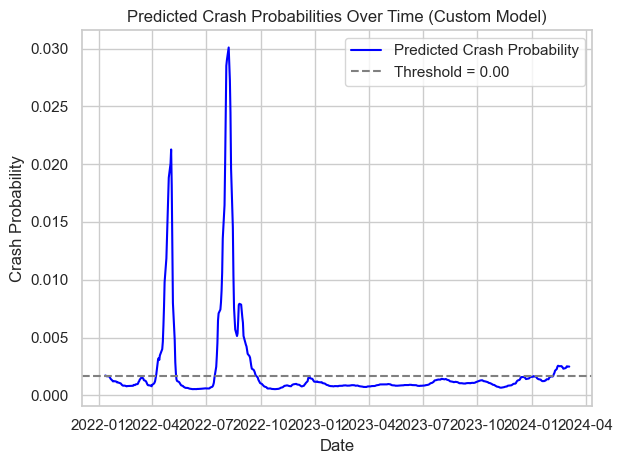

In [224]:
# Recover dates aligned with the test sequence (drop first `window_size - 1` rows)
date_seq = test_df['Date'].iloc[window_size:].reset_index(drop=True)

# Create a DataFrame to plot
prob_df = pd.DataFrame({
    'Date': date_seq,
    'Crash_Probability': y_prob,
    'Actual_Crash': y_test,
})

# Sort by date just in case
prob_df = prob_df.sort_values('Date')

# Plot
plt.plot(prob_df['Date'], prob_df['Crash_Probability'], label='Predicted Crash Probability', color='blue')
plt.axhline(y=best_threshold, color='gray', linestyle='--', label=f'Threshold = {best_threshold:.2f}')
plt.title(f'Predicted Crash Probabilities Over Time (Custom Model)')
plt.xlabel('Date')
plt.ylabel('Crash Probability')
plt.legend()
plt.tight_layout()
plt.show()

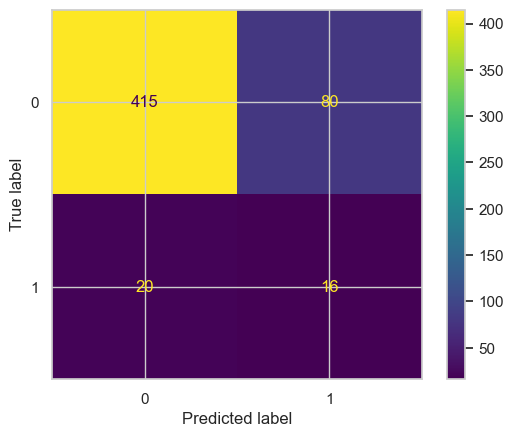

In [225]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

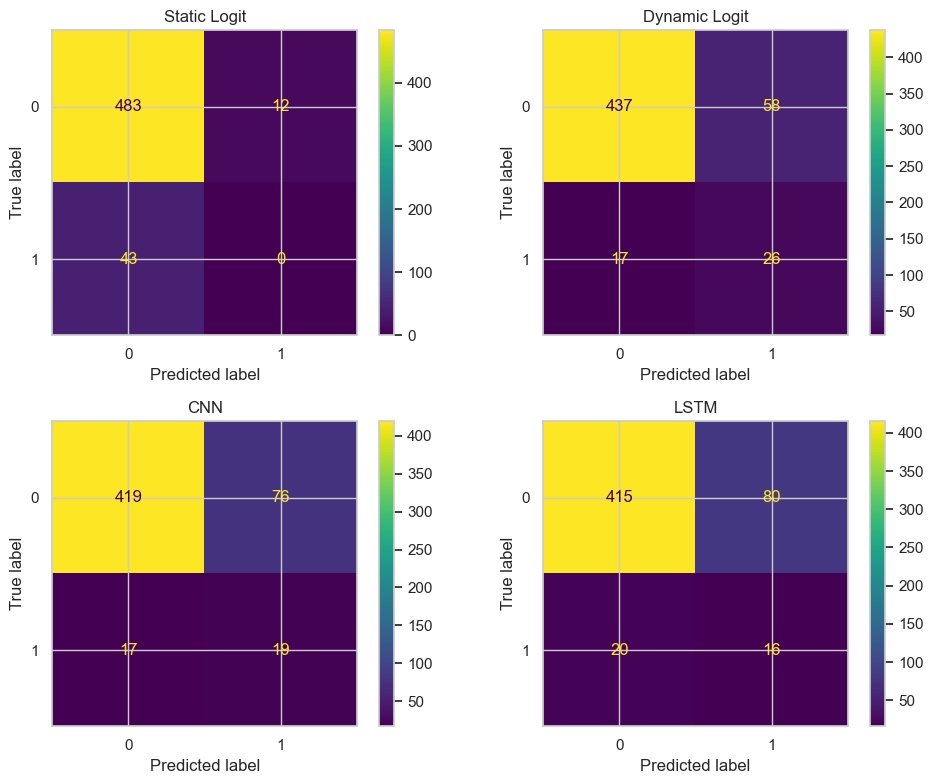

In [227]:
conf_matrices = [
    logit_results_comp[0]['confusion'],
    logit_results_comp[1]['confusion'],
    cnn_results_comp[0]['confusion'],
    lstm_results_comp[0]['confusion']
]

titles = ['Static Logit', 'Dynamic Logit', 'CNN', 'LSTM']

plot_confusion_matrix_grid(conf_matrices, titles, ncols=2)

In [228]:
print(f"\n=== Static Logit ===")
print(logit_results_comp[0]['report'])
print(f"\n=== Dynamic Logit ===")
print(logit_results_comp[1]['report'])
print(f"\n=== CNN ===")
print(cnn_results_comp[0]['report'])
print(f"\n=== LSTM ===")
print(lstm_results_comp[0]['report'])


=== Static Logit ===
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       495
           1       0.00      0.00      0.00        43

    accuracy                           0.90       538
   macro avg       0.46      0.49      0.47       538
weighted avg       0.84      0.90      0.87       538


=== Dynamic Logit ===
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       495
           1       0.31      0.60      0.41        43

    accuracy                           0.86       538
   macro avg       0.64      0.74      0.67       538
weighted avg       0.91      0.86      0.88       538


=== CNN ===
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       495
           1       0.20      0.53      0.29        36

    accuracy                           0.82       531
   macro avg       0.58      0.69      0.60       531
weighted avg    

## RF + Logit

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Setup ---
RANDOM_STATE = 42

# Select features and target
features = [
    '5_day_market_volatility',
    '5_day_sentiment_volatility',
    'VaR_5',
    'ES_5',
    '22_day_market_volatility',
    '22_day_sentiment_volatility',
    'VaR_22',
    'ES_22',
    '66_day_market_volatility',
    '66_day_sentiment_volatility',
    'VaR_66',
    'ES_66',
    '132_day_market_volatility',
    '132_day_sentiment_volatility',
    'VaR_132',
    'ES_132',
]
target = 'future_crash'

# Drop NA values
df_model = market_sentiment_data.dropna(subset=features + [target]).copy()
X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

# --- Step 1: Random Forest for Feature Selection ---
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced', max_depth=10, min_samples_split=5, min_samples_leaf=2)
rf.fit(X_train, y_train)

# Get feature importances
feat_importances = pd.Series(rf.feature_importances_, index=features)
top_features = feat_importances.sort_values(ascending=False).head(5).index.tolist()

print("Top Features from Random Forest:")
print(top_features)

# --- Step 2: Logistic Regression with Top Features ---
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_test_scaled = scaler.transform(X_test_top)

# Fit logistic regression
logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logit.fit(X_train_scaled, y_train)

# Predict
y_proba = logit.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluation
auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

# Coefficients
coefs = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\n=== Logistic Regression Results ===")
print(f"AUC: {auc:.3f}")
print(report)


Top Features from Random Forest:
['132_day_sentiment_volatility', '22_day_sentiment_volatility', '66_day_sentiment_volatility', 'VaR_132', 'ES_132']

=== Logistic Regression Results ===
AUC: 0.680
              precision    recall  f1-score   support

           0       0.98      0.57      0.72      3649
           1       0.06      0.65      0.10       143

    accuracy                           0.58      3792
   macro avg       0.52      0.61      0.41      3792
weighted avg       0.94      0.58      0.70      3792



In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, mean_squared_error
import statsmodels.api as sm
import numpy as np

# Assume y_test, y_pred, y_proba, and X_train_scaled already defined
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = recall_score(y_test, y_pred, pos_label=1)
specificity = tn / (tn + fp)
misclass_error = 1 - accuracy_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_proba))

# McFadden's R² and AIC via statsmodels
X_train_const = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_const).fit(disp=False)

mcfadden_r2 = 1 - logit_model.llf / logit_model.llnull
aic = logit_model.aic

print("Sensitivity (Recall for 1):", round(sensitivity, 3))
print("Specificity (True Negative Rate):", round(specificity, 3))
print("Misclassification Error:", round(misclass_error, 3))
print("RMSE:", round(rmse, 3))
print("McFadden Pseudo R²:", round(mcfadden_r2, 3))
print("AIC:", round(aic, 2))

Sensitivity (Recall for 1): 0.65
Specificity (True Negative Rate): 0.574
Misclassification Error: 0.424
RMSE: 0.483
McFadden Pseudo R²: 0.039
AIC: 4699.74
